In [1]:
from astropy.io import fits
import numpy as np
from astropy.table import QTable,vstack
import astropy.units as u
import astropy.utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import lognorm
from astropy.timeseries import LombScargle
import time
from astropy.visualization import hist
from scipy.optimize import curve_fit
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.time import Time
import functions
import upsilon
from tqdm import tqdm

-------------------------------
* WARNING: No pyFFTW detected *
-------------------------------


In [2]:
# Do a ZTF query --> topcat merge with 1 arcsec --> the following code to prepare the raw zr and zg table 

In [50]:
t=QTable.read('t_ZTF_matched_1arcsec_0621.csv')
t=t['GroupID','filtercode','oid','ra','dec','ngoodobsrel']
t.rename_column('GroupID', 'SourceID')
t.rename_column('filtercode', 'filter')
t.rename_column('oid', 'OID')
t.rename_column('ngoodobsrel', 'numobs')
t.rename_column('ra', 'RA')
t.rename_column('dec', 'DEC')

In [62]:
t_zr=t[t['filter']=='zr']
t_zg=t[t['filter']=='zg']
#t_zr.write('t_zr_0621_raw.ecsv',overwrite=True)
#t_zg.write('t_zg_0621_raw.ecsv',overwrite=True)

In [63]:
t['SourceID'].max()

2181

In [64]:
t_zr['SourceID'].mask.nonzero()[0].shape

(662,)

In [65]:
IDsupply=np.arange(2182,2182+662)
for i,idx in enumerate(t_zr['SourceID'].mask.nonzero()[0]):
    t_zr[idx]['SourceID']=IDsupply[i]

In [66]:
t_zg['SourceID'].mask.nonzero()[0].shape

(392,)

In [68]:
np.arange(2182,2182+662)[-1]

2843

In [69]:
IDsupply=np.arange(2844,2844+392)
for i,idx in enumerate(t_zg['SourceID'].mask.nonzero()[0]):
    t_zg[idx]['SourceID']=IDsupply[i]

In [71]:
t_zr.write('t_zr_0621_raw.ecsv',overwrite=True)
t_zg.write('t_zg_0621_raw.ecsv',overwrite=True)

In [3]:
# calculate statistics

In [2]:
def constant_fit(x,a):
    return a

# Load a classification model.
rf_model = upsilon.load_rf_model()

error_zr=[]
t=QTable.read('t_zr_0621_raw.ecsv')

t.add_column(np.zeros(len(t)),name='DELTA_SIG_MAG',index=-1)
t.add_column(np.zeros(len(t)),name='CONST_CHI2',index=-1)
t.add_column(np.zeros(len(t)),name='sf',index=-1)
t.add_column(np.zeros(len(t)),name='LNP_SIG',index=-1)
t.add_column(np.zeros(len(t)),name='period',index=-1)
t.add_column(np.zeros(len(t)),name='period_c',index=-1)
t.add_column(np.zeros(len(t)),name='power',index=-1)
t.add_column(np.zeros(len(t)),name='power_c',index=-1)

t.add_column(np.empty(len(t),'S14'),name='upsilon_class',index=-1)
t.add_column(np.zeros(len(t)),name='upsilon_prob',index=-1)
t.add_column(np.zeros(len(t)),name='upsilon_flag',index=-1)
t.add_column(np.zeros(len(t)),name='upsilon_period',index=-1)


for i,row in tqdm(enumerate(t),total=len(t)):
    ID_str=str(int(row['OID']))
    try:
        t_ZTF=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+ID_str)
    except:
        print('2nd download attempt in 30 seconds...')
        time.sleep(30)
        try:
            t_ZTF=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+ID_str)
        except:
            print('3rd download attempt in 30 seconds...')
            time.sleep(30)
            try:
                t_ZTF=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+ID_str)
            except:
                print('last attempt failed, saving the index to error_zr')
                error_zr.append(i)
    
    t_ZTF=t_ZTF[(t_ZTF['mjd']<58481*u.day)|(t_ZTF['mjd']>58482*u.day)]
    t_ZTF=t_ZTF[(t_ZTF['mjd']<58472*u.day)|(t_ZTF['mjd']>58474*u.day)]
    t_ZTF=t_ZTF[(t_ZTF['mjd']<59032*u.day)|(t_ZTF['mjd']>59033*u.day)]
    
    
    if len(t_ZTF)<10:
        t[i]['DELTA_SIG_MAG']=np.nan
        t[i]['CONST_CHI2']=np.nan
        t[i]['sf']=np.nan
        t[i]['LNP_SIG']=np.nan
        t[i]['period']=np.nan
        t[i]['period_c']=np.nan
        t[i]['power']=np.nan
        t[i]['power_c']=np.nan
        t[i]['upsilon_class']=np.nan
        t[i]['upsilon_prob']=np.nan
        t[i]['upsilon_flag']=np.nan
        t[i]['upsilon_period']=np.nan

        print('This guy has too few observations')
    else:
        DELTA_SIG_MAG=(t_ZTF['mag'].max()-t_ZTF['mag'].min())/(t_ZTF['magerr'][t_ZTF['mag'].argmax()]**2+t_ZTF['magerr'][t_ZTF['mag'].argmin()]**2)

        popt, pcov = curve_fit(constant_fit,t_ZTF['mjd'],t_ZTF['mag'],sigma=t_ZTF['magerr'])
        CHI2=(((t_ZTF['mag'].value-popt)**2)/(t_ZTF['magerr'].value**2)).sum()
        CONST_CHI2=CHI2/(len(t_ZTF)-1)
        sf=chi2.sf(CHI2,(len(t_ZTF)-1))
        
        ls = LombScargle(t_ZTF['mjd'],t_ZTF['mag'], t_ZTF['magerr'])
        try:
            freq, power = ls.autopower(nyquist_factor=300,minimum_frequency=1/(2800*u.day),maximum_frequency=1/(0.1*u.day))
            LNP_SIG=ls.false_alarm_probability(power.max())
            period=(1./freq[power.argmax()]).value
            powermax=power.max().value
            powermax_ind=power.argmax()
        except:
            LNP_SIG=np.nan
            period=np.nan
            powermax=np.nan
            powermax_ind=np.nan
            
        con_mag=np.zeros(t_ZTF['mag'].shape)+t_ZTF['mag'].mean()
        con_err=np.zeros(t_ZTF['magerr'].shape)+t_ZTF['magerr'].mean()
        ls = LombScargle(t_ZTF['mjd'],con_mag, con_err,fit_mean=False, center_data=False)
        try:
            freq, power = ls.autopower(nyquist_factor=300,minimum_frequency=1/(2800*u.day),maximum_frequency=1/(0.1*u.day))
            period_1=(1./freq[power.argmax()]).value
            if np.isnan(powermax_ind):
                powermax_c=np.nan
            else:
                powermax_c=power[powermax_ind].value
        except:
            period_1=np.nan
            powermax_c=np.nan
            
        t[i]['DELTA_SIG_MAG']=DELTA_SIG_MAG.value
        t[i]['CONST_CHI2']=CONST_CHI2
        t[i]['sf']=sf
        t[i]['LNP_SIG']=LNP_SIG
        t[i]['period']=period
        t[i]['period_c']=period_1
        t[i]['power']=powermax
        t[i]['power_c']=powermax_c
    
        try:
            # Extract features (date,mag,magerr)
            e_features = upsilon.ExtractFeatures(np.array(t_ZTF['mjd']),np.array(t_ZTF['mag']),np.array(t_ZTF['magerr']))
            e_features.run()
            features = e_features.get_features()
    
            # Classify the light curve
            label, probability, flag = upsilon.predict(rf_model, features)
            # label, probability, flag,features['period']
    
            t[i]['upsilon_class']=label
            t[i]['upsilon_prob']=probability
            t[i]['upsilon_flag']=flag
            t[i]['upsilon_period']=features['period']
        except:
            t[i]['upsilon_class']=np.nan
            t[i]['upsilon_prob']=np.nan
            t[i]['upsilon_flag']=np.nan
            t[i]['upsilon_period']=np.nan
            
    #_=input('no bug!')

    

t.write('t_zr_0621.ecsv')
print('Hooray! Done zr!')
astropy.utils.data.clear_download_cache()

D:\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
  0%|                                                                               | 2/4099 [00:09<4:50:28,  4.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of da

This guy has too few observations


  0%|▏                                                                              | 9/4099 [00:35<3:36:32,  3.18s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  0%|▏                                                                             | 10/4099 [00:37<3:24:12,  3.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  0%|▏                                                                             | 11/4099 [00:40<3:18:40,  2.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  0%|▏                                                                             | 13/4099 [00:44<2:42:25,  2.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  0%|▎                                                                             | 16/4099 [00:56<4:10:51,  3.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  0%|▎                                                                             | 17/4099 [00:59<4:02:19,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  0%|▎                                                                             | 19/4099 [01:03<3:02:42,  2.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▍                                                                             | 22/4099 [01:19<5:19:26,  4.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▍                                                                             | 24/4099 [01:22<3:29:40,  3.09s/it]

This guy has too few observations


  1%|▍                                                                             | 25/4099 [01:23<2:58:14,  2.62s/it]

This guy has too few observations


  1%|▌                                                                             | 27/4099 [01:36<5:27:00,  4.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▌                                                                             | 32/4099 [01:53<4:10:49,  3.70s/it]

This guy has too few observations


  1%|▋                                                                             | 33/4099 [02:00<5:16:01,  4.66s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▋                                                                             | 34/4099 [02:03<4:49:12,  4.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▋                                                                             | 35/4099 [02:06<4:11:35,  3.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▋                                        

This guy has too few observations


  1%|▊                                                                             | 42/4099 [02:29<3:23:20,  3.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▊                                                                             | 44/4099 [02:33<2:44:56,  2.44s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▉                                                                             | 46/4099 [02:41<3:50:44,  3.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▉                                                                             | 48/4099 [02:45<3:04:46,  2.74s/it]

This guy has too few observations


  1%|▉                                                                             | 49/4099 [02:46<2:37:57,  2.34s/it]

This guy has too few observations


  1%|▉                                                                             | 51/4099 [02:53<3:03:37,  2.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▉                                                                             | 52/4099 [02:57<3:25:06,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|█                                                                             | 53/4099 [03:00<3:23:17,  3.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|█                                                                             | 55/4099 [03:04<2:50:13,  2.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|█                                                                             | 56/4099 [03:06<2:30:40,  2.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|█▏                                                                            | 61/4099 [03:32<4:47:54,  4.28s/it]

This guy has too few observations


  2%|█▏                                                                            | 63/4099 [03:38<3:57:53,  3.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▏                                                                            | 64/4099 [03:40<3:29:28,  3.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▎                                                                            | 66/4099 [03:48<4:20:07,  3.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▎                                                                            | 69/4099 [04:01<4:27:12,  3.98s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▎                                                                            | 70/4099 [04:03<3:46:31,  3.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▍                                                                            | 74/4099 [04:19<4:09:37,  3.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▍                                                                            | 75/4099 [04:21<3:36:54,  3.23s/it]

2nd download attempt in 30 seconds...


  2%|█▍                                                                           | 77/4099 [05:07<12:46:42, 11.44s/it]

This guy has too few observations


  2%|█▍                                                                           | 78/4099 [05:16<12:08:34, 10.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▌                                                                            | 81/4099 [05:26<6:24:54,  5.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▌                                                                            | 82/4099 [05:30<6:01:59,  5.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▋                                                                            | 88/4099 [05:59<4:53:29,  4.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▋                                                                            | 91/4099 [06:10<4:36:18,  4.14s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▊                                                                            | 93/4099 [06:14<3:23:11,  3.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▊                                                                            | 95/4099 [06:19<3:15:32,  2.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▊                                                                            | 96/4099 [06:22<3:08:20,  2.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▉                                                                            | 99/4099 [06:32<3:24:19,  3.06s/it]

This guy has too few observations


  2%|█▉                                                                           | 100/4099 [06:33<2:52:32,  2.59s/it]

This guy has too few observations


  3%|█▉                                                                           | 106/4099 [07:03<4:05:01,  3.68s/it]

This guy has too few observations


  3%|██                                                                           | 108/4099 [07:16<5:16:38,  4.76s/it]

This guy has too few observations


  3%|██                                                                           | 109/4099 [07:18<4:32:05,  4.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██                                                                           | 111/4099 [07:27<4:59:56,  4.51s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▏                                                                          | 117/4099 [07:48<3:47:27,  3.43s/it]

This guy has too few observations


  3%|██▏                                                                          | 118/4099 [07:56<5:21:56,  4.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▎                                                                          | 122/4099 [08:10<4:15:19,  3.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▎                                                                          | 124/4099 [08:14<3:06:45,  2.82s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▎                                                                          | 126/4099 [08:18<2:35:44,  2.35s/it]

This guy has too few observations


  3%|██▍                                                                          | 129/4099 [08:31<3:59:38,  3.62s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▍                                                                          | 130/4099 [08:34<3:30:30,  3.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▍                                                                          | 131/4099 [08:35<3:01:45,  2.75s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▌                                      

This guy has too few observations


  3%|██▋                                                                          | 140/4099 [09:06<2:32:14,  2.31s/it]

This guy has too few observations


  3%|██▋                                                                          | 141/4099 [09:15<4:46:25,  4.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▋                                                                          | 143/4099 [09:20<3:42:11,  3.37s/it]

This guy has too few observations


  4%|██▋                                                                          | 146/4099 [09:43<7:11:21,  6.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|██▊                                                                          | 147/4099 [09:49<6:54:36,  6.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|██▊                                                                          | 149/4099 [10:03<7:39:49,  6.98s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|██▊                                      

This guy has too few observations


  4%|██▊                                                                          | 152/4099 [10:08<3:37:34,  3.31s/it]

This guy has too few observations


  4%|██▊                                                                          | 153/4099 [10:14<4:43:48,  4.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|██▉                                                                          | 157/4099 [10:40<7:09:45,  6.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███                                                                          | 160/4099 [10:51<4:47:15,  4.38s/it]

This guy has too few observations


  4%|███                                                                          | 161/4099 [10:53<4:01:12,  3.68s/it]

This guy has too few observations


  4%|███                                                                          | 163/4099 [11:06<6:03:28,  5.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███                                                                          | 165/4099 [11:13<4:50:15,  4.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███                                                                          | 166/4099 [11:15<4:01:06,  3.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███▏                                     

This guy has too few observations


  4%|███▏                                                                         | 171/4099 [11:30<3:35:39,  3.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███▎                                                                         | 174/4099 [11:45<4:50:21,  4.44s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███▎                                                                         | 175/4099 [11:47<4:02:26,  3.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███▎                                     

This guy has too few observations


  4%|███▍                                                                         | 183/4099 [12:11<3:54:47,  3.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▍                                                                         | 186/4099 [12:20<3:19:29,  3.06s/it]

This guy has too few observations


  5%|███▌                                                                         | 187/4099 [12:22<3:12:08,  2.95s/it]

This guy has too few observations


  5%|███▌                                                                         | 188/4099 [12:24<2:48:15,  2.58s/it]

This guy has too few observations


  5%|███▌                                                                         | 189/4099 [12:32<4:32:49,  4.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▌                                                                         | 190/4099 [12:34<3:51:34,  3.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▋                                                                         | 193/4099 [12:48<4:31:00,  4.16s/it]

This guy has too few observations


  5%|███▋                                                                         | 194/4099 [12:53<4:33:18,  4.20s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▋                                                                         | 197/4099 [13:07<4:51:59,  4.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▊                                                                         | 206/4099 [13:41<3:23:22,  3.13s/it]

This guy has too few observations


  5%|███▉                                                                         | 207/4099 [13:43<3:09:14,  2.92s/it]

This guy has too few observations


  5%|███▉                                                                         | 208/4099 [13:46<2:56:59,  2.73s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▉                                                                         | 209/4099 [13:48<2:39:18,  2.46s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▉                                                                         | 210/4099 [13:50<2:33:23,  2.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▉                                                                         | 211/4099 [13:54<3:04:47,  2.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|████▏                                                                        | 220/4099 [14:21<2:40:08,  2.48s/it]

This guy has too few observations


  5%|████▏                                                                        | 224/4099 [14:39<4:14:48,  3.95s/it]

This guy has too few observations


  5%|████▏                                                                        | 225/4099 [14:44<4:25:32,  4.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▏                                                                        | 226/4099 [14:46<3:47:11,  3.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▎                                                                        | 230/4099 [15:02<4:22:14,  4.07s/it]

This guy has too few observations


  6%|████▎                                                                        | 231/4099 [15:05<3:50:24,  3.57s/it]

This guy has too few observations


  6%|████▎                                                                        | 232/4099 [15:06<3:09:44,  2.94s/it]

This guy has too few observations


  6%|████▍                                                                        | 233/4099 [15:12<4:13:55,  3.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▍                                                                        | 235/4099 [15:18<3:24:43,  3.18s/it]

This guy has too few observations


  6%|████▍                                                                        | 236/4099 [15:19<2:53:50,  2.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▍                                                                        | 238/4099 [15:28<4:13:50,  3.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▍                                                                        | 239/4099 [15:31<3:45:19,  3.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▌                                                                        | 240/4099 [15:34<3:34:14,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


  6%|████▋                                                                        | 252/4099 [16:16<2:45:13,  2.58s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▊                                                                        | 255/4099 [16:35<5:26:55,  5.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▊                                                                        | 256/4099 [16:37<4:24:56,  4.14s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▊                                                                        | 259/4099 [16:51<4:55:17,  4.61s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▉                                                                        | 265/4099 [17:08<3:21:13,  3.15s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████                                                                        | 267/4099 [17:13<2:58:15,  2.79s/it]

This guy has too few observations


  7%|█████                                                                        | 268/4099 [17:15<2:44:36,  2.58s/it]

This guy has too few observations


  7%|█████                                                                        | 269/4099 [17:17<2:26:13,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████                                                                        | 271/4099 [17:28<4:42:22,  4.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▏                                                                       | 274/4099 [17:42<4:46:27,  4.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▏                                                                       | 277/4099 [17:54<4:30:24,  4.24s/it]

This guy has too few observations


  7%|█████▏                                                                       | 278/4099 [17:56<3:35:24,  3.38s/it]

This guy has too few observations


  7%|█████▏                                                                       | 279/4099 [17:57<2:57:59,  2.80s/it]

This guy has too few observations


  7%|█████▎                                                                       | 280/4099 [18:08<5:23:36,  5.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▎                                                                       | 281/4099 [18:10<4:37:06,  4.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▎                                                                       | 283/4099 [18:14<3:15:21,  3.07s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▎                                                                       | 284/4099 [18:16<2:52:18,  2.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▍                                                                       | 287/4099 [18:24<2:41:04,  2.54s/it]

This guy has too few observations


  7%|█████▍                                                                       | 290/4099 [18:37<3:47:11,  3.58s/it]

This guy has too few observations


  7%|█████▌                                                                       | 293/4099 [18:59<6:41:14,  6.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▌                                                                       | 295/4099 [19:05<4:59:38,  4.73s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▌                                                                       | 296/4099 [19:07<3:58:21,  3.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▌                                   

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▋                                                                       | 304/4099 [19:35<3:31:52,  3.35s/it]

This guy has too few observations


  7%|█████▋                                                                       | 306/4099 [19:48<5:03:13,  4.80s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▊                                                                       | 307/4099 [19:51<4:24:50,  4.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▊                                                                       | 309/4099 [20:01<5:02:32,  4.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▊                                   

This guy has too few observations


  8%|█████▊                                                                       | 312/4099 [20:07<3:09:44,  3.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▉                                                                       | 313/4099 [20:09<2:48:43,  2.67s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▉                                                                       | 316/4099 [20:28<5:39:46,  5.39s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▉                                   

This guy has too few observations


  8%|██████▏                                                                      | 329/4099 [21:16<5:18:25,  5.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▏                                                                      | 330/4099 [21:18<4:32:28,  4.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▏                                                                      | 332/4099 [21:23<3:26:57,  3.30s/it]

This guy has too few observations


  8%|██████▎                                                                      | 333/4099 [21:30<4:37:42,  4.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▎                                                                      | 334/4099 [21:32<3:48:32,  3.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▎                                                                      | 339/4099 [21:49<3:28:16,  3.32s/it]

This guy has too few observations


  8%|██████▍                                                                      | 340/4099 [21:51<2:55:24,  2.80s/it]

This guy has too few observations


  8%|██████▍                                                                      | 342/4099 [22:01<4:05:50,  3.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▍                                                                      | 343/4099 [22:04<3:42:15,  3.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▍                                                                      | 346/4099 [22:24<6:09:31,  5.91s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▌                                  

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▌                                                                      | 351/4099 [22:40<3:50:04,  3.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▋                                                                      | 353/4099 [22:53<5:25:14,  5.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▋                                                                      | 358/4099 [23:14<4:18:27,  4.15s/it]

This guy has too few observations


  9%|██████▊                                                                      | 361/4099 [23:26<4:00:36,  3.86s/it]

This guy has too few observations


  9%|██████▊                                                                      | 364/4099 [23:40<4:28:12,  4.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▉                                                                      | 367/4099 [23:49<3:18:16,  3.19s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▉                                                                      | 369/4099 [23:54<2:59:40,  2.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▉                                                                      | 371/4099 [24:03<3:56:58,  3.81s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████                                                                      | 375/4099 [24:20<3:56:07,  3.80s/it]

This guy has too few observations


  9%|███████                                                                      | 376/4099 [24:28<5:00:09,  4.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████                                                                      | 377/4099 [24:30<4:11:45,  4.06s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████                                                                      | 379/4099 [24:33<2:58:39,  2.88s/it]

This guy has too few observations


  9%|███████▏                                                                     | 380/4099 [24:36<2:48:25,  2.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████▏                                                                     | 382/4099 [24:45<4:03:52,  3.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████▏                                                                     | 384/4099 [24:54<4:22:02,  4.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████▎                                                                     | 386/4099 [25:02<4:34:14,  4.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▎                                                                     | 390/4099 [25:16<4:06:43,  3.99s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▎                                                                     | 391/4099 [25:18<3:32:18,  3.44s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▍                                                                     | 393/4099 [25:23<2:53:09,  2.80s/it]

This guy has too few observations


 10%|███████▍                                                                     | 395/4099 [25:29<3:04:41,  2.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▍                                                                     | 397/4099 [25:34<2:34:37,  2.51s/it]

This guy has too few observations


 10%|███████▍                                                                     | 398/4099 [25:39<3:35:52,  3.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▌                                                                     | 402/4099 [25:56<3:52:17,  3.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▌                                                                     | 405/4099 [26:10<4:29:25,  4.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▋                                                                     | 411/4099 [26:37<5:26:15,  5.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▋                                                                     | 412/4099 [26:42<5:04:14,  4.95s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 10%|████████                                                                     | 427/4099 [27:51<3:22:03,  3.30s/it]

This guy has too few observations


 10%|████████                                                                     | 428/4099 [27:52<2:56:10,  2.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████                                                                     | 431/4099 [28:04<4:03:27,  3.98s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▏                                                                    | 433/4099 [28:09<3:17:26,  3.23s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▏                                                                    | 435/4099 [28:13<2:31:58,  2.49s/it]

This guy has too few observations


 11%|████████▎                                                                    | 440/4099 [28:41<6:24:32,  6.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▎                                                                    | 443/4099 [28:55<5:41:23,  5.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▎                                                                    | 444/4099 [28:58<4:38:47,  4.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▍                                

This guy has too few observations


 11%|████████▍                                                                    | 448/4099 [29:17<5:11:23,  5.12s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▍                                                                    | 450/4099 [29:22<3:58:11,  3.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▍                                                                    | 452/4099 [29:26<2:55:15,  2.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▌                                                                    | 453/4099 [29:29<2:51:41,  2.83s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▌                                                                    | 454/4099 [29:31<2:38:08,  2.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data point

This guy has too few observations


 11%|████████▌                                                                    | 457/4099 [29:43<3:51:43,  3.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▌                                                                    | 458/4099 [29:46<3:36:29,  3.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▌                                                                    | 459/4099 [29:48<3:23:53,  3.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▋                                

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▋                                                                    | 464/4099 [30:01<2:28:40,  2.45s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▊                                                                    | 466/4099 [30:06<2:29:58,  2.48s/it]

This guy has too few observations


 11%|████████▊                                                                    | 467/4099 [30:08<2:25:37,  2.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▊                                                                    | 470/4099 [30:20<3:25:26,  3.40s/it]

This guy has too few observations


 11%|████████▊                                                                    | 471/4099 [30:29<4:56:48,  4.91s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|████████▉                                                                    | 473/4099 [30:34<3:38:07,  3.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|████████▉                                                                    | 475/4099 [30:39<3:03:51,  3.04s/it]

This guy has too few observations


 12%|████████▉                                                                    | 476/4099 [30:40<2:32:14,  2.52s/it]

This guy has too few observations


 12%|████████▉                                                                    | 478/4099 [30:50<3:22:05,  3.35s/it]

This guy has too few observations


 12%|████████▉                                                                    | 479/4099 [30:51<2:49:30,  2.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████                                                                    | 482/4099 [30:57<2:11:41,  2.18s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▏                                                                   | 486/4099 [31:12<3:12:04,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▏                                                                   | 487/4099 [31:14<2:52:32,  2.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▏                                                                   | 489/4099 [31:18<2:26:04,  2.43s/it]

This guy has too few observations


 12%|█████████▏                                                                   | 490/4099 [31:20<2:13:04,  2.21s/it]

This guy has too few observations


 12%|█████████▏                                                                   | 492/4099 [31:31<3:37:15,  3.61s/it]

This guy has too few observations


 12%|█████████▎                                                                   | 494/4099 [31:44<5:11:13,  5.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▎                                                                   | 496/4099 [31:51<4:37:59,  4.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▎                                                                   | 498/4099 [31:55<3:08:15,  3.14s/it]

This guy has too few observations


 12%|█████████▎                                                                   | 499/4099 [31:57<2:41:19,  2.69s/it]

This guy has too few observations


 12%|█████████▍                                                                   | 500/4099 [32:05<4:20:50,  4.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▍                                                                   | 501/4099 [32:08<3:53:33,  3.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▍                                                                   | 502/4099 [32:10<3:21:06,  3.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▍                               

This guy has too few observations


 12%|█████████▍                                                                   | 505/4099 [32:15<2:17:05,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▌                                                                   | 507/4099 [32:19<2:09:18,  2.16s/it]

This guy has too few observations


 12%|█████████▌                                                                   | 510/4099 [32:32<2:53:56,  2.91s/it]

This guy has too few observations


 12%|█████████▌                                                                   | 512/4099 [32:40<3:28:43,  3.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▋                                                                   | 513/4099 [32:42<3:01:07,  3.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▋                                                                   | 515/4099 [32:46<2:26:29,  2.45s/it]

This guy has too few observations


 13%|█████████▋                                                                   | 517/4099 [32:57<3:55:27,  3.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▋                                                                   | 518/4099 [32:59<3:26:26,  3.46s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▊                                                                   | 520/4099 [33:02<2:28:06,  2.48s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▊                                                                   | 522/4099 [33:09<2:59:23,  3.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▊                                                                   | 524/4099 [33:12<2:14:32,  2.26s/it]

This guy has too few observations


 13%|█████████▉                                                                   | 527/4099 [33:25<3:02:01,  3.06s/it]

This guy has too few observations


 13%|█████████▉                                                                   | 528/4099 [33:27<2:41:18,  2.71s/it]

This guy has too few observations


 13%|█████████▉                                                                   | 530/4099 [33:38<4:05:36,  4.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▉                                                                   | 532/4099 [33:42<2:58:58,  3.01s/it]

This guy has too few observations


 13%|██████████                                                                   | 533/4099 [33:44<2:35:25,  2.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████                                                                   | 537/4099 [33:55<2:35:55,  2.63s/it]

This guy has too few observations


 13%|██████████                                                                   | 538/4099 [33:59<2:59:13,  3.02s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▏                                                                  | 539/4099 [34:01<2:39:56,  2.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▏                                                                  | 540/4099 [34:03<2:25:42,  2.46s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▏                              

This guy has too few observations


 13%|██████████▏                                                                  | 545/4099 [34:21<4:17:06,  4.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▎                                                                  | 548/4099 [34:34<4:04:27,  4.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▎                                                                  | 550/4099 [34:37<2:47:56,  2.84s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▎                                                                  | 552/4099 [34:40<2:11:19,  2.22s/it]

This guy has too few observations


 13%|██████████▍                                                                  | 553/4099 [34:41<1:53:27,  1.92s/it]

This guy has too few observations


 14%|██████████▍                                                                  | 554/4099 [34:43<1:44:00,  1.76s/it]

This guy has too few observations


 14%|██████████▍                                                                  | 555/4099 [34:44<1:39:56,  1.69s/it]

This guy has too few observations


 14%|██████████▍                                                                  | 556/4099 [34:46<1:33:00,  1.58s/it]

This guy has too few observations


 14%|██████████▍                                                                  | 558/4099 [34:56<3:01:31,  3.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▌                                                                  | 559/4099 [34:59<3:08:22,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▌                                                                  | 560/4099 [35:02<3:01:35,  3.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▌                              

This guy has too few observations


 14%|██████████▊                                                                  | 573/4099 [35:57<3:05:40,  3.16s/it]

This guy has too few observations


 14%|██████████▊                                                                  | 574/4099 [35:59<2:35:27,  2.65s/it]

This guy has too few observations


 14%|██████████▊                                                                  | 577/4099 [36:10<3:00:40,  3.08s/it]

This guy has too few observations


 14%|██████████▊                                                                  | 578/4099 [36:12<2:30:45,  2.57s/it]

This guy has too few observations


 14%|██████████▉                                                                  | 579/4099 [36:13<2:11:22,  2.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▉                                                                  | 580/4099 [36:15<2:03:03,  2.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▉                                                                  | 581/4099 [36:17<1:58:58,  2.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▉                                                                  | 583/4099 [36:21<2:00:31,  2.06s/it]

This guy has too few observations


 14%|██████████▉                                                                  | 584/4099 [36:23<1:47:42,  1.84s/it]

This guy has too few observations


 14%|██████████▉                                                                  | 585/4099 [36:24<1:44:38,  1.79s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|███████████                                                                  | 588/4099 [36:47<6:00:41,  6.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|███████████                                                                  | 590/4099 [36:51<4:02:39,  4.15s/it]

This guy has too few observations


 14%|███████████                                                                  | 591/4099 [36:53<3:17:21,  3.38s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|███████████                                                                  | 592/4099 [36:56<3:05:13,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|███████████▏                                                                 | 594/4099 [36:59<2:18:31,  2.37s/it]

This guy has too few observations


 15%|███████████▏                                                                 | 596/4099 [37:08<3:20:42,  3.44s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▏                                                                 | 597/4099 [37:10<2:51:51,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▏                                                                 | 598/4099 [37:12<2:35:49,  2.67s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\ext

This guy has too few observations


 15%|███████████▌                                                                 | 615/4099 [38:11<3:36:45,  3.73s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▌                                                                 | 617/4099 [38:14<2:32:47,  2.63s/it]

This guy has too few observations


 15%|███████████▌                                                                 | 618/4099 [38:22<3:53:44,  4.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▋                                                                 | 619/4099 [38:26<3:55:09,  4.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▋                                                                 | 621/4099 [38:30<2:54:08,  3.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▋                                                                 | 623/4099 [38:41<4:19:41,  4.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▋                                                                 | 625/4099 [38:46<3:20:02,  3.46s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▊                                                                 | 627/4099 [38:50<2:42:18,  2.80s/it]

This guy has too few observations


 15%|███████████▊                                                                 | 629/4099 [39:00<3:33:32,  3.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▊                                                                 | 632/4099 [39:06<2:22:18,  2.46s/it]

This guy has too few observations


 15%|███████████▉                                                                 | 633/4099 [39:07<2:02:30,  2.12s/it]

This guy has too few observations


 15%|███████████▉                                                                 | 635/4099 [39:13<2:24:30,  2.50s/it]

This guy has too few observations


 16%|███████████▉                                                                 | 636/4099 [39:15<2:10:31,  2.26s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|███████████▉                                                                 | 637/4099 [39:17<2:08:49,  2.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|███████████▉                                                                 | 638/4099 [39:20<2:13:09,  2.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████                                                                 | 640/4099 [39:23<1:56:43,  2.02s/it]

This guy has too few observations


 16%|████████████                                                                 | 641/4099 [39:25<1:55:27,  2.00s/it]

This guy has too few observations


 16%|████████████                                                                 | 642/4099 [39:27<1:45:01,  1.82s/it]

This guy has too few observations


 16%|████████████                                                                 | 643/4099 [39:29<1:52:03,  1.95s/it]

This guy has too few observations


 16%|████████████▏                                                                | 646/4099 [39:45<3:33:31,  3.71s/it]

This guy has too few observations


 16%|████████████▏                                                                | 648/4099 [39:49<2:48:07,  2.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▏                                                                | 650/4099 [39:54<2:25:52,  2.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▏                                                                | 652/4099 [40:01<2:55:09,  3.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▎                                                                | 653/4099 [40:03<2:36:26,  2.72s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data point

2nd download attempt in 30 seconds...


 16%|████████████▎                                                               | 663/4099 [41:31<13:29:22, 14.13s/it]

This guy has too few observations


 16%|████████████▍                                                                | 664/4099 [41:32<9:50:16, 10.31s/it]

This guy has too few observations


 16%|████████████▍                                                                | 665/4099 [41:34<7:17:29,  7.64s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▌                                                                | 669/4099 [41:49<5:11:28,  5.45s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▌                                                                | 670/4099 [41:52<4:26:36,  4.67s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▋                                                                | 675/4099 [42:09<3:06:52,  3.27s/it]

This guy has too few observations


 16%|████████████▋                                                                | 676/4099 [42:11<2:37:48,  2.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|████████████▋                                                                | 678/4099 [42:21<3:58:12,  4.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|████████████▊                                                                | 681/4099 [42:30<3:14:03,  3.41s/it]

This guy has too few observations


 17%|████████████▊                                                                | 682/4099 [42:36<3:50:12,  4.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|████████████▊                                                                | 683/4099 [42:38<3:19:59,  3.51s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|████████████▊                                                                | 685/4099 [42:43<2:55:23,  3.08s/it]

This guy has too few observations


 17%|████████████▉                                                                | 686/4099 [42:46<2:46:10,  2.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|████████████▉                                                                | 690/4099 [43:01<3:11:26,  3.37s/it]

This guy has too few observations


 17%|████████████▉                                                                | 691/4099 [43:04<3:08:59,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████                                                                | 693/4099 [43:13<3:47:20,  4.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████                                                                | 696/4099 [43:19<2:35:43,  2.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████                                                                | 698/4099 [43:24<2:19:08,  2.45s/it]

This guy has too few observations


 17%|█████████████▏                                                               | 699/4099 [43:29<3:03:03,  3.23s/it]

This guy has too few observations


 17%|█████████████▏                                                               | 700/4099 [43:30<2:36:26,  2.76s/it]

This guy has too few observations


 17%|█████████████▏                                                               | 701/4099 [43:32<2:16:10,  2.40s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▏                                                               | 703/4099 [43:37<2:21:51,  2.51s/it]

This guy has too few observations


 17%|█████████████▏                                                               | 704/4099 [43:39<2:04:50,  2.21s/it]

This guy has too few observations


 17%|█████████████▎                                                               | 707/4099 [43:52<3:19:41,  3.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▎                                                               | 709/4099 [43:59<3:20:40,  3.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▎                                                               | 711/4099 [44:02<2:20:14,  2.48s/it]

This guy has too few observations


 17%|█████████████▎                                                               | 712/4099 [44:03<2:02:36,  2.17s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▍                                                               | 715/4099 [44:14<2:51:13,  3.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▍                                                               | 717/4099 [44:18<2:19:11,  2.47s/it]

This guy has too few observations


 18%|█████████████▍                                                               | 718/4099 [44:21<2:28:54,  2.64s/it]

This guy has too few observations


 18%|█████████████▌                                                               | 719/4099 [44:23<2:13:53,  2.38s/it]

This guy has too few observations


 18%|█████████████▌                                                               | 722/4099 [44:34<2:38:43,  2.82s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▋                                                               | 726/4099 [44:47<2:58:50,  3.18s/it]

This guy has too few observations


 18%|█████████████▋                                                               | 727/4099 [44:49<2:31:03,  2.69s/it]

This guy has too few observations


 18%|█████████████▋                                                               | 729/4099 [44:55<2:42:41,  2.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▋                                                               | 730/4099 [44:58<2:31:42,  2.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▊                                                               | 732/4099 [45:05<3:08:36,  3.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▊                                                               | 733/4099 [45:07<2:50:07,  3.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 18%|█████████████▊                                                               | 737/4099 [45:15<1:52:25,  2.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▉                                                               | 741/4099 [45:28<2:46:39,  2.98s/it]

This guy has too few observations


 18%|█████████████▉                                                               | 742/4099 [45:29<2:20:23,  2.51s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▉                                                               | 744/4099 [45:36<2:49:42,  3.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|██████████████                                                               | 747/4099 [45:46<3:00:04,  3.22s/it]

This guy has too few observations


 18%|██████████████                                                               | 748/4099 [45:47<2:25:34,  2.61s/it]

This guy has too few observations


 18%|██████████████                                                               | 750/4099 [45:59<3:53:36,  4.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|██████████████                                                               | 751/4099 [46:03<3:50:25,  4.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|██████████████▏                                                              | 752/4099 [46:05<3:14:38,  3.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|██████████████▏                          

This guy has too few observations


 18%|██████████████▏                                                              | 758/4099 [46:24<2:37:21,  2.83s/it]

This guy has too few observations


 19%|██████████████▎                                                              | 759/4099 [46:27<2:34:27,  2.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▎                                                              | 760/4099 [46:30<2:36:30,  2.81s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▎                                                              | 762/4099 [46:43<4:40:26,  5.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▎                          

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▍                                                              | 766/4099 [46:52<2:41:26,  2.91s/it]

This guy has too few observations


 19%|██████████████▍                                                              | 767/4099 [46:54<2:15:33,  2.44s/it]

This guy has too few observations


 19%|██████████████▍                                                              | 768/4099 [46:55<2:05:53,  2.27s/it]

This guy has too few observations


 19%|██████████████▌                                                              | 774/4099 [47:21<3:00:34,  3.26s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▌                                                              | 778/4099 [47:34<2:45:23,  2.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▋                                                              | 779/4099 [47:36<2:39:57,  2.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▋                                                              | 782/4099 [47:49<3:30:55,  3.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▊                                                              | 786/4099 [48:17<5:24:48,  5.88s/it]

This guy has too few observations


 19%|██████████████▊                                                              | 790/4099 [48:30<3:25:32,  3.73s/it]

This guy has too few observations


 19%|██████████████▊                                                              | 791/4099 [48:32<2:49:50,  3.08s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▉                                                              | 793/4099 [48:36<2:20:59,  2.56s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▉                                                              | 794/4099 [48:39<2:19:44,  2.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▉                                                              | 796/4099 [48:42<1:58:38,  2.16s/it]

This guy has too few observations


 19%|██████████████▉                                                              | 797/4099 [48:44<1:49:56,  2.00s/it]

This guy has too few observations


 19%|██████████████▉                                                              | 798/4099 [48:46<1:42:29,  1.86s/it]

This guy has too few observations


 20%|███████████████                                                              | 800/4099 [48:49<1:40:52,  1.83s/it]

This guy has too few observations


 20%|███████████████                                                              | 802/4099 [48:54<1:50:49,  2.02s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████                                                              | 804/4099 [48:57<1:37:10,  1.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▏                                                             | 806/4099 [49:02<1:50:29,  2.01s/it]

This guy has too few observations


 20%|███████████████▏                                                             | 807/4099 [49:03<1:39:39,  1.82s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▏                                                             | 809/4099 [49:06<1:36:33,  1.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▏                                                             | 811/4099 [49:20<4:14:52,  4.65s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▎                                                             | 813/4099 [49:26<3:22:35,  3.70s/it]

This guy has too few observations


 20%|███████████████▎                                                             | 814/4099 [49:27<2:50:07,  3.11s/it]

This guy has too few observations


 20%|███████████████▎                                                             | 815/4099 [49:30<2:34:24,  2.82s/it]

This guy has too few observations


 20%|███████████████▎                                                             | 816/4099 [49:31<2:18:36,  2.53s/it]

This guy has too few observations


 20%|███████████████▎                                                             | 817/4099 [49:33<2:05:31,  2.29s/it]

This guy has too few observations


 20%|███████████████▎                                                             | 818/4099 [49:35<1:55:36,  2.11s/it]

This guy has too few observations


 20%|███████████████▍                                                             | 819/4099 [49:36<1:45:28,  1.93s/it]

This guy has too few observations


 20%|███████████████▍                                                             | 820/4099 [49:38<1:38:16,  1.80s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▍                                                             | 822/4099 [49:42<1:38:11,  1.80s/it]

This guy has too few observations


 20%|███████████████▍                                                             | 823/4099 [49:43<1:31:30,  1.68s/it]

This guy has too few observations


 20%|███████████████▍                                                             | 824/4099 [49:44<1:27:44,  1.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▍                                                             | 825/4099 [49:48<2:04:03,  2.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▌                                                             | 826/4099 [49:51<2:05:30,  2.30s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▌                                                             | 828/4099 [49:58<2:49:01,  3.10s/it]

This guy has too few observations


 20%|███████████████▌                                                             | 830/4099 [50:08<3:32:33,  3.90s/it]

This guy has too few observations


 20%|███████████████▋                                                             | 832/4099 [50:15<3:19:29,  3.66s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▋                                                             | 833/4099 [50:18<2:53:37,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▋                                                             | 834/4099 [50:20<2:38:51,  2.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▋                                                             | 835/4099 [50:23<2:47:25,  3.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 20%|███████████████▊                                                             | 839/4099 [50:37<2:58:59,  3.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▊                                                             | 840/4099 [50:39<2:34:29,  2.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|███████████████▊                                                             | 842/4099 [50:44<2:21:55,  2.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|███████████████▊                                                             | 844/4099 [50:49<2:20:35,  2.59s/it]

This guy has too few observations


 21%|███████████████▊                                                             | 845/4099 [50:51<2:01:48,  2.25s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|███████████████▉                                                             | 847/4099 [50:56<2:09:30,  2.39s/it]

This guy has too few observations


 21%|███████████████▉                                                             | 848/4099 [50:57<1:55:29,  2.13s/it]

This guy has too few observations


 21%|███████████████▉                                                             | 849/4099 [51:00<2:11:42,  2.43s/it]

This guy has too few observations


 21%|███████████████▉                                                             | 850/4099 [51:02<1:56:38,  2.15s/it]

This guy has too few observations


 21%|███████████████▉                                                             | 851/4099 [51:04<1:55:38,  2.14s/it]

This guy has too few observations


 21%|████████████████                                                             | 852/4099 [51:06<2:00:33,  2.23s/it]

This guy has too few observations


 21%|████████████████                                                             | 853/4099 [51:08<1:48:50,  2.01s/it]

This guy has too few observations


 21%|████████████████                                                             | 854/4099 [51:10<1:40:46,  1.86s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████                                                             | 856/4099 [51:13<1:29:42,  1.66s/it]

This guy has too few observations


 21%|████████████████                                                             | 857/4099 [51:14<1:25:12,  1.58s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████                                                             | 858/4099 [51:16<1:39:00,  1.83s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▏                                                            | 860/4099 [51:20<1:35:24,  1.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▏                                                            | 862/4099 [51:25<1:48:21,  2.01s/it]

This guy has too few observations


 21%|████████████████▏                                                            | 863/4099 [51:26<1:39:48,  1.85s/it]

This guy has too few observations


 21%|████████████████▎                                                            | 866/4099 [51:38<2:32:13,  2.83s/it]

This guy has too few observations


 21%|████████████████▎                                                            | 867/4099 [51:40<2:13:07,  2.47s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▎                                                            | 868/4099 [51:42<2:14:29,  2.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▍                                                            | 873/4099 [52:08<4:30:33,  5.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▍                                                            | 875/4099 [52:11<2:59:38,  3.34s/it]

This guy has too few observations


 21%|████████████████▍                                                            | 876/4099 [52:13<2:29:26,  2.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▍                                                            | 877/4099 [52:15<2:14:28,  2.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▌                                                            | 880/4099 [52:21<1:54:46,  2.14s/it]

This guy has too few observations


 21%|████████████████▌                                                            | 881/4099 [52:22<1:40:37,  1.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|████████████████▌                                                            | 883/4099 [52:25<1:32:04,  1.72s/it]

This guy has too few observations


 22%|████████████████▌                                                            | 885/4099 [52:34<2:27:11,  2.75s/it]

This guy has too few observations


 22%|████████████████▋                                                            | 886/4099 [52:35<2:06:52,  2.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|████████████████▋                                                            | 888/4099 [52:40<2:02:56,  2.30s/it]

This guy has too few observations


 22%|████████████████▋                                                            | 890/4099 [52:52<4:05:56,  4.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|████████████████▊                                                            | 892/4099 [52:56<2:50:13,  3.18s/it]

This guy has too few observations


 22%|████████████████▊                                                            | 893/4099 [52:58<2:22:30,  2.67s/it]

This guy has too few observations


 22%|████████████████▊                                                            | 894/4099 [52:59<2:03:51,  2.32s/it]

This guy has too few observations


 22%|████████████████▊                                                            | 895/4099 [53:01<1:49:10,  2.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|████████████████▊                                                            | 897/4099 [53:04<1:36:17,  1.80s/it]

This guy has too few observations


 22%|████████████████▊                                                            | 898/4099 [53:05<1:30:03,  1.69s/it]

This guy has too few observations


 22%|████████████████▉                                                            | 899/4099 [53:07<1:26:24,  1.62s/it]

This guy has too few observations


 22%|████████████████▉                                                            | 900/4099 [53:08<1:22:19,  1.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|████████████████▉                                                            | 902/4099 [53:12<1:30:24,  1.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|█████████████████                                                            | 905/4099 [53:19<1:51:12,  2.09s/it]

This guy has too few observations


 22%|█████████████████                                                            | 906/4099 [53:21<1:55:38,  2.17s/it]

This guy has too few observations


 22%|█████████████████                                                            | 907/4099 [53:24<1:58:05,  2.22s/it]

This guy has too few observations


 22%|█████████████████                                                            | 908/4099 [53:25<1:45:51,  1.99s/it]

This guy has too few observations


 22%|█████████████████                                                            | 909/4099 [53:29<2:10:12,  2.45s/it]

This guy has too few observations


 22%|█████████████████                                                            | 910/4099 [53:30<1:57:35,  2.21s/it]

This guy has too few observations


 22%|█████████████████                                                            | 911/4099 [53:32<1:47:13,  2.02s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|█████████████████▏                                                           | 914/4099 [53:45<3:11:44,  3.61s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|█████████████████▏                                                           | 916/4099 [53:48<2:16:37,  2.58s/it]

This guy has too few observations


 22%|█████████████████▏                                                           | 917/4099 [53:49<1:57:49,  2.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|█████████████████▎                                                           | 919/4099 [53:54<1:50:57,  2.09s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▎                                                           | 924/4099 [54:24<4:22:47,  4.97s/it]

This guy has too few observations


 23%|█████████████████▍                                                           | 926/4099 [54:35<4:14:12,  4.81s/it]

This guy has too few observations


 23%|█████████████████▍                                                           | 927/4099 [54:36<3:21:57,  3.82s/it]

This guy has too few observations


 23%|█████████████████▍                                                           | 928/4099 [54:38<2:49:05,  3.20s/it]

This guy has too few observations


 23%|█████████████████▍                                                           | 929/4099 [54:39<2:22:22,  2.69s/it]

This guy has too few observations


 23%|█████████████████▍                                                           | 930/4099 [54:41<2:13:33,  2.53s/it]

This guy has too few observations


 23%|█████████████████▌                                                           | 932/4099 [54:45<1:49:58,  2.08s/it]

This guy has too few observations


 23%|█████████████████▌                                                           | 934/4099 [54:49<1:39:22,  1.88s/it]

This guy has too few observations


 23%|█████████████████▌                                                           | 936/4099 [54:58<2:44:14,  3.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▋                                                           | 940/4099 [55:12<2:47:09,  3.17s/it]

This guy has too few observations


 23%|█████████████████▋                                                           | 941/4099 [55:13<2:20:01,  2.66s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▋                                                           | 943/4099 [55:17<2:01:14,  2.31s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▋                                                           | 944/4099 [55:20<2:15:48,  2.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▊                                                           | 946/4099 [55:23<1:44:59,  2.00s/it]

This guy has too few observations


 23%|█████████████████▊                                                           | 947/4099 [55:25<1:35:33,  1.82s/it]

This guy has too few observations


 23%|█████████████████▊                                                           | 948/4099 [55:30<2:32:55,  2.91s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▊                                                           | 950/4099 [55:34<2:01:14,  2.31s/it]

This guy has too few observations


 23%|█████████████████▊                                                           | 951/4099 [55:35<1:44:30,  1.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▉                                                           | 954/4099 [55:41<1:38:55,  1.89s/it]

This guy has too few observations


 23%|█████████████████▉                                                           | 955/4099 [55:42<1:28:12,  1.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▉                                                           | 957/4099 [55:53<3:17:04,  3.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|██████████████████                                                           | 961/4099 [56:05<2:50:24,  3.26s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|██████████████████                                                           | 963/4099 [56:15<3:47:55,  4.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▏                                                          | 965/4099 [56:21<3:12:58,  3.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▏                                                          | 968/4099 [56:30<2:38:45,  3.04s/it]

This guy has too few observations


 24%|██████████████████▏                                                          | 969/4099 [56:31<2:12:04,  2.53s/it]

This guy has too few observations


 24%|██████████████████▏                                                          | 971/4099 [56:38<2:30:15,  2.88s/it]

This guy has too few observations


 24%|██████████████████▎                                                          | 975/4099 [56:51<2:43:12,  3.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▎                                                          | 976/4099 [56:53<2:24:16,  2.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▎                                                          | 977/4099 [56:57<2:35:51,  3.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▎                                                          | 978/4099 [56:58<2:16:07,  2.62s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▍                                                          | 982/4099 [57:06<1:42:32,  1.97s/it]

This guy has too few observations


 24%|██████████████████▍                                                          | 983/4099 [57:08<1:34:50,  1.83s/it]

This guy has too few observations


 24%|██████████████████▌                                                          | 986/4099 [57:19<2:32:36,  2.94s/it]

This guy has too few observations


 24%|██████████████████▌                                                          | 988/4099 [57:29<3:45:30,  4.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▌                                                          | 989/4099 [57:31<3:11:36,  3.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▌                                                          | 991/4099 [57:35<2:23:57,  2.78s/it]

This guy has too few observations


 24%|██████████████████▋                                                          | 992/4099 [57:37<2:03:52,  2.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▋                                                          | 994/4099 [57:44<2:43:56,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▋                                                          | 997/4099 [57:56<3:34:44,  4.15s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▊                                                          | 999/4099 [58:00<2:30:31,  2.91s/it]

This guy has too few observations


 24%|██████████████████▌                                                         | 1003/4099 [58:14<2:25:50,  2.83s/it]

This guy has too few observations


 24%|██████████████████▌                                                         | 1004/4099 [58:16<2:05:26,  2.43s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▋                                                         | 1006/4099 [58:22<2:33:34,  2.98s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▋                                                         | 1007/4099 [58:24<2:21:48,  2.75s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▋                                                         | 1009/4099 [58:29<2:01:17,  2.36s/it]

This guy has too few observations


 25%|██████████████████▋                                                         | 1010/4099 [58:31<2:01:43,  2.36s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▋                                                         | 1011/4099 [58:33<1:54:26,  2.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▊                                                         | 1012/4099 [58:35<1:51:01,  2.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▊                                                         | 1014/4099 [58:39<1:42:56,  2.00s/it]

This guy has too few observations


 25%|██████████████████▊                                                         | 1015/4099 [58:40<1:31:11,  1.77s/it]

This guy has too few observations


 25%|██████████████████▊                                                         | 1016/4099 [58:46<2:42:47,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▉                                                         | 1019/4099 [58:54<2:12:26,  2.58s/it]

This guy has too few observations


 25%|██████████████████▉                                                         | 1020/4099 [59:04<4:17:55,  5.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▉                                                         | 1021/4099 [59:06<3:30:34,  4.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▉                                                         | 1023/4099 [59:10<2:34:17,  3.01s/it]

This guy has too few observations


 25%|███████████████████                                                         | 1026/4099 [59:22<2:38:40,  3.10s/it]

This guy has too few observations


 25%|███████████████████                                                         | 1027/4099 [59:24<2:15:20,  2.64s/it]

This guy has too few observations


 25%|███████████████████                                                         | 1028/4099 [59:26<2:05:25,  2.45s/it]

This guy has too few observations


 25%|███████████████████                                                         | 1029/4099 [59:27<1:46:22,  2.08s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|███████████████████▏                                                        | 1032/4099 [59:38<2:29:39,  2.93s/it]

This guy has too few observations


 25%|███████████████████▏                                                        | 1033/4099 [59:39<2:06:17,  2.47s/it]

This guy has too few observations


 25%|███████████████████▏                                                        | 1035/4099 [59:52<4:06:12,  4.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|███████████████████▏                                                        | 1036/4099 [59:54<3:26:02,  4.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|███████████████████▏                                                        | 1038/4099 [59:58<2:30:16,  2.95s/it]

This guy has too few observations


 25%|██████████████████▊                                                       | 1040/4099 [1:00:05<2:30:12,  2.95s/it]

This guy has too few observations


 25%|██████████████████▊                                                       | 1041/4099 [1:00:06<2:06:24,  2.48s/it]

This guy has too few observations


 25%|██████████████████▊                                                       | 1042/4099 [1:00:07<1:50:17,  2.16s/it]

This guy has too few observations


 25%|██████████████████▊                                                       | 1043/4099 [1:00:13<2:37:03,  3.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|██████████████████▉                                                       | 1046/4099 [1:00:20<2:18:40,  2.73s/it]

This guy has too few observations


 26%|██████████████████▉                                                       | 1048/4099 [1:00:25<2:07:07,  2.50s/it]

This guy has too few observations


 26%|██████████████████▉                                                       | 1049/4099 [1:00:27<1:55:59,  2.28s/it]

This guy has too few observations


 26%|██████████████████▉                                                       | 1050/4099 [1:00:28<1:43:25,  2.04s/it]

This guy has too few observations


 26%|██████████████████▉                                                       | 1052/4099 [1:00:39<2:56:02,  3.47s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████                                                       | 1053/4099 [1:00:42<2:47:49,  3.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████                                                       | 1055/4099 [1:00:46<2:11:39,  2.60s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████                                                       | 1056/4099 [1:00:50<2:36:12,  3.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████                                                       | 1057/4099 [1:00:53<2:34:05,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████                                                       | 1059/4099 [1:00:56<1:56:11,  2.29s/it]

This guy has too few observations


 26%|███████████████████▏                                                      | 1062/4099 [1:01:10<3:01:59,  3.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▏                                                      | 1063/4099 [1:01:12<2:42:51,  3.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▏                                                      | 1064/4099 [1:01:15<2:31:23,  2.99s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▏                     

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▎                                                      | 1068/4099 [1:01:23<1:51:56,  2.22s/it]

This guy has too few observations


 26%|███████████████████▎                                                      | 1069/4099 [1:01:25<1:42:38,  2.03s/it]

This guy has too few observations


 26%|███████████████████▎                                                      | 1070/4099 [1:01:26<1:35:30,  1.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▎                                                      | 1072/4099 [1:01:33<2:07:10,  2.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▍                                                      | 1074/4099 [1:01:37<1:59:42,  2.37s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 26%|███████████████████▏                                                     | 1075/4099 [1:02:19<11:52:19, 14.13s/it]

This guy has too few observations


 26%|███████████████████▍                                                      | 1076/4099 [1:02:23<9:22:12, 11.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▍                                                      | 1078/4099 [1:02:28<5:46:57,  6.89s/it]

This guy has too few observations


 26%|███████████████████▍                                                      | 1079/4099 [1:02:39<6:50:59,  8.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▌                                                      | 1082/4099 [1:02:48<4:04:40,  4.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▌                                                      | 1084/4099 [1:02:52<2:48:02,  3.34s/it]

This guy has too few observations


 26%|███████████████████▌                                                      | 1085/4099 [1:02:53<2:17:34,  2.74s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▌                                                      | 1086/4099 [1:02:56<2:12:30,  2.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|███████████████████▋                                                      | 1088/4099 [1:03:00<2:03:04,  2.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|███████████████████▋                                                      | 1091/4099 [1:03:10<2:27:48,  2.95s/it]

This guy has too few observations


 27%|███████████████████▋                                                      | 1092/4099 [1:03:12<2:06:08,  2.52s/it]

This guy has too few observations


 27%|███████████████████▋                                                      | 1093/4099 [1:03:13<1:50:41,  2.21s/it]

This guy has too few observations


 27%|███████████████████▊                                                      | 1094/4099 [1:03:16<1:55:33,  2.31s/it]

This guy has too few observations


 27%|███████████████████▊                                                      | 1096/4099 [1:03:24<2:27:57,  2.96s/it]

This guy has too few observations


 27%|███████████████████▊                                                      | 1097/4099 [1:03:25<2:05:29,  2.51s/it]

This guy has too few observations


 27%|███████████████████▊                                                      | 1100/4099 [1:03:38<2:59:46,  3.60s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|███████████████████▉                                                      | 1101/4099 [1:03:40<2:38:20,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|███████████████████▉                                                      | 1103/4099 [1:03:44<1:59:04,  2.38s/it]

This guy has too few observations


 27%|███████████████████▉                                                      | 1104/4099 [1:03:45<1:43:55,  2.08s/it]

This guy has too few observations


 27%|███████████████████▉                                                      | 1105/4099 [1:03:46<1:35:08,  1.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|███████████████████▉                                                      | 1106/4099 [1:03:49<1:51:06,  2.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████                                                      | 1108/4099 [1:03:53<1:35:09,  1.91s/it]

This guy has too few observations


 27%|████████████████████                                                      | 1109/4099 [1:03:54<1:27:58,  1.77s/it]

This guy has too few observations


 27%|████████████████████                                                      | 1111/4099 [1:04:01<1:59:09,  2.39s/it]

This guy has too few observations


 27%|████████████████████                                                      | 1112/4099 [1:04:02<1:46:15,  2.13s/it]

This guy has too few observations


 27%|████████████████████                                                      | 1113/4099 [1:04:04<1:32:55,  1.87s/it]

This guy has too few observations


 27%|████████████████████▏                                                     | 1116/4099 [1:04:17<2:46:23,  3.35s/it]

This guy has too few observations


 27%|████████████████████▏                                                     | 1117/4099 [1:04:20<2:40:48,  3.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████▏                                                     | 1119/4099 [1:04:29<3:33:09,  4.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████▎                                                     | 1122/4099 [1:04:44<3:39:43,  4.43s/it]

This guy has too few observations


 27%|████████████████████▎                                                     | 1123/4099 [1:04:46<3:06:19,  3.76s/it]

This guy has too few observations


 27%|████████████████████▎                                                     | 1124/4099 [1:04:47<2:30:52,  3.04s/it]

This guy has too few observations


 27%|████████████████████▎                                                     | 1125/4099 [1:04:49<2:08:49,  2.60s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████▎                                                     | 1127/4099 [1:04:53<1:47:48,  2.18s/it]

This guy has too few observations


 28%|████████████████████▍                                                     | 1129/4099 [1:04:58<1:56:08,  2.35s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|████████████████████▍                                                     | 1131/4099 [1:05:04<2:06:11,  2.55s/it]

This guy has too few observations


 28%|████████████████████▍                                                     | 1132/4099 [1:05:06<2:06:41,  2.56s/it]

This guy has too few observations


 28%|████████████████████▍                                                     | 1133/4099 [1:05:09<2:03:30,  2.50s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|████████████████████▍                                                     | 1134/4099 [1:05:11<1:58:54,  2.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|████████████████████▌                                                     | 1136/4099 [1:05:20<2:59:33,  3.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|████████████████████▌                                                     | 1137/4099 [1:05:24<2:55:30,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 28%|████████████████████▋                                                     | 1143/4099 [1:05:35<1:36:41,  1.96s/it]

This guy has too few observations


 28%|████████████████████▋                                                     | 1144/4099 [1:05:37<1:30:35,  1.84s/it]

This guy has too few observations


 28%|████████████████████▋                                                     | 1145/4099 [1:05:38<1:25:50,  1.74s/it]

This guy has too few observations


 28%|████████████████████▋                                                     | 1146/4099 [1:05:40<1:23:59,  1.71s/it]

This guy has too few observations


 28%|████████████████████▋                                                     | 1148/4099 [1:05:51<2:58:42,  3.63s/it]

This guy has too few observations


 28%|████████████████████▋                                                     | 1149/4099 [1:05:52<2:28:17,  3.02s/it]

This guy has too few observations


 28%|████████████████████▊                                                     | 1150/4099 [1:05:58<3:02:23,  3.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|████████████████████▊                                                     | 1151/4099 [1:06:00<2:37:57,  3.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|████████████████████▊                                                     | 1154/4099 [1:06:11<2:46:00,  3.38s/it]

This guy has too few observations


 28%|████████████████████▊                                                     | 1156/4099 [1:06:19<2:50:58,  3.49s/it]

This guy has too few observations


 28%|████████████████████▉                                                     | 1161/4099 [1:06:38<2:57:48,  3.63s/it]

This guy has too few observations


 28%|████████████████████▉                                                     | 1162/4099 [1:06:39<2:26:15,  2.99s/it]

This guy has too few observations


 28%|████████████████████▉                                                     | 1163/4099 [1:06:42<2:18:55,  2.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████                                                     | 1165/4099 [1:06:47<2:06:16,  2.58s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████                                                     | 1167/4099 [1:06:51<1:54:23,  2.34s/it]

This guy has too few observations


 28%|█████████████████████                                                     | 1168/4099 [1:06:52<1:38:34,  2.02s/it]

This guy has too few observations


 29%|█████████████████████                                                     | 1169/4099 [1:06:54<1:29:58,  1.84s/it]

This guy has too few observations


 29%|█████████████████████                                                     | 1170/4099 [1:06:55<1:24:19,  1.73s/it]

This guy has too few observations


 29%|█████████████████████▏                                                    | 1171/4099 [1:06:57<1:33:34,  1.92s/it]

This guy has too few observations


 29%|█████████████████████▏                                                    | 1172/4099 [1:07:00<1:39:34,  2.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▏                                                    | 1173/4099 [1:07:03<1:57:23,  2.41s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▏                                                    | 1175/4099 [1:07:06<1:38:02,  2.01s/it]

This guy has too few observations


 29%|█████████████████████▏                                                    | 1176/4099 [1:07:08<1:31:16,  1.87s/it]

This guy has too few observations


 29%|█████████████████████▏                                                    | 1177/4099 [1:07:09<1:27:11,  1.79s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▎                                                    | 1179/4099 [1:07:13<1:20:32,  1.65s/it]

This guy has too few observations


 29%|█████████████████████▎                                                    | 1180/4099 [1:07:14<1:18:40,  1.62s/it]

This guy has too few observations


 29%|█████████████████████▎                                                    | 1181/4099 [1:07:16<1:17:09,  1.59s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▎                                                    | 1183/4099 [1:07:21<1:46:15,  2.19s/it]

This guy has too few observations


 29%|█████████████████████▎                                                    | 1184/4099 [1:07:27<2:39:30,  3.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▍                                                    | 1187/4099 [1:07:38<3:00:01,  3.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▍                                                    | 1188/4099 [1:07:42<2:56:52,  3.65s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▍                   

This guy has too few observations


 29%|█████████████████████▌                                                    | 1191/4099 [1:07:47<1:56:46,  2.41s/it]

This guy has too few observations


 29%|█████████████████████▌                                                    | 1192/4099 [1:07:49<1:43:02,  2.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▌                                                    | 1194/4099 [1:07:52<1:27:40,  1.81s/it]

This guy has too few observations


 29%|█████████████████████▌                                                    | 1195/4099 [1:07:54<1:22:29,  1.70s/it]

This guy has too few observations


 29%|█████████████████████▌                                                    | 1196/4099 [1:07:55<1:18:35,  1.62s/it]

This guy has too few observations


 29%|█████████████████████▋                                                    | 1198/4099 [1:08:02<1:57:40,  2.43s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▋                                                    | 1200/4099 [1:08:05<1:34:52,  1.96s/it]

This guy has too few observations


 29%|█████████████████████▋                                                    | 1201/4099 [1:08:11<2:30:33,  3.12s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▋                                                    | 1202/4099 [1:08:13<2:15:28,  2.81s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▋                                                    | 1204/4099 [1:08:19<2:19:37,  2.89s/it]

This guy has too few observations


 29%|█████████████████████▊                                                    | 1205/4099 [1:08:25<3:09:09,  3.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▊                                                    | 1206/4099 [1:08:28<2:45:54,  3.44s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▊                                                    | 1208/4099 [1:08:36<3:11:18,  3.97s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▊                   

This guy has too few observations


 30%|█████████████████████▉                                                    | 1212/4099 [1:08:43<1:44:03,  2.16s/it]

This guy has too few observations


 30%|█████████████████████▉                                                    | 1213/4099 [1:08:44<1:30:42,  1.89s/it]

This guy has too few observations


 30%|█████████████████████▉                                                    | 1214/4099 [1:08:46<1:29:05,  1.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|█████████████████████▉                                                    | 1216/4099 [1:08:50<1:38:42,  2.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|█████████████████████▉                                                    | 1217/4099 [1:08:52<1:37:34,  2.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|██████████████████████                                                    | 1221/4099 [1:09:06<2:44:18,  3.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 30%|██████████████████████▏                                                   | 1227/4099 [1:09:21<2:06:08,  2.64s/it]

This guy has too few observations


 30%|██████████████████████▏                                                   | 1228/4099 [1:09:23<1:48:53,  2.28s/it]

This guy has too few observations


 30%|██████████████████████▏                                                   | 1229/4099 [1:09:25<1:44:38,  2.19s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|██████████████████████▏                                                   | 1231/4099 [1:09:29<1:43:23,  2.16s/it]

This guy has too few observations


 30%|██████████████████████▏                                                   | 1232/4099 [1:09:30<1:30:24,  1.89s/it]

This guy has too few observations


 30%|██████████████████████▎                                                   | 1233/4099 [1:09:32<1:22:07,  1.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|██████████████████████▎                                                   | 1235/4099 [1:09:35<1:24:13,  1.76s/it]

This guy has too few observations


 30%|██████████████████████▎                                                   | 1236/4099 [1:09:37<1:18:54,  1.65s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|██████████████████████▍                                                   | 1240/4099 [1:09:48<1:50:57,  2.33s/it]

This guy has too few observations


 30%|██████████████████████▍                                                   | 1241/4099 [1:09:50<1:35:33,  2.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|██████████████████████▍                                                   | 1243/4099 [1:09:53<1:29:32,  1.88s/it]

This guy has too few observations


 30%|██████████████████████▍                                                   | 1245/4099 [1:10:03<2:32:58,  3.22s/it]

This guy has too few observations


 30%|██████████████████████▍                                                   | 1246/4099 [1:10:06<2:27:35,  3.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|██████████████████████▌                                                   | 1248/4099 [1:10:09<1:52:27,  2.37s/it]

This guy has too few observations


 30%|██████████████████████▌                                                   | 1249/4099 [1:10:11<1:44:47,  2.21s/it]

This guy has too few observations


 30%|██████████████████████▌                                                   | 1250/4099 [1:10:13<1:36:54,  2.04s/it]

This guy has too few observations


 31%|██████████████████████▌                                                   | 1251/4099 [1:10:19<2:38:22,  3.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|██████████████████████▌                                                   | 1253/4099 [1:10:24<2:12:35,  2.80s/it]

This guy has too few observations


 31%|██████████████████████▋                                                   | 1254/4099 [1:10:25<1:52:23,  2.37s/it]

This guy has too few observations


 31%|██████████████████████▋                                                   | 1255/4099 [1:10:27<1:40:44,  2.13s/it]

This guy has too few observations


 31%|██████████████████████▋                                                   | 1256/4099 [1:10:29<1:42:26,  2.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|██████████████████████▋                                                   | 1258/4099 [1:10:33<1:31:44,  1.94s/it]

This guy has too few observations


 31%|██████████████████████▋                                                   | 1259/4099 [1:10:34<1:25:30,  1.81s/it]

This guy has too few observations


 31%|██████████████████████▋                                                   | 1260/4099 [1:10:40<2:30:37,  3.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|██████████████████████▊                                                   | 1263/4099 [1:10:49<2:18:14,  2.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|██████████████████████▊                                                   | 1264/4099 [1:10:53<2:33:40,  3.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|██████████████████████▊                                                   | 1265/4099 [1:10:55<2:17:38,  2.91s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|██████████████████████▊                                                   | 1267/4099 [1:11:01<2:10:15,  2.76s/it]

This guy has too few observations


 31%|██████████████████████▉                                                   | 1269/4099 [1:11:05<1:53:29,  2.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|██████████████████████▉                                                   | 1271/4099 [1:11:09<1:46:24,  2.26s/it]

This guy has too few observations


 31%|██████████████████████▉                                                   | 1272/4099 [1:11:11<1:37:59,  2.08s/it]

This guy has too few observations


 31%|██████████████████████▉                                                   | 1273/4099 [1:11:17<2:25:03,  3.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|██████████████████████▉                                                   | 1274/4099 [1:11:19<2:21:47,  3.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████                                                   | 1275/4099 [1:11:23<2:25:11,  3.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████                  

This guy has too few observations


 31%|███████████████████████                                                   | 1278/4099 [1:11:29<1:44:37,  2.23s/it]

This guy has too few observations


 31%|███████████████████████                                                   | 1279/4099 [1:11:30<1:31:32,  1.95s/it]

This guy has too few observations


 31%|███████████████████████▏                                                  | 1281/4099 [1:11:38<2:16:18,  2.90s/it]

This guy has too few observations


 31%|███████████████████████▏                                                  | 1282/4099 [1:11:41<2:06:29,  2.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████▏                                                  | 1283/4099 [1:11:42<1:54:08,  2.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████▏                                                  | 1286/4099 [1:11:55<2:42:53,  3.47s/it]

This guy has too few observations


 31%|███████████████████████▏                                                  | 1287/4099 [1:11:58<2:32:25,  3.25s/it]

This guy has too few observations


 31%|███████████████████████▎                                                  | 1288/4099 [1:12:01<2:25:58,  3.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████▎                                                  | 1291/4099 [1:12:11<2:28:59,  3.18s/it]

This guy has too few observations


 32%|███████████████████████▎                                                  | 1292/4099 [1:12:12<2:04:51,  2.67s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▎                                                  | 1293/4099 [1:12:14<1:58:00,  2.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▍                                                  | 1296/4099 [1:12:27<2:46:26,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▍                                                  | 1299/4099 [1:12:40<3:05:15,  3.97s/it]

This guy has too few observations


 32%|███████████████████████▍                                                  | 1300/4099 [1:12:42<2:44:31,  3.53s/it]

This guy has too few observations


 32%|███████████████████████▍                                                  | 1301/4099 [1:12:44<2:17:54,  2.96s/it]

This guy has too few observations


 32%|███████████████████████▌                                                  | 1305/4099 [1:12:59<2:48:36,  3.62s/it]

This guy has too few observations


 32%|███████████████████████▌                                                  | 1306/4099 [1:13:05<3:09:44,  4.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▌                                                  | 1308/4099 [1:13:08<2:14:39,  2.89s/it]

This guy has too few observations


 32%|███████████████████████▋                                                  | 1309/4099 [1:13:10<1:56:01,  2.50s/it]

This guy has too few observations


 32%|███████████████████████▋                                                  | 1312/4099 [1:13:26<3:35:35,  4.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▋                                                  | 1314/4099 [1:13:32<2:45:35,  3.57s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▋                                                  | 1315/4099 [1:13:34<2:31:30,  3.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▊                                                  | 1317/4099 [1:13:40<2:14:07,  2.89s/it]

This guy has too few observations


 32%|███████████████████████▊                                                  | 1319/4099 [1:13:45<2:04:27,  2.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▊                                                  | 1320/4099 [1:13:47<1:52:11,  2.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|███████████████████████▉                                                  | 1325/4099 [1:14:09<2:42:09,  3.51s/it]

This guy has too few observations


 32%|███████████████████████▉                                                  | 1328/4099 [1:14:21<2:30:46,  3.26s/it]

This guy has too few observations


 32%|███████████████████████▉                                                  | 1329/4099 [1:14:23<2:21:20,  3.06s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|████████████████████████                                                  | 1330/4099 [1:14:27<2:25:38,  3.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████                                                  | 1333/4099 [1:14:36<2:25:25,  3.15s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████                                                  | 1335/4099 [1:14:40<1:50:45,  2.40s/it]

This guy has too few observations


 33%|████████████████████████                                                  | 1336/4099 [1:14:42<1:50:21,  2.40s/it]

This guy has too few observations


 33%|████████████████████████▏                                                 | 1337/4099 [1:14:44<1:36:45,  2.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▏                                                 | 1339/4099 [1:14:51<2:23:26,  3.12s/it]

2nd download attempt in 30 seconds...


 33%|███████████████████████▊                                                 | 1340/4099 [1:15:35<11:42:11, 15.27s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▎                                                 | 1344/4099 [1:15:48<4:40:43,  6.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▎                                                 | 1346/4099 [1:16:02<5:27:18,  7.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▎                                                 | 1347/4099 [1:16:13<6:15:04,  8.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▎                                                 | 1349/4099 [1:16:17<3:52:50,  5.08s/it]

This guy has too few observations


 33%|████████████████████████▎                                                 | 1350/4099 [1:16:18<3:01:41,  3.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▍                                                 | 1353/4099 [1:16:29<2:38:56,  3.47s/it]

This guy has too few observations


 33%|████████████████████████▍                                                 | 1354/4099 [1:16:30<2:10:35,  2.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▍                                                 | 1355/4099 [1:16:32<1:57:29,  2.57s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▌                                                 | 1358/4099 [1:16:46<3:20:22,  4.39s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data point

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▌                                                 | 1362/4099 [1:16:54<2:06:10,  2.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▌                                                 | 1364/4099 [1:16:58<1:47:41,  2.36s/it]

This guy has too few observations


 33%|████████████████████████▋                                                 | 1365/4099 [1:17:00<1:42:54,  2.26s/it]

This guy has too few observations


 33%|████████████████████████▋                                                 | 1366/4099 [1:17:05<2:20:53,  3.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▋                                                 | 1367/4099 [1:17:07<2:07:26,  2.80s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|████████████████████████▋                                                 | 1368/4099 [1:17:09<1:52:55,  2.48s/it]D:\Anaconda3\lib\site-packages\upsi

This guy has too few observations


 34%|████████████████████████▊                                                 | 1376/4099 [1:17:38<3:12:33,  4.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|████████████████████████▉                                                 | 1378/4099 [1:17:41<2:13:50,  2.95s/it]

This guy has too few observations


 34%|████████████████████████▉                                                 | 1380/4099 [1:17:46<1:58:51,  2.62s/it]

This guy has too few observations


 34%|████████████████████████▉                                                 | 1382/4099 [1:17:56<2:58:25,  3.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|████████████████████████▉                                                 | 1384/4099 [1:18:00<2:10:16,  2.88s/it]

This guy has too few observations


 34%|█████████████████████████                                                 | 1385/4099 [1:18:01<1:52:57,  2.50s/it]

This guy has too few observations


 34%|█████████████████████████                                                 | 1386/4099 [1:18:03<1:39:35,  2.20s/it]

This guy has too few observations


 34%|█████████████████████████                                                 | 1387/4099 [1:18:04<1:31:07,  2.02s/it]

This guy has too few observations


 34%|█████████████████████████                                                 | 1388/4099 [1:18:09<2:10:51,  2.90s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████                                                 | 1390/4099 [1:18:13<1:46:18,  2.35s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████                                                 | 1391/4099 [1:18:17<2:02:52,  2.72s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████▏                                                | 1394/4099 [1:18:29<3:05:28,  4.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████▏                                                | 1396/4099 [1:18:40<3:56:10,  5.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████▎                                                | 1402/4099 [1:19:04<2:57:01,  3.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████▎                                                | 1403/4099 [1:19:06<2:27:29,  3.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████▎                                                | 1404/4099 [1:19:09<2:18:52,  3.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|█████████████████████████▌                                                | 1415/4099 [1:19:48<1:54:27,  2.56s/it]

This guy has too few observations


 35%|█████████████████████████▌                                                | 1416/4099 [1:19:54<2:48:06,  3.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|█████████████████████████▌                                                | 1418/4099 [1:19:58<2:00:11,  2.69s/it]

This guy has too few observations


 35%|█████████████████████████▌                                                | 1419/4099 [1:19:59<1:41:08,  2.26s/it]

This guy has too few observations


 35%|█████████████████████████▋                                                | 1422/4099 [1:20:11<2:25:38,  3.26s/it]

This guy has too few observations


 35%|█████████████████████████▋                                                | 1424/4099 [1:20:17<2:18:18,  3.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|█████████████████████████▋                                                | 1425/4099 [1:20:19<2:01:48,  2.73s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|█████████████████████████▊                                                | 1427/4099 [1:20:25<1:57:29,  2.64s/it]

This guy has too few observations


 35%|█████████████████████████▊                                                | 1428/4099 [1:20:29<2:26:04,  3.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|█████████████████████████▊                                                | 1429/4099 [1:20:32<2:19:05,  3.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|█████████████████████████▊                                                | 1431/4099 [1:20:36<1:49:10,  2.46s/it]

This guy has too few observations


 35%|█████████████████████████▊                                                | 1432/4099 [1:20:37<1:37:12,  2.19s/it]

This guy has too few observations


 35%|█████████████████████████▊                                                | 1433/4099 [1:20:44<2:30:01,  3.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|█████████████████████████▉                                                | 1435/4099 [1:20:48<2:05:17,  2.82s/it]

This guy has too few observations


 35%|█████████████████████████▉                                                | 1436/4099 [1:20:50<1:48:01,  2.43s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|█████████████████████████▉                                                | 1438/4099 [1:20:55<1:45:50,  2.39s/it]

This guy has too few observations


 35%|█████████████████████████▉                                                | 1439/4099 [1:20:56<1:34:07,  2.12s/it]

This guy has too few observations


 35%|██████████████████████████                                                | 1441/4099 [1:21:18<4:16:01,  5.78s/it]

This guy has too few observations


 35%|██████████████████████████                                                | 1442/4099 [1:21:21<3:40:38,  4.98s/it]

This guy has too few observations


 35%|██████████████████████████                                                | 1443/4099 [1:21:27<3:55:10,  5.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████                                                | 1444/4099 [1:21:31<3:31:53,  4.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████                                                | 1446/4099 [1:21:34<2:22:03,  3.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████▏                                               | 1448/4099 [1:21:39<2:00:45,  2.73s/it]

This guy has too few observations


 35%|██████████████████████████▏                                               | 1449/4099 [1:21:40<1:40:46,  2.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████▏                                               | 1450/4099 [1:21:42<1:37:40,  2.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████▏                                               | 1451/4099 [1:21:45<1:36:17,  2.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████▏                                               | 1453/4099 [1:21:48<1:26:52,  1.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████▎                                               | 1455/4099 [1:22:01<3:22:54,  4.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▎                                               | 1456/4099 [1:22:04<3:02:25,  4.14s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▎                                               | 1458/4099 [1:22:09<2:20:34,  3.19s/it]

This guy has too few observations


 36%|██████████████████████████▎                                               | 1459/4099 [1:22:11<2:01:04,  2.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▍                                               | 1461/4099 [1:22:19<2:45:39,  3.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▍                                               | 1464/4099 [1:22:32<3:12:57,  4.39s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data point

This guy has too few observations


 36%|██████████████████████████▌                                               | 1470/4099 [1:22:45<1:38:07,  2.24s/it]

This guy has too few observations


 36%|██████████████████████████▌                                               | 1472/4099 [1:22:50<1:45:38,  2.41s/it]

This guy has too few observations


 36%|██████████████████████████▌                                               | 1474/4099 [1:23:03<3:00:23,  4.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▋                                               | 1477/4099 [1:23:09<1:53:34,  2.60s/it]

This guy has too few observations


 36%|██████████████████████████▋                                               | 1479/4099 [1:23:20<3:01:19,  4.15s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▋                                               | 1480/4099 [1:23:23<2:52:35,  3.95s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▋                                               | 1481/4099 [1:23:25<2:22:25,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▊              

This guy has too few observations


 36%|██████████████████████████▊                                               | 1487/4099 [1:23:53<3:48:30,  5.25s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▉                                               | 1489/4099 [1:23:56<2:27:00,  3.38s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 36%|██████████████████████████▌                                              | 1490/4099 [1:24:38<10:46:39, 14.87s/it]

This guy has too few observations


 36%|██████████████████████████▉                                               | 1492/4099 [1:24:49<7:09:48,  9.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|██████████████████████████▉                                               | 1494/4099 [1:24:57<4:52:44,  6.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|███████████████████████████                                               | 1496/4099 [1:25:00<2:57:15,  4.09s/it]

This guy has too few observations


 37%|███████████████████████████                                               | 1498/4099 [1:25:07<2:37:16,  3.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████                                               | 1500/4099 [1:25:10<1:53:21,  2.62s/it]

This guy has too few observations


 37%|███████████████████████████                                               | 1501/4099 [1:25:11<1:35:25,  2.20s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▏                                              | 1503/4099 [1:25:15<1:30:09,  2.08s/it]

This guy has too few observations


 37%|███████████████████████████▏                                              | 1504/4099 [1:25:17<1:22:40,  1.91s/it]

This guy has too few observations


 37%|███████████████████████████▏                                              | 1507/4099 [1:25:30<2:24:23,  3.34s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▏                                              | 1509/4099 [1:25:43<3:43:11,  5.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▎                                              | 1511/4099 [1:25:47<2:28:39,  3.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▎                                              | 1513/4099 [1:25:52<2:17:19,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▎                                              | 1514/4099 [1:25:56<2:20:35,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▎                                              | 1516/4099 [1:25:59<1:43:34,  2.41s/it]

This guy has too few observations


 37%|███████████████████████████▍                                              | 1517/4099 [1:26:01<1:32:00,  2.14s/it]

This guy has too few observations


 37%|███████████████████████████▍                                              | 1518/4099 [1:26:02<1:24:28,  1.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▍                                              | 1519/4099 [1:26:07<2:02:42,  2.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▍                                              | 1521/4099 [1:26:11<1:43:17,  2.40s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▍                                              | 1522/4099 [1:26:15<2:04:03,  2.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▌                                              | 1526/4099 [1:26:30<2:15:24,  3.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▌                                              | 1527/4099 [1:26:33<2:18:53,  3.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▌                                              | 1529/4099 [1:26:44<3:16:36,  4.59s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|███████████████████████████▋                                              | 1535/4099 [1:27:07<2:28:21,  3.47s/it]

This guy has too few observations


 37%|███████████████████████████▋                                              | 1536/4099 [1:27:08<2:01:46,  2.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|███████████████████████████▊                                              | 1538/4099 [1:27:13<1:48:38,  2.55s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|███████████████████████████▊                                              | 1541/4099 [1:27:20<1:34:10,  2.21s/it]

This guy has too few observations


 38%|███████████████████████████▊                                              | 1543/4099 [1:27:28<2:06:45,  2.98s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|███████████████████████████▊                                              | 1544/4099 [1:27:30<1:57:14,  2.75s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|███████████████████████████▉                                              | 1545/4099 [1:27:33<1:58:08,  2.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|███████████████████████████▉                                              | 1547/4099 [1:27:37<1:36:43,  2.27s/it]

This guy has too few observations


 38%|███████████████████████████▉                                              | 1548/4099 [1:27:38<1:28:16,  2.08s/it]

This guy has too few observations


 38%|███████████████████████████▉                                              | 1549/4099 [1:27:40<1:20:17,  1.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|████████████████████████████                                              | 1551/4099 [1:27:43<1:11:59,  1.70s/it]

This guy has too few observations


 38%|████████████████████████████                                              | 1552/4099 [1:27:44<1:09:56,  1.65s/it]

This guy has too few observations


 38%|████████████████████████████                                              | 1553/4099 [1:27:49<1:52:31,  2.65s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|████████████████████████████                                              | 1555/4099 [1:27:54<1:43:22,  2.44s/it]

This guy has too few observations


 38%|████████████████████████████                                              | 1556/4099 [1:27:56<1:32:18,  2.18s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|████████████████████████████▏                                             | 1559/4099 [1:28:04<1:44:33,  2.47s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 38%|███████████████████████████▊                                             | 1560/4099 [1:28:46<10:08:24, 14.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|████████████████████████████▏                                             | 1562/4099 [1:28:50<5:37:24,  7.98s/it]

This guy has too few observations


 38%|████████████████████████████▏                                             | 1563/4099 [1:29:00<6:06:57,  8.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|████████████████████████████▎                                             | 1566/4099 [1:29:12<3:50:47,  5.47s/it]

This guy has too few observations


 38%|████████████████████████████▎                                             | 1567/4099 [1:29:13<2:57:34,  4.21s/it]

This guy has too few observations


 38%|████████████████████████████▎                                             | 1568/4099 [1:29:15<2:23:36,  3.40s/it]

This guy has too few observations


 38%|████████████████████████████▎                                             | 1569/4099 [1:29:16<1:56:26,  2.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|████████████████████████████▎                                             | 1571/4099 [1:29:19<1:33:21,  2.22s/it]

This guy has too few observations


 38%|████████████████████████████▍                                             | 1572/4099 [1:29:21<1:26:04,  2.04s/it]

This guy has too few observations


 38%|████████████████████████████▍                                             | 1573/4099 [1:29:22<1:19:21,  1.89s/it]

This guy has too few observations


 38%|████████████████████████████▍                                             | 1574/4099 [1:29:25<1:24:10,  2.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|████████████████████████████▍                                             | 1575/4099 [1:29:27<1:26:54,  2.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|████████████████████████████▍                                             | 1577/4099 [1:29:33<1:41:46,  2.42s/it]

This guy has too few observations


 38%|████████████████████████████▍                                             | 1578/4099 [1:29:35<1:45:15,  2.51s/it]

This guy has too few observations


 39%|████████████████████████████▌                                             | 1579/4099 [1:29:44<3:07:05,  4.45s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|████████████████████████████▌                                             | 1581/4099 [1:29:49<2:22:35,  3.40s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|████████████████████████████▌                                             | 1585/4099 [1:30:07<2:48:01,  4.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|████████████████████████████▋            

This guy has too few observations


 39%|████████████████████████████▋                                             | 1591/4099 [1:30:24<1:49:50,  2.63s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|████████████████████████████▊                                             | 1593/4099 [1:30:28<1:33:08,  2.23s/it]

This guy has too few observations


 39%|████████████████████████████▊                                             | 1594/4099 [1:30:30<1:23:11,  1.99s/it]

This guy has too few observations


 39%|████████████████████████████▊                                             | 1596/4099 [1:30:38<2:05:51,  3.02s/it]

This guy has too few observations


 39%|████████████████████████████▊                                             | 1597/4099 [1:30:40<1:46:59,  2.57s/it]

This guy has too few observations


 39%|████████████████████████████▊                                             | 1598/4099 [1:30:41<1:32:00,  2.21s/it]

This guy has too few observations


 39%|████████████████████████████▊                                             | 1599/4099 [1:30:42<1:20:35,  1.93s/it]

This guy has too few observations


 39%|████████████████████████████▉                                             | 1600/4099 [1:30:44<1:12:49,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|████████████████████████████▉                                             | 1604/4099 [1:30:54<1:32:29,  2.22s/it]

This guy has too few observations


 39%|████████████████████████████▉                                             | 1606/4099 [1:31:01<1:56:41,  2.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████                                             | 1607/4099 [1:31:04<1:48:32,  2.61s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████                                             | 1611/4099 [1:31:19<2:14:30,  3.24s/it]

This guy has too few observations


 39%|█████████████████████████████                                             | 1612/4099 [1:31:20<1:53:47,  2.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▏                                            | 1615/4099 [1:31:32<2:22:53,  3.45s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▏                                            | 1617/4099 [1:31:36<1:47:45,  2.60s/it]

This guy has too few observations


 39%|█████████████████████████████▏                                            | 1618/4099 [1:31:37<1:33:23,  2.26s/it]

This guy has too few observations


 39%|█████████████████████████████▏                                            | 1619/4099 [1:31:39<1:25:12,  2.06s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▏                                            | 1620/4099 [1:31:41<1:24:10,  2.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▎                                            | 1622/4099 [1:31:46<1:40:19,  2.43s/it]

This guy has too few observations


 40%|█████████████████████████████▎                                            | 1623/4099 [1:31:48<1:31:29,  2.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▎                                            | 1625/4099 [1:31:52<1:27:47,  2.13s/it]

This guy has too few observations


 40%|█████████████████████████████▎                                            | 1626/4099 [1:31:54<1:18:42,  1.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▍                                            | 1628/4099 [1:31:59<1:30:25,  2.20s/it]

This guy has too few observations


 40%|█████████████████████████████▍                                            | 1630/4099 [1:32:09<2:29:06,  3.62s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▍                                            | 1631/4099 [1:32:10<2:04:56,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▍                                            | 1632/4099 [1:32:12<1:54:13,  2.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▍           

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▌                                            | 1636/4099 [1:32:32<2:58:04,  4.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▌                                            | 1638/4099 [1:32:36<2:12:36,  3.23s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▌                                            | 1640/4099 [1:32:41<1:49:50,  2.68s/it]

This guy has too few observations


 40%|█████████████████████████████▋                                            | 1641/4099 [1:32:43<1:41:02,  2.47s/it]

This guy has too few observations


 40%|█████████████████████████████▋                                            | 1642/4099 [1:32:45<1:39:37,  2.43s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▋                                            | 1644/4099 [1:32:51<1:47:02,  2.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▋                                            | 1645/4099 [1:32:53<1:38:55,  2.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▋                                            | 1647/4099 [1:32:58<1:40:14,  2.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▊                                            | 1649/4099 [1:33:02<1:34:42,  2.32s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|█████████████████████████████▊                                            | 1651/4099 [1:33:06<1:23:52,  2.06s/it]

This guy has too few observations


 40%|█████████████████████████████▊                                            | 1652/4099 [1:33:08<1:17:48,  1.91s/it]

This guy has too few observations


 40%|█████████████████████████████▊                                            | 1653/4099 [1:33:10<1:22:56,  2.03s/it]

This guy has too few observations


 40%|█████████████████████████████▊                                            | 1654/4099 [1:33:11<1:15:09,  1.84s/it]

This guy has too few observations


 40%|█████████████████████████████▉                                            | 1655/4099 [1:33:13<1:12:49,  1.79s/it]

This guy has too few observations


 40%|█████████████████████████████▉                                            | 1656/4099 [1:33:16<1:28:27,  2.17s/it]

This guy has too few observations


 40%|█████████████████████████████▉                                            | 1657/4099 [1:33:18<1:22:37,  2.03s/it]

This guy has too few observations


 40%|█████████████████████████████▉                                            | 1658/4099 [1:33:20<1:29:58,  2.21s/it]

This guy has too few observations


 40%|█████████████████████████████▉                                            | 1659/4099 [1:33:23<1:31:22,  2.25s/it]

This guy has too few observations


 40%|█████████████████████████████▉                                            | 1660/4099 [1:33:24<1:23:57,  2.07s/it]

This guy has too few observations


 41%|█████████████████████████████▉                                            | 1661/4099 [1:33:26<1:18:46,  1.94s/it]

This guy has too few observations


 41%|██████████████████████████████                                            | 1662/4099 [1:33:27<1:12:33,  1.79s/it]

This guy has too few observations


 41%|██████████████████████████████                                            | 1663/4099 [1:33:29<1:10:53,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████                                            | 1664/4099 [1:33:31<1:19:23,  1.96s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████                                            | 1666/4099 [1:33:45<3:08:41,  4.65s/it]

This guy has too few observations


 41%|██████████████████████████████                                            | 1667/4099 [1:33:48<2:45:44,  4.09s/it]

This guy has too few observations


 41%|██████████████████████████████                                            | 1668/4099 [1:33:49<2:16:07,  3.36s/it]

This guy has too few observations


 41%|██████████████████████████████▏                                           | 1669/4099 [1:33:51<1:56:29,  2.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▏                                           | 1672/4099 [1:34:03<2:06:42,  3.13s/it]

This guy has too few observations


 41%|██████████████████████████████▏                                           | 1673/4099 [1:34:05<1:55:40,  2.86s/it]

This guy has too few observations


 41%|██████████████████████████████▏                                           | 1674/4099 [1:34:07<1:49:17,  2.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▏                                           | 1675/4099 [1:34:12<2:14:41,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▎                                           | 1676/4099 [1:34:17<2:29:48,  3.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▎                                           | 1680/4099 [1:34:34<2:42:33,  4.03s/it]

This guy has too few observations


 41%|██████████████████████████████▎                                           | 1681/4099 [1:34:37<2:30:48,  3.74s/it]

This guy has too few observations


 41%|██████████████████████████████▎                                           | 1682/4099 [1:34:40<2:23:47,  3.57s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▍                                           | 1684/4099 [1:34:46<2:10:53,  3.25s/it]

This guy has too few observations


 41%|██████████████████████████████▍                                           | 1685/4099 [1:34:47<1:49:51,  2.73s/it]

This guy has too few observations


 41%|██████████████████████████████▍                                           | 1688/4099 [1:35:07<3:17:40,  4.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▍                                           | 1689/4099 [1:35:09<2:45:27,  4.12s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▌                                           | 1690/4099 [1:35:12<2:34:16,  3.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▌                                           | 1693/4099 [1:35:30<3:21:31,  5.03s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▌                                           | 1695/4099 [1:35:35<2:27:51,  3.69s/it]

This guy has too few observations


 41%|██████████████████████████████▌                                           | 1696/4099 [1:35:37<2:04:08,  3.10s/it]

This guy has too few observations


 41%|██████████████████████████████▋                                           | 1697/4099 [1:35:40<2:05:29,  3.13s/it]

This guy has too few observations


 41%|██████████████████████████████▋                                           | 1699/4099 [1:36:00<4:42:20,  7.06s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▋                                           | 1701/4099 [1:36:04<3:00:47,  4.52s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|██████████████████████████████▋                                           | 1702/4099 [1:36:08<2:52:29,  4.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|██████████████████████████████▊                                           | 1704/4099 [1:36:13<2:23:15,  3.59s/it]

This guy has too few observations


 42%|██████████████████████████████▊                                           | 1705/4099 [1:36:18<2:35:23,  3.89s/it]

This guy has too few observations


 42%|██████████████████████████████▊                                           | 1706/4099 [1:36:20<2:10:32,  3.27s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|██████████████████████████████▊                                           | 1708/4099 [1:36:24<1:44:03,  2.61s/it]

This guy has too few observations


 42%|██████████████████████████████▊                                           | 1710/4099 [1:36:29<1:46:46,  2.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|██████████████████████████████▉                                           | 1711/4099 [1:36:32<1:51:18,  2.80s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|██████████████████████████████▉                                           | 1713/4099 [1:36:42<2:36:11,  3.93s/it]

This guy has too few observations


 42%|██████████████████████████████▉                                           | 1714/4099 [1:36:46<2:38:26,  3.99s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|██████████████████████████████▉                                           | 1716/4099 [1:36:49<1:50:02,  2.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████                                           | 1719/4099 [1:37:14<4:05:24,  6.19s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████                                           | 1721/4099 [1:37:18<2:40:34,  4.05s/it]

This guy has too few observations


 42%|███████████████████████████████                                           | 1723/4099 [1:37:31<3:24:58,  5.18s/it]

This guy has too few observations


 42%|███████████████████████████████                                           | 1724/4099 [1:37:34<3:00:18,  4.56s/it]

This guy has too few observations


 42%|███████████████████████████████▏                                          | 1725/4099 [1:37:36<2:26:41,  3.71s/it]

This guy has too few observations


 42%|███████████████████████████████▏                                          | 1726/4099 [1:37:38<2:02:54,  3.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▏                                          | 1728/4099 [1:37:43<1:50:33,  2.80s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▏                                          | 1730/4099 [1:37:52<2:27:25,  3.73s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▎                                          | 1732/4099 [1:37:57<1:56:02,  2.94s/it]

This guy has too few observations


 42%|███████████████████████████████▎                                          | 1733/4099 [1:37:58<1:38:29,  2.50s/it]

This guy has too few observations


 42%|███████████████████████████████▎                                          | 1735/4099 [1:38:06<2:02:26,  3.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▎                                          | 1737/4099 [1:38:09<1:33:48,  2.38s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▍                                          | 1739/4099 [1:38:22<2:57:35,  4.51s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▍                                          | 1740/4099 [1:38:25<2:43:31,  4.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▍                                          | 1741/4099 [1:38:27<2:18:36,  3.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 43%|███████████████████████████████▍                                          | 1744/4099 [1:38:32<1:26:40,  2.21s/it]

This guy has too few observations


 43%|███████████████████████████████▌                                          | 1745/4099 [1:38:33<1:16:53,  1.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▌                                          | 1747/4099 [1:38:37<1:15:57,  1.94s/it]

This guy has too few observations


 43%|███████████████████████████████▌                                          | 1748/4099 [1:38:44<2:09:04,  3.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▌                                          | 1751/4099 [1:38:52<1:50:11,  2.82s/it]

This guy has too few observations


 43%|███████████████████████████████▋                                          | 1752/4099 [1:38:56<2:06:38,  3.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▋                                          | 1753/4099 [1:38:59<2:07:22,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▋                                          | 1755/4099 [1:39:09<2:45:14,  4.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▋         

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▊                                          | 1759/4099 [1:39:18<1:41:13,  2.60s/it]

This guy has too few observations


 43%|███████████████████████████████▊                                          | 1760/4099 [1:39:19<1:28:35,  2.27s/it]

This guy has too few observations


 43%|███████████████████████████████▊                                          | 1761/4099 [1:39:21<1:22:31,  2.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▊                                          | 1762/4099 [1:39:24<1:28:21,  2.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▊                                          | 1764/4099 [1:39:28<1:23:31,  2.15s/it]

This guy has too few observations


 43%|███████████████████████████████▊                                          | 1765/4099 [1:39:33<1:51:24,  2.86s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|███████████████████████████████▉                                          | 1767/4099 [1:39:36<1:27:57,  2.26s/it]

This guy has too few observations


 43%|███████████████████████████████▉                                          | 1768/4099 [1:39:38<1:18:27,  2.02s/it]

This guy has too few observations


 43%|███████████████████████████████▉                                          | 1769/4099 [1:39:40<1:19:17,  2.04s/it]

This guy has too few observations


 43%|███████████████████████████████▉                                          | 1770/4099 [1:39:41<1:12:02,  1.86s/it]

This guy has too few observations


 43%|███████████████████████████████▉                                          | 1771/4099 [1:39:42<1:04:48,  1.67s/it]

This guy has too few observations


 43%|███████████████████████████████▉                                          | 1772/4099 [1:39:44<1:00:22,  1.56s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|████████████████████████████████                                          | 1775/4099 [1:40:00<2:47:56,  4.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|████████████████████████████████                                          | 1777/4099 [1:40:03<1:52:55,  2.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|████████████████████████████████▏                                         | 1780/4099 [1:40:17<2:51:30,  4.44s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▏                                         | 1785/4099 [1:40:31<1:58:19,  3.07s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▎                                         | 1787/4099 [1:40:36<1:46:53,  2.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▎                                         | 1788/4099 [1:40:39<1:47:21,  2.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▎                                         | 1790/4099 [1:40:43<1:34:17,  2.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▎                                         | 1792/4099 [1:40:47<1:16:08,  1.98s/it]

This guy has too few observations


 44%|████████████████████████████████▎                                         | 1793/4099 [1:40:48<1:12:00,  1.87s/it]

This guy has too few observations


 44%|████████████████████████████████▍                                         | 1794/4099 [1:40:50<1:08:31,  1.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▍                                         | 1796/4099 [1:40:54<1:10:51,  1.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▍                                         | 1797/4099 [1:40:56<1:15:22,  1.96s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▍                                         | 1798/4099 [1:40:59<1:29:28,  2.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▍                                         | 1800/4099 [1:41:03<1:17:23,  2.02s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▌                                         | 1804/4099 [1:41:15<1:48:51,  2.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▌                                         | 1805/4099 [1:41:18<1:45:41,  2.76s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▌                                         | 1806/4099 [1:41:19<1:31:32,  2.40s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▋                                         | 1811/4099 [1:41:34<2:02:19,  3.21s/it]

This guy has too few observations


 44%|████████████████████████████████▋                                         | 1813/4099 [1:41:38<1:36:03,  2.52s/it]

This guy has too few observations


 44%|████████████████████████████████▋                                         | 1814/4099 [1:41:45<2:27:55,  3.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▊                                         | 1815/4099 [1:41:49<2:20:39,  3.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▊                                         | 1817/4099 [1:41:52<1:43:09,  2.71s/it]

This guy has too few observations


 44%|████████████████████████████████▊                                         | 1818/4099 [1:41:54<1:26:28,  2.27s/it]

This guy has too few observations


 44%|████████████████████████████████▊                                         | 1819/4099 [1:41:55<1:16:39,  2.02s/it]

This guy has too few observations


 44%|████████████████████████████████▊                                         | 1820/4099 [1:41:57<1:20:01,  2.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▊                                         | 1821/4099 [1:41:59<1:19:08,  2.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|████████████████████████████████▉                                         | 1823/4099 [1:42:03<1:13:52,  1.95s/it]

This guy has too few observations


 45%|████████████████████████████████▉                                         | 1825/4099 [1:42:10<1:34:30,  2.49s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|████████████████████████████████▉                                         | 1827/4099 [1:42:15<1:33:39,  2.47s/it]

This guy has too few observations


 45%|█████████████████████████████████                                         | 1828/4099 [1:42:16<1:21:47,  2.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████                                         | 1830/4099 [1:42:20<1:12:55,  1.93s/it]

This guy has too few observations


 45%|█████████████████████████████████                                         | 1831/4099 [1:42:21<1:05:44,  1.74s/it]

This guy has too few observations


 45%|█████████████████████████████████                                         | 1833/4099 [1:42:28<1:33:40,  2.48s/it]

This guy has too few observations


 45%|█████████████████████████████████                                         | 1834/4099 [1:42:30<1:21:37,  2.16s/it]

This guy has too few observations


 45%|█████████████████████████████████▏                                        | 1835/4099 [1:42:31<1:14:02,  1.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████▏                                        | 1837/4099 [1:42:36<1:25:15,  2.26s/it]

This guy has too few observations


 45%|█████████████████████████████████▏                                        | 1838/4099 [1:42:40<1:35:08,  2.52s/it]

This guy has too few observations


 45%|█████████████████████████████████▏                                        | 1839/4099 [1:42:41<1:24:00,  2.23s/it]

This guy has too few observations


 45%|█████████████████████████████████▏                                        | 1840/4099 [1:42:43<1:16:31,  2.03s/it]

This guy has too few observations


 45%|█████████████████████████████████▏                                        | 1841/4099 [1:42:45<1:19:37,  2.12s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████▎                                        | 1843/4099 [1:42:55<2:23:54,  3.83s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████▎                                        | 1844/4099 [1:42:58<2:13:45,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████▎       

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████▍                                        | 1852/4099 [1:43:22<1:37:13,  2.60s/it]

This guy has too few observations


 45%|█████████████████████████████████▍                                        | 1853/4099 [1:43:23<1:26:14,  2.30s/it]

This guy has too few observations


 45%|█████████████████████████████████▍                                        | 1854/4099 [1:43:26<1:28:06,  2.35s/it]

This guy has too few observations


 45%|█████████████████████████████████▍                                        | 1855/4099 [1:43:31<2:02:13,  3.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████▌                                        | 1857/4099 [1:43:35<1:33:52,  2.51s/it]

This guy has too few observations


 45%|█████████████████████████████████▌                                        | 1860/4099 [1:43:47<2:17:59,  3.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████▌                                        | 1861/4099 [1:43:49<2:01:47,  3.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|█████████████████████████████████▋                                        | 1863/4099 [1:43:52<1:28:44,  2.38s/it]

This guy has too few observations


 45%|█████████████████████████████████▋                                        | 1865/4099 [1:44:01<2:17:02,  3.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|█████████████████████████████████▋                                        | 1866/4099 [1:44:04<2:08:06,  3.44s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|█████████████████████████████████▋                                        | 1868/4099 [1:44:09<1:47:13,  2.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|█████████████████████████████████▊                                        | 1870/4099 [1:44:13<1:27:05,  2.34s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|█████████████████████████████████▊                                        | 1872/4099 [1:44:17<1:17:30,  2.09s/it]

This guy has too few observations


 46%|█████████████████████████████████▊                                        | 1873/4099 [1:44:19<1:21:28,  2.20s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|█████████████████████████████████▉                                        | 1877/4099 [1:44:35<1:58:34,  3.20s/it]

This guy has too few observations


 46%|█████████████████████████████████▉                                        | 1879/4099 [1:44:44<2:15:43,  3.67s/it]

This guy has too few observations


 46%|█████████████████████████████████▉                                        | 1882/4099 [1:44:55<2:12:18,  3.58s/it]

This guy has too few observations


 46%|██████████████████████████████████                                        | 1885/4099 [1:45:09<2:28:10,  4.02s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|██████████████████████████████████                                        | 1887/4099 [1:45:12<1:46:22,  2.89s/it]

This guy has too few observations


 46%|██████████████████████████████████                                        | 1888/4099 [1:45:14<1:34:54,  2.58s/it]

This guy has too few observations


 46%|██████████████████████████████████                                        | 1889/4099 [1:45:16<1:25:07,  2.31s/it]

This guy has too few observations


 46%|██████████████████████████████████▏                                       | 1891/4099 [1:45:23<1:38:03,  2.66s/it]

This guy has too few observations


 46%|██████████████████████████████████▏                                       | 1892/4099 [1:45:24<1:25:46,  2.33s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|██████████████████████████████████▏                                       | 1894/4099 [1:45:29<1:24:53,  2.31s/it]

This guy has too few observations


 46%|██████████████████████████████████▏                                       | 1895/4099 [1:45:30<1:13:36,  2.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|██████████████████████████████████▏                                       | 1897/4099 [1:45:36<1:30:33,  2.47s/it]

This guy has too few observations


 46%|██████████████████████████████████▎                                       | 1899/4099 [1:45:48<2:29:29,  4.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|██████████████████████████████████▎                                       | 1901/4099 [1:45:52<1:49:10,  2.98s/it]

This guy has too few observations


 46%|██████████████████████████████████▎                                       | 1902/4099 [1:45:53<1:31:48,  2.51s/it]

This guy has too few observations


 46%|██████████████████████████████████▎                                       | 1903/4099 [1:45:56<1:29:50,  2.45s/it]

This guy has too few observations


 46%|██████████████████████████████████▎                                       | 1904/4099 [1:46:00<1:47:27,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|██████████████████████████████████▍                                       | 1905/4099 [1:46:03<1:52:16,  3.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▍                                       | 1910/4099 [1:46:27<2:30:05,  4.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▌      

This guy has too few observations


 47%|██████████████████████████████████▌                                       | 1914/4099 [1:46:38<1:47:32,  2.95s/it]

This guy has too few observations


 47%|██████████████████████████████████▌                                       | 1915/4099 [1:46:39<1:33:54,  2.58s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▌                                       | 1917/4099 [1:46:46<1:56:05,  3.19s/it]

This guy has too few observations


 47%|██████████████████████████████████▋                                       | 1919/4099 [1:46:50<1:27:01,  2.40s/it]

This guy has too few observations


 47%|██████████████████████████████████▋                                       | 1920/4099 [1:46:52<1:25:16,  2.35s/it]

This guy has too few observations


 47%|██████████████████████████████████▋                                       | 1921/4099 [1:46:58<2:09:22,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▋                                       | 1922/4099 [1:47:01<1:55:58,  3.20s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▋                                       | 1923/4099 [1:47:03<1:44:28,  2.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▋      

This guy has too few observations


 47%|██████████████████████████████████▊                                       | 1929/4099 [1:47:20<1:32:12,  2.55s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▊                                       | 1931/4099 [1:47:24<1:21:37,  2.26s/it]

This guy has too few observations


 47%|██████████████████████████████████▉                                       | 1934/4099 [1:47:40<2:12:29,  3.67s/it]

This guy has too few observations


 47%|██████████████████████████████████▉                                       | 1935/4099 [1:47:46<2:36:55,  4.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▉                                       | 1937/4099 [1:47:51<2:05:45,  3.49s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|██████████████████████████████████▉                                       | 1938/4099 [1:47:54<1:51:58,  3.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|███████████████████████████████████                                       | 1941/4099 [1:48:02<1:36:50,  2.69s/it]

This guy has too few observations


 47%|███████████████████████████████████                                       | 1942/4099 [1:48:03<1:23:04,  2.31s/it]

This guy has too few observations


 47%|███████████████████████████████████                                       | 1943/4099 [1:48:04<1:11:04,  1.98s/it]

This guy has too few observations


 47%|███████████████████████████████████                                       | 1945/4099 [1:48:14<2:15:41,  3.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|███████████████████████████████████▏                                      | 1947/4099 [1:48:19<1:50:00,  3.07s/it]

This guy has too few observations


 48%|███████████████████████████████████▏                                      | 1949/4099 [1:48:28<2:06:06,  3.52s/it]

This guy has too few observations


 48%|███████████████████████████████████▏                                      | 1951/4099 [1:48:32<1:33:12,  2.60s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▏                                      | 1952/4099 [1:48:34<1:30:41,  2.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▎                                      | 1954/4099 [1:48:39<1:23:07,  2.33s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▎                                      | 1957/4099 [1:48:47<1:34:58,  2.66s/it]

This guy has too few observations


 48%|███████████████████████████████████▍                                      | 1961/4099 [1:49:02<1:47:51,  3.03s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▍                                      | 1963/4099 [1:49:11<2:18:14,  3.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▍                                      | 1964/4099 [1:49:13<1:58:53,  3.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▍                                      | 1966/4099 [1:49:18<1:42:01,  2.87s/it]

This guy has too few observations


 48%|███████████████████████████████████▌                                      | 1967/4099 [1:49:20<1:33:41,  2.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▌                                      | 1970/4099 [1:49:30<1:50:10,  3.11s/it]

This guy has too few observations


 48%|███████████████████████████████████▌                                      | 1972/4099 [1:49:34<1:25:52,  2.42s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▋                                      | 1974/4099 [1:49:39<1:25:56,  2.43s/it]

This guy has too few observations


 48%|███████████████████████████████████▋                                      | 1975/4099 [1:49:40<1:14:51,  2.11s/it]

This guy has too few observations


 48%|███████████████████████████████████▋                                      | 1976/4099 [1:49:43<1:17:21,  2.19s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▋                                      | 1977/4099 [1:49:45<1:22:50,  2.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▋                                      | 1979/4099 [1:49:52<1:31:38,  2.59s/it]

This guy has too few observations


 48%|███████████████████████████████████▋                                      | 1980/4099 [1:49:55<1:35:32,  2.71s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▊                                      | 1983/4099 [1:50:10<2:28:37,  4.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▊                                      | 1984/4099 [1:50:12<2:06:45,  3.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|███████████████████████████████████▊                                      | 1987/4099 [1:50:21<1:47:36,  3.06s/it]

This guy has too few observations


 48%|███████████████████████████████████▉                                      | 1988/4099 [1:50:24<1:50:22,  3.14s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|███████████████████████████████████▉                                      | 1990/4099 [1:50:28<1:26:02,  2.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|███████████████████████████████████▉                                      | 1992/4099 [1:50:31<1:10:35,  2.01s/it]

This guy has too few observations


 49%|███████████████████████████████████▉                                      | 1993/4099 [1:50:34<1:13:08,  2.08s/it]

2nd download attempt in 30 seconds...


 49%|███████████████████████████████████▉                                      | 1994/4099 [1:51:16<8:15:10, 14.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████                                      | 1996/4099 [1:51:20<4:42:43,  8.07s/it]

This guy has too few observations


 49%|████████████████████████████████████                                      | 1997/4099 [1:51:22<3:35:56,  6.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████                                      | 1999/4099 [1:51:27<2:26:21,  4.18s/it]

This guy has too few observations


 49%|████████████████████████████████████                                      | 2000/4099 [1:51:28<1:56:20,  3.33s/it]

This guy has too few observations


 49%|████████████████████████████████████                                      | 2001/4099 [1:51:31<1:47:46,  3.08s/it]

This guy has too few observations


 49%|████████████████████████████████████▏                                     | 2002/4099 [1:51:33<1:38:57,  2.83s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▏                                     | 2003/4099 [1:51:35<1:36:27,  2.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▏                                     | 2005/4099 [1:51:39<1:17:27,  2.22s/it]

This guy has too few observations


 49%|████████████████████████████████████▏                                     | 2006/4099 [1:51:41<1:10:55,  2.03s/it]

This guy has too few observations


 49%|████████████████████████████████████▏                                     | 2007/4099 [1:51:42<1:05:37,  1.88s/it]

This guy has too few observations


 49%|████████████████████████████████████▎                                     | 2009/4099 [1:51:48<1:19:46,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▎                                     | 2011/4099 [1:51:52<1:10:39,  2.03s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▎                                     | 2014/4099 [1:51:59<1:17:11,  2.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▍                                     | 2016/4099 [1:52:07<1:56:06,  3.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▍                                     | 2017/4099 [1:52:11<1:55:10,  3.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▍                                     | 2018/4099 [1:52:15<2:02:45,  3.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 49%|████████████████████████████████████▍                                     | 2021/4099 [1:52:20<1:23:04,  2.40s/it]

This guy has too few observations


 49%|████████████████████████████████████▌                                     | 2024/4099 [1:52:32<1:56:25,  3.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▌                                     | 2025/4099 [1:52:35<1:46:17,  3.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▌                                     | 2026/4099 [1:52:38<1:51:10,  3.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|████████████████████████████████████▌                                     | 2028/4099 [1:52:42<1:25:05,  2.47s/it]

This guy has too few observations


 49%|████████████████████████████████████▋                                     | 2029/4099 [1:52:44<1:21:10,  2.35s/it]

This guy has too few observations


 50%|████████████████████████████████████▋                                     | 2030/4099 [1:52:47<1:30:55,  2.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|████████████████████████████████████▋                                     | 2032/4099 [1:52:56<2:12:40,  3.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|████████████████████████████████████▋                                     | 2034/4099 [1:53:00<1:38:04,  2.85s/it]

This guy has too few observations


 50%|████████████████████████████████████▊                                     | 2037/4099 [1:53:17<2:45:02,  4.80s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|████████████████████████████████████▊                                     | 2039/4099 [1:53:22<1:56:14,  3.39s/it]

This guy has too few observations


 50%|████████████████████████████████████▊                                     | 2040/4099 [1:53:24<1:43:59,  3.03s/it]

This guy has too few observations


 50%|████████████████████████████████████▊                                     | 2041/4099 [1:53:25<1:27:59,  2.57s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|████████████████████████████████████▊                                     | 2042/4099 [1:53:27<1:22:56,  2.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|████████████████████████████████████▉                                     | 2043/4099 [1:53:30<1:20:10,  2.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|████████████████████████████████████▉                                     | 2044/4099 [1:53:31<1:14:09,  2.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 50%|█████████████████████████████████████                                     | 2050/4099 [1:53:50<1:23:22,  2.44s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|█████████████████████████████████████                                     | 2053/4099 [1:53:59<1:36:33,  2.83s/it]

This guy has too few observations


 50%|█████████████████████████████████████                                     | 2054/4099 [1:54:01<1:24:27,  2.48s/it]

This guy has too few observations


 50%|█████████████████████████████████████                                     | 2055/4099 [1:54:02<1:15:18,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|█████████████████████████████████████▏                                    | 2057/4099 [1:54:07<1:17:11,  2.27s/it]

This guy has too few observations


 50%|█████████████████████████████████████▏                                    | 2058/4099 [1:54:09<1:16:23,  2.25s/it]

This guy has too few observations


 50%|█████████████████████████████████████▏                                    | 2059/4099 [1:54:11<1:09:10,  2.03s/it]

This guy has too few observations


 50%|█████████████████████████████████████▏                                    | 2061/4099 [1:54:18<1:31:35,  2.70s/it]

This guy has too few observations


 50%|█████████████████████████████████████▏                                    | 2062/4099 [1:54:20<1:20:13,  2.36s/it]

This guy has too few observations


 50%|█████████████████████████████████████▏                                    | 2063/4099 [1:54:21<1:12:18,  2.13s/it]

This guy has too few observations


 50%|█████████████████████████████████████▎                                    | 2066/4099 [1:54:34<1:56:10,  3.43s/it]

This guy has too few observations


 50%|█████████████████████████████████████▎                                    | 2067/4099 [1:54:36<1:34:40,  2.80s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|█████████████████████████████████████▎                                    | 2069/4099 [1:54:39<1:16:04,  2.25s/it]

This guy has too few observations


 51%|█████████████████████████████████████▎                                    | 2070/4099 [1:54:41<1:09:13,  2.05s/it]

This guy has too few observations


 51%|█████████████████████████████████████▍                                    | 2073/4099 [1:54:58<2:40:44,  4.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|█████████████████████████████████████▍                                    | 2075/4099 [1:55:02<1:55:04,  3.41s/it]

This guy has too few observations


 51%|█████████████████████████████████████▌                                    | 2078/4099 [1:55:08<1:22:14,  2.44s/it]

This guy has too few observations


 51%|█████████████████████████████████████▌                                    | 2079/4099 [1:55:09<1:12:26,  2.15s/it]

This guy has too few observations


 51%|█████████████████████████████████████▌                                    | 2080/4099 [1:55:11<1:06:12,  1.97s/it]

This guy has too few observations


 51%|█████████████████████████████████████▌                                    | 2081/4099 [1:55:12<1:00:49,  1.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|██████████████████████████████████████▌                                     | 2083/4099 [1:55:16<57:00,  1.70s/it]

This guy has too few observations


 51%|█████████████████████████████████████▋                                    | 2087/4099 [1:55:29<1:39:17,  2.96s/it]

This guy has too few observations


 51%|█████████████████████████████████████▋                                    | 2089/4099 [1:55:39<2:01:28,  3.63s/it]

This guy has too few observations


 51%|█████████████████████████████████████▋                                    | 2090/4099 [1:55:40<1:40:48,  3.01s/it]

This guy has too few observations


 51%|█████████████████████████████████████▊                                    | 2092/4099 [1:55:44<1:23:52,  2.51s/it]

This guy has too few observations


 51%|█████████████████████████████████████▊                                    | 2093/4099 [1:55:46<1:15:26,  2.26s/it]

This guy has too few observations


 51%|█████████████████████████████████████▊                                    | 2094/4099 [1:55:48<1:16:19,  2.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|█████████████████████████████████████▊                                    | 2095/4099 [1:55:52<1:29:44,  2.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|█████████████████████████████████████▊                                    | 2097/4099 [1:55:56<1:15:30,  2.26s/it]

This guy has too few observations


 51%|█████████████████████████████████████▉                                    | 2101/4099 [1:56:13<1:59:55,  3.60s/it]

This guy has too few observations


 51%|█████████████████████████████████████▉                                    | 2102/4099 [1:56:14<1:39:54,  3.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|█████████████████████████████████████▉                                    | 2104/4099 [1:56:18<1:20:47,  2.43s/it]

This guy has too few observations


 51%|██████████████████████████████████████                                    | 2105/4099 [1:56:20<1:09:44,  2.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|██████████████████████████████████████                                    | 2107/4099 [1:56:23<1:01:36,  1.86s/it]

This guy has too few observations


 51%|██████████████████████████████████████                                    | 2110/4099 [1:56:34<1:39:33,  3.00s/it]

This guy has too few observations


 52%|██████████████████████████████████████                                    | 2111/4099 [1:56:36<1:23:49,  2.53s/it]

This guy has too few observations


 52%|██████████████████████████████████████▏                                   | 2112/4099 [1:56:38<1:25:00,  2.57s/it]

This guy has too few observations


 52%|██████████████████████████████████████▏                                   | 2113/4099 [1:56:40<1:15:16,  2.27s/it]

This guy has too few observations


 52%|██████████████████████████████████████▏                                   | 2114/4099 [1:56:41<1:08:02,  2.06s/it]

This guy has too few observations


 52%|██████████████████████████████████████▏                                   | 2115/4099 [1:56:44<1:11:15,  2.16s/it]

This guy has too few observations


 52%|██████████████████████████████████████▏                                   | 2117/4099 [1:56:49<1:15:44,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▏                                   | 2118/4099 [1:56:51<1:15:35,  2.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▎                                   | 2120/4099 [1:56:55<1:09:40,  2.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▎                                   | 2121/4099 [1:56:58<1:12:06,  2.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▎                                   | 2123/4099 [1:57:02<1:06:53,  2.03s/it]

This guy has too few observations


 52%|██████████████████████████████████████▎                                   | 2124/4099 [1:57:03<1:03:22,  1.93s/it]

This guy has too few observations


 52%|██████████████████████████████████████▎                                   | 2125/4099 [1:57:06<1:05:42,  2.00s/it]

This guy has too few observations


 52%|██████████████████████████████████████▍                                   | 2126/4099 [1:57:07<1:02:30,  1.90s/it]

This guy has too few observations


 52%|██████████████████████████████████████▍                                   | 2127/4099 [1:57:09<1:00:51,  1.85s/it]

This guy has too few observations


 52%|██████████████████████████████████████▍                                   | 2128/4099 [1:57:12<1:13:52,  2.25s/it]

This guy has too few observations


 52%|██████████████████████████████████████▍                                   | 2129/4099 [1:57:18<1:48:56,  3.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▍                                   | 2130/4099 [1:57:20<1:39:25,  3.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▌                                   | 2133/4099 [1:57:31<1:50:40,  3.38s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▌                                   | 2134/4099 [1:58:13<8:10:43, 14.98s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▌                                   | 2136/4099 [1:58:17<4:31:25,  8.30s/it]

This guy has too few observations


 52%|██████████████████████████████████████▌                                   | 2137/4099 [1:58:19<3:27:47,  6.35s/it]

This guy has too few observations


 52%|██████████████████████████████████████▌                                   | 2138/4099 [1:58:21<2:40:11,  4.90s/it]

This guy has too few observations


 52%|██████████████████████████████████████▌                                   | 2139/4099 [1:58:27<2:52:22,  5.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▋                                   | 2140/4099 [1:58:29<2:22:34,  4.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▋                                   | 2143/4099 [1:58:40<1:58:33,  3.64s/it]

This guy has too few observations


 52%|██████████████████████████████████████▋                                   | 2145/4099 [1:58:50<2:16:54,  4.20s/it]

This guy has too few observations


 52%|██████████████████████████████████████▋                                   | 2146/4099 [1:58:52<1:51:01,  3.41s/it]

This guy has too few observations


 52%|██████████████████████████████████████▊                                   | 2148/4099 [1:58:55<1:21:29,  2.51s/it]

This guy has too few observations


 52%|██████████████████████████████████████▊                                   | 2149/4099 [1:58:57<1:11:46,  2.21s/it]

This guy has too few observations


 52%|██████████████████████████████████████▊                                   | 2150/4099 [1:58:58<1:02:58,  1.94s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|██████████████████████████████████████▊                                   | 2152/4099 [1:59:03<1:08:11,  2.10s/it]

This guy has too few observations


 53%|██████████████████████████████████████▊                                   | 2153/4099 [1:59:05<1:02:14,  1.92s/it]

This guy has too few observations


 53%|██████████████████████████████████████▉                                   | 2154/4099 [1:59:07<1:03:57,  1.97s/it]

This guy has too few observations


 53%|██████████████████████████████████████▉                                   | 2155/4099 [1:59:09<1:11:56,  2.22s/it]

This guy has too few observations


 53%|██████████████████████████████████████▉                                   | 2158/4099 [1:59:24<1:46:25,  3.29s/it]

This guy has too few observations


 53%|██████████████████████████████████████▉                                   | 2159/4099 [1:59:30<2:09:36,  4.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|███████████████████████████████████████                                   | 2161/4099 [1:59:34<1:40:01,  3.10s/it]

This guy has too few observations


 53%|███████████████████████████████████████                                   | 2162/4099 [1:59:36<1:26:25,  2.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|███████████████████████████████████████                                   | 2164/4099 [1:59:41<1:19:45,  2.47s/it]

This guy has too few observations


 53%|███████████████████████████████████████                                   | 2165/4099 [1:59:42<1:12:00,  2.23s/it]

This guy has too few observations


 53%|███████████████████████████████████████                                   | 2166/4099 [1:59:50<2:01:03,  3.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|███████████████████████████████████████▏                                  | 2168/4099 [1:59:54<1:33:29,  2.90s/it]

This guy has too few observations


 53%|███████████████████████████████████████▏                                  | 2169/4099 [1:59:56<1:22:13,  2.56s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|███████████████████████████████████████▏                                  | 2171/4099 [2:00:00<1:12:11,  2.25s/it]

This guy has too few observations


 53%|███████████████████████████████████████▏                                  | 2172/4099 [2:00:01<1:03:50,  1.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|███████████████████████████████████████▏                                  | 2173/4099 [2:00:04<1:10:13,  2.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|███████████████████████████████████████▎                                  | 2176/4099 [2:00:15<1:38:00,  3.06s/it]

This guy has too few observations


 53%|███████████████████████████████████████▎                                  | 2177/4099 [2:00:16<1:23:42,  2.61s/it]

This guy has too few observations


 53%|███████████████████████████████████████▎                                  | 2179/4099 [2:00:26<1:53:17,  3.54s/it]

This guy has too few observations


 53%|███████████████████████████████████████▎                                  | 2180/4099 [2:00:27<1:31:46,  2.87s/it]

This guy has too few observations


 53%|███████████████████████████████████████▍                                  | 2182/4099 [2:00:31<1:11:51,  2.25s/it]

This guy has too few observations


 53%|███████████████████████████████████████▍                                  | 2183/4099 [2:00:32<1:04:17,  2.01s/it]

This guy has too few observations


 53%|████████████████████████████████████████▍                                   | 2184/4099 [2:00:34<58:31,  1.83s/it]

This guy has too few observations


 53%|████████████████████████████████████████▌                                   | 2185/4099 [2:00:35<53:16,  1.67s/it]

This guy has too few observations


 53%|████████████████████████████████████████▌                                   | 2186/4099 [2:00:36<49:18,  1.55s/it]

This guy has too few observations


 53%|████████████████████████████████████████▌                                   | 2187/4099 [2:00:38<48:50,  1.53s/it]

This guy has too few observations


 53%|███████████████████████████████████████▌                                  | 2191/4099 [2:00:57<1:54:16,  3.59s/it]

This guy has too few observations


 53%|███████████████████████████████████████▌                                  | 2192/4099 [2:01:03<2:14:23,  4.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|███████████████████████████████████████▌                                  | 2193/4099 [2:01:07<2:09:26,  4.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|███████████████████████████████████████▋                                  | 2195/4099 [2:01:11<1:34:14,  2.97s/it]

This guy has too few observations


 54%|███████████████████████████████████████▋                                  | 2196/4099 [2:01:12<1:20:32,  2.54s/it]

This guy has too few observations


 54%|███████████████████████████████████████▋                                  | 2199/4099 [2:01:27<2:06:17,  3.99s/it]

This guy has too few observations


 54%|███████████████████████████████████████▋                                  | 2200/4099 [2:01:29<1:42:54,  3.25s/it]

This guy has too few observations


 54%|███████████████████████████████████████▋                                  | 2201/4099 [2:01:30<1:25:50,  2.71s/it]

This guy has too few observations


 54%|███████████████████████████████████████▊                                  | 2202/4099 [2:01:32<1:14:54,  2.37s/it]

This guy has too few observations


 54%|███████████████████████████████████████▊                                  | 2203/4099 [2:01:34<1:09:19,  2.19s/it]

This guy has too few observations


 54%|███████████████████████████████████████▊                                  | 2204/4099 [2:01:36<1:05:25,  2.07s/it]

This guy has too few observations


 54%|███████████████████████████████████████▊                                  | 2206/4099 [2:01:43<1:22:43,  2.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|███████████████████████████████████████▊                                  | 2208/4099 [2:01:47<1:12:15,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|███████████████████████████████████████▉                                  | 2210/4099 [2:01:52<1:16:35,  2.43s/it]

This guy has too few observations


 54%|███████████████████████████████████████▉                                  | 2211/4099 [2:01:54<1:07:50,  2.16s/it]

This guy has too few observations


 54%|███████████████████████████████████████▉                                  | 2212/4099 [2:01:56<1:09:08,  2.20s/it]

This guy has too few observations


 54%|███████████████████████████████████████▉                                  | 2213/4099 [2:01:58<1:10:02,  2.23s/it]

This guy has too few observations


 54%|███████████████████████████████████████▉                                  | 2214/4099 [2:02:00<1:10:12,  2.23s/it]

This guy has too few observations


 54%|████████████████████████████████████████                                  | 2217/4099 [2:02:12<1:31:18,  2.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|████████████████████████████████████████                                  | 2219/4099 [2:02:17<1:18:45,  2.51s/it]

This guy has too few observations


 54%|████████████████████████████████████████                                  | 2221/4099 [2:02:23<1:22:44,  2.64s/it]

This guy has too few observations


 54%|████████████████████████████████████████                                  | 2222/4099 [2:02:25<1:15:07,  2.40s/it]

This guy has too few observations


 54%|████████████████████████████████████████▏                                 | 2223/4099 [2:02:27<1:06:22,  2.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|█████████████████████████████████████████▎                                  | 2225/4099 [2:02:30<59:30,  1.91s/it]

This guy has too few observations


 54%|█████████████████████████████████████████▎                                  | 2226/4099 [2:02:32<58:29,  1.87s/it]

This guy has too few observations


 54%|████████████████████████████████████████▏                                 | 2227/4099 [2:02:37<1:33:41,  3.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|████████████████████████████████████████▏                                 | 2228/4099 [2:02:39<1:24:48,  2.72s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|████████████████████████████████████████▏                                 | 2229/4099 [2:02:42<1:19:20,  2.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|████████████████████████████████████████▎

This guy has too few observations


 54%|████████████████████████████████████████▎                                 | 2233/4099 [2:02:52<1:13:19,  2.36s/it]

This guy has too few observations


 55%|████████████████████████████████████████▍                                 | 2237/4099 [2:03:17<2:25:59,  4.70s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▍                                 | 2239/4099 [2:03:21<1:45:25,  3.40s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▍                                 | 2241/4099 [2:03:26<1:24:39,  2.73s/it]

This guy has too few observations


 55%|████████████████████████████████████████▍                                 | 2242/4099 [2:03:27<1:14:44,  2.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▌                                 | 2244/4099 [2:03:33<1:16:16,  2.47s/it]

This guy has too few observations


 55%|████████████████████████████████████████▌                                 | 2245/4099 [2:03:34<1:05:07,  2.11s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▋                                  | 2246/4099 [2:03:36<59:35,  1.93s/it]

This guy has too few observations


 55%|████████████████████████████████████████▌                                 | 2248/4099 [2:03:42<1:11:31,  2.32s/it]

This guy has too few observations


 55%|████████████████████████████████████████▌                                 | 2249/4099 [2:03:43<1:04:22,  2.09s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▋                                 | 2251/4099 [2:03:48<1:04:54,  2.11s/it]

This guy has too few observations


 55%|████████████████████████████████████████▋                                 | 2252/4099 [2:03:50<1:02:30,  2.03s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▊                                  | 2253/4099 [2:03:51<59:19,  1.93s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▊                                  | 2254/4099 [2:03:53<57:24,  1.87s/it]

This guy has too few observations


 55%|████████████████████████████████████████▋                                 | 2256/4099 [2:03:59<1:14:03,  2.41s/it]

This guy has too few observations


 55%|████████████████████████████████████████▋                                 | 2257/4099 [2:04:03<1:22:19,  2.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▊                                 | 2260/4099 [2:04:15<1:48:12,  3.53s/it]

This guy has too few observations


 55%|████████████████████████████████████████▊                                 | 2262/4099 [2:04:20<1:24:59,  2.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▊                                 | 2264/4099 [2:04:24<1:16:35,  2.50s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▉                                 | 2266/4099 [2:04:35<2:13:04,  4.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▉                                 | 2267/4099 [2:04:39<2:07:06,  4.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▉                                 | 2269/4099 [2:04:44<1:39:45,  3.27s/it]

This guy has too few observations


 55%|████████████████████████████████████████▉                                 | 2270/4099 [2:04:46<1:25:52,  2.82s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████                                 | 2276/4099 [2:05:12<2:02:53,  4.04s/it]

This guy has too few observations


 56%|█████████████████████████████████████████                                 | 2277/4099 [2:05:13<1:38:05,  3.23s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▏                                | 2279/4099 [2:05:18<1:20:48,  2.66s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▏                                | 2280/4099 [2:05:19<1:09:27,  2.29s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▏                                | 2281/4099 [2:05:21<1:06:51,  2.21s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▏                                | 2282/4099 [2:05:23<1:00:53,  2.01s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▎                                 | 2283/4099 [2:05:25<59:24,  1.96s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▎                                 | 2284/4099 [2:05:26<56:57,  1.88s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▎                                | 2285/4099 [2:05:29<1:03:29,  2.10s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▍                                 | 2286/4099 [2:05:30<56:01,  1.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▎                                | 2289/4099 [2:05:44<1:56:43,  3.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▎                                | 2291/4099 [2:05:48<1:31:19,  3.03s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▍                                | 2293/4099 [2:06:01<2:31:10,  5.02s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▍                                | 2297/4099 [2:06:14<1:42:17,  3.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▌                                | 2299/4099 [2:06:19<1:25:53,  2.86s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▌                                | 2300/4099 [2:06:20<1:11:37,  2.39s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▌                                | 2301/4099 [2:06:22<1:03:37,  2.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▌                                | 2304/4099 [2:06:30<1:12:09,  2.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▋                                | 2306/4099 [2:06:35<1:11:13,  2.38s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▋                                | 2307/4099 [2:06:37<1:03:44,  2.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▋                                | 2310/4099 [2:06:47<1:27:38,  2.94s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▋                                | 2311/4099 [2:06:49<1:13:52,  2.48s/it]

This guy has too few observations


 56%|█████████████████████████████████████████▋                                | 2312/4099 [2:06:50<1:03:13,  2.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▊                                | 2313/4099 [2:06:52<1:00:20,  2.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|█████████████████████████████████████████▊                                | 2316/4099 [2:06:58<1:04:08,  2.16s/it]

This guy has too few observations


 57%|█████████████████████████████████████████▊                                | 2317/4099 [2:07:05<1:43:27,  3.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|█████████████████████████████████████████▉                                | 2320/4099 [2:07:12<1:21:46,  2.76s/it]

This guy has too few observations


 57%|█████████████████████████████████████████▉                                | 2321/4099 [2:07:14<1:10:28,  2.38s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|█████████████████████████████████████████▉                                | 2324/4099 [2:07:26<1:52:24,  3.80s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\astropy\utils\masked\core.py:793: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*unmasked, **kwargs)
D:\Anaconda3\lib\site-packages\astropy\utils\masked\core.py:793: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*unmasked, **kwargs)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number o

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████                                | 2328/4099 [2:07:36<1:14:23,  2.52s/it]

This guy has too few observations


 57%|██████████████████████████████████████████                                | 2330/4099 [2:07:44<1:40:43,  3.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████                                | 2333/4099 [2:07:54<1:38:14,  3.34s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████▏                               | 2335/4099 [2:07:58<1:14:01,  2.52s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▏                               | 2336/4099 [2:07:59<1:05:38,  2.23s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▏                               | 2337/4099 [2:08:04<1:26:32,  2.95s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████▏                               | 2339/4099 [2:08:08<1:10:18,  2.40s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▏                               | 2340/4099 [2:08:09<1:03:08,  2.15s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████▎                               | 2343/4099 [2:08:20<1:37:56,  3.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████▎                               | 2345/4099 [2:08:31<2:08:37,  4.40s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████▎                               | 2347/4099 [2:08:34<1:28:43,  3.04s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▍                               | 2350/4099 [2:08:45<1:31:21,  3.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████▍                               | 2351/4099 [2:08:48<1:25:36,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|██████████████████████████████████████████▌                               | 2355/4099 [2:08:59<1:19:14,  2.73s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▌                               | 2356/4099 [2:09:01<1:07:57,  2.34s/it]

This guy has too few observations


 58%|██████████████████████████████████████████▌                               | 2357/4099 [2:09:02<1:02:04,  2.14s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▋                                | 2358/4099 [2:09:04<56:37,  1.95s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▋                                | 2359/4099 [2:09:06<54:07,  1.87s/it]

This guy has too few observations


 58%|██████████████████████████████████████████▌                               | 2360/4099 [2:09:08<1:01:44,  2.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|███████████████████████████████████████████▊                                | 2362/4099 [2:09:12<57:39,  1.99s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▊                                | 2363/4099 [2:09:14<52:36,  1.82s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▊                                | 2364/4099 [2:09:15<52:06,  1.80s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|██████████████████████████████████████████▋                               | 2367/4099 [2:09:25<1:13:12,  2.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|██████████████████████████████████████████▊                               | 2369/4099 [2:09:32<1:34:43,  3.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|██████████████████████████████████████████▊                               | 2371/4099 [2:09:38<1:26:28,  3.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|██████████████████████████████████████████▊                               | 2373/4099 [2:09:42<1:10:15,  2.44s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|██████████████████████████████████████████▉                               | 2375/4099 [2:09:46<1:03:14,  2.20s/it]

This guy has too few observations


 58%|██████████████████████████████████████████▉                               | 2376/4099 [2:09:48<1:03:11,  2.20s/it]

This guy has too few observations


 58%|██████████████████████████████████████████▉                               | 2378/4099 [2:09:56<1:23:09,  2.90s/it]

This guy has too few observations


 58%|██████████████████████████████████████████▉                               | 2380/4099 [2:10:02<1:20:34,  2.81s/it]

This guy has too few observations


 58%|██████████████████████████████████████████▉                               | 2381/4099 [2:10:04<1:15:54,  2.65s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|███████████████████████████████████████████                               | 2382/4099 [2:10:06<1:07:24,  2.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|███████████████████████████████████████████                               | 2383/4099 [2:10:08<1:05:14,  2.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|█████████████████████████████████████████

This guy has too few observations


 58%|███████████████████████████████████████████                               | 2388/4099 [2:10:27<1:58:53,  4.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|███████████████████████████████████████████▏                              | 2394/4099 [2:10:50<1:35:14,  3.35s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▏                              | 2395/4099 [2:10:51<1:19:14,  2.79s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▎                              | 2396/4099 [2:10:53<1:07:54,  2.39s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▎                              | 2397/4099 [2:10:55<1:07:04,  2.36s/it]

This guy has too few observations


 59%|███████████████████████████████████████████▎                              | 2398/4099 [2:10:56<1:00:24,  2.13s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▍                               | 2399/4099 [2:10:58<54:52,  1.94s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▍                               | 2400/4099 [2:10:59<50:26,  1.78s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▌                               | 2402/4099 [2:11:04<58:35,  2.07s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▌                               | 2403/4099 [2:11:06<54:21,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|████████████████████████████████████████████▌                               | 2405/4099 [2:11:10<51:44,  1.83s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▌                               | 2406/4099 [2:11:11<48:37,  1.72s/it]

This guy has too few observations


 59%|███████████████████████████████████████████▍                              | 2409/4099 [2:11:26<1:37:11,  3.45s/it]

This guy has too few observations


 59%|███████████████████████████████████████████▌                              | 2411/4099 [2:11:30<1:15:07,  2.67s/it]

This guy has too few observations


 59%|███████████████████████████████████████████▌                              | 2412/4099 [2:11:31<1:05:02,  2.31s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|███████████████████████████████████████████▌                              | 2414/4099 [2:11:37<1:12:49,  2.59s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|███████████████████████████████████████████▌                              | 2416/4099 [2:11:41<1:02:53,  2.24s/it]

This guy has too few observations


 59%|███████████████████████████████████████████▋                              | 2418/4099 [2:11:48<1:12:05,  2.57s/it]

This guy has too few observations


 59%|███████████████████████████████████████████▋                              | 2419/4099 [2:11:49<1:02:38,  2.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|███████████████████████████████████████████▋                              | 2421/4099 [2:11:58<1:43:06,  3.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|███████████████████████████████████████████▋                              | 2423/4099 [2:12:02<1:16:07,  2.73s/it]

This guy has too few observations


 59%|███████████████████████████████████████████▊                              | 2424/4099 [2:12:03<1:05:15,  2.34s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▉                               | 2425/4099 [2:12:05<57:59,  2.08s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▉                               | 2426/4099 [2:12:06<52:54,  1.90s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▉                               | 2427/4099 [2:12:08<48:58,  1.76s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████                               | 2428/4099 [2:12:11<59:36,  2.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|███████████████████████████████████████████▊                              | 2430/4099 [2:12:16<1:03:04,  2.27s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|███████████████████████████████████████████▉                              | 2432/4099 [2:12:21<1:05:54,  2.37s/it]

This guy has too few observations


 59%|███████████████████████████████████████████▉                              | 2433/4099 [2:12:23<1:04:51,  2.34s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████▏                              | 2434/4099 [2:12:25<58:32,  2.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|█████████████████████████████████████████████▏                              | 2436/4099 [2:12:29<57:48,  2.09s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████▏                              | 2437/4099 [2:12:31<53:04,  1.92s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████▏                              | 2438/4099 [2:12:33<51:27,  1.86s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▏                              | 2439/4099 [2:12:34<49:15,  1.78s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▏                              | 2440/4099 [2:12:36<46:37,  1.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▎                              | 2442/4099 [2:12:41<55:50,  2.02s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▏                             | 2445/4099 [2:12:56<1:33:00,  3.37s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▏                             | 2446/4099 [2:12:58<1:19:01,  2.87s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▏                             | 2447/4099 [2:13:00<1:09:13,  2.51s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▏                             | 2448/4099 [2:13:01<1:00:38,  2.20s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▍                              | 2449/4099 [2:13:03<53:37,  1.95s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▍                              | 2450/4099 [2:13:04<49:00,  1.78s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▎                             | 2452/4099 [2:13:16<1:38:18,  3.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|████████████████████████████████████████████▎                             | 2454/4099 [2:13:20<1:16:02,  2.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|████████████████████████████████████████████▎                             | 2457/4099 [2:13:32<1:36:49,  3.54s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▎                             | 2458/4099 [2:13:34<1:20:25,  2.94s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|████████████████████████████████████████████▍                             | 2461/4099 [2:13:45<1:47:00,  3.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|████████████████████████████████████████████▍                             | 2463/4099 [2:13:50<1:27:51,  3.22s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▌                             | 2465/4099 [2:13:54<1:09:39,  2.56s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▌                             | 2467/4099 [2:14:01<1:14:33,  2.74s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▌                             | 2469/4099 [2:14:11<1:39:27,  3.66s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|████████████████████████████████████████████▌                             | 2471/4099 [2:14:15<1:13:22,  2.70s/it]

This guy has too few observations


 60%|████████████████████████████████████████████▋                             | 2472/4099 [2:14:16<1:02:43,  2.31s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▊                              | 2473/4099 [2:14:18<56:15,  2.08s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▊                              | 2474/4099 [2:14:19<51:34,  1.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|████████████████████████████████████████████▋                             | 2476/4099 [2:14:28<1:31:24,  3.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|████████████████████████████████████████████▋                             | 2478/4099 [2:14:36<1:44:11,  3.86s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|████████████████████████████████████████████▊                             | 2480/4099 [2:14:43<1:34:17,  3.49s/it]

This guy has too few observations


 61%|████████████████████████████████████████████▊                             | 2481/4099 [2:14:45<1:19:11,  2.94s/it]

This guy has too few observations


 61%|████████████████████████████████████████████▊                             | 2482/4099 [2:14:47<1:15:22,  2.80s/it]

This guy has too few observations


 61%|████████████████████████████████████████████▊                             | 2483/4099 [2:14:49<1:06:05,  2.45s/it]

This guy has too few observations


 61%|████████████████████████████████████████████▊                             | 2485/4099 [2:14:59<1:35:13,  3.54s/it]

This guy has too few observations


 61%|████████████████████████████████████████████▉                             | 2486/4099 [2:15:01<1:18:50,  2.93s/it]

This guy has too few observations


 61%|████████████████████████████████████████████▉                             | 2487/4099 [2:15:02<1:07:18,  2.51s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▏                             | 2488/4099 [2:15:04<59:34,  2.22s/it]

This guy has too few observations


 61%|████████████████████████████████████████████▉                             | 2491/4099 [2:15:11<1:03:51,  2.38s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▏                             | 2492/4099 [2:15:13<57:26,  2.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▏                             | 2493/4099 [2:15:15<57:04,  2.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|█████████████████████████████████████████████                             | 2496/4099 [2:15:27<1:30:02,  3.37s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████                             | 2498/4099 [2:15:34<1:27:19,  3.27s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|█████████████████████████████████████████████▏                            | 2500/4099 [2:15:39<1:15:20,  2.83s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████▏                            | 2501/4099 [2:15:43<1:20:50,  3.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|█████████████████████████████████████████████▏                            | 2503/4099 [2:15:47<1:10:58,  2.67s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████▏                            | 2504/4099 [2:15:49<1:02:25,  2.35s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████▏                            | 2506/4099 [2:15:57<1:16:26,  2.88s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████▎                            | 2507/4099 [2:15:58<1:05:07,  2.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|█████████████████████████████████████████████▎                            | 2508/4099 [2:16:00<1:02:55,  2.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▌                             | 2510/4099 [2:16:05<58:58,  2.23s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████▎                            | 2513/4099 [2:16:16<1:20:31,  3.05s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|█████████████████████████████████████████████▍                            | 2515/4099 [2:16:23<1:32:50,  3.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|█████████████████████████████████████████████▍                            | 2517/4099 [2:16:28<1:14:20,  2.82s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████▍                            | 2518/4099 [2:16:30<1:11:11,  2.70s/it]

This guy has too few observations


 61%|█████████████████████████████████████████████▍                            | 2520/4099 [2:16:38<1:22:52,  3.15s/it]

This guy has too few observations


 62%|█████████████████████████████████████████████▌                            | 2521/4099 [2:16:39<1:08:41,  2.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▌                            | 2523/4099 [2:16:46<1:17:16,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▋                            | 2528/4099 [2:17:00<1:13:29,  2.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▋                            | 2532/4099 [2:17:24<2:09:07,  4.94s/it]

This guy has too few observations


 62%|█████████████████████████████████████████████▋                            | 2533/4099 [2:17:26<1:42:29,  3.93s/it]

This guy has too few observations


 62%|█████████████████████████████████████████████▊                            | 2535/4099 [2:17:29<1:15:19,  2.89s/it]

This guy has too few observations


 62%|█████████████████████████████████████████████▊                            | 2536/4099 [2:17:31<1:04:55,  2.49s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████                             | 2537/4099 [2:17:32<55:33,  2.13s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████                             | 2538/4099 [2:17:34<48:45,  1.87s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|███████████████████████████████████████████████                             | 2540/4099 [2:17:38<49:50,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▊                            | 2541/4099 [2:17:42<1:06:16,  2.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▉                            | 2542/4099 [2:17:44<1:02:50,  2.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▉                            | 2544/4099 [2:17:49<1:08:15,  2.63s/it]

This guy has too few observations


 62%|█████████████████████████████████████████████▉                            | 2545/4099 [2:17:52<1:11:52,  2.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▉                            | 2547/4099 [2:18:00<1:17:52,  3.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|██████████████████████████████████████████████                            | 2550/4099 [2:18:12<1:32:49,  3.60s/it]

This guy has too few observations


 62%|██████████████████████████████████████████████                            | 2552/4099 [2:18:17<1:18:18,  3.04s/it]

This guy has too few observations


 62%|██████████████████████████████████████████████                            | 2553/4099 [2:18:19<1:04:22,  2.50s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▎                            | 2554/4099 [2:18:20<54:32,  2.12s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▎                            | 2555/4099 [2:18:21<49:04,  1.91s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▍                            | 2557/4099 [2:18:27<55:35,  2.16s/it]

This guy has too few observations


 62%|██████████████████████████████████████████████▏                           | 2558/4099 [2:18:30<1:03:56,  2.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▎                           | 2562/4099 [2:18:48<2:04:38,  4.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▎                           | 2563/4099 [2:18:50<1:42:24,  4.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|█████████████████████████████████████████

This guy has too few observations


 63%|██████████████████████████████████████████████▎                           | 2567/4099 [2:19:06<1:48:25,  4.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▎                           | 2568/4099 [2:19:09<1:35:23,  3.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▌                           | 2577/4099 [2:19:54<2:03:09,  4.86s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|█████████████████████████████████████████

This guy has too few observations


 63%|██████████████████████████████████████████████▌                           | 2580/4099 [2:20:00<1:11:23,  2.82s/it]

This guy has too few observations


 63%|██████████████████████████████████████████████▌                           | 2581/4099 [2:20:01<1:01:14,  2.42s/it]

This guy has too few observations


 63%|██████████████████████████████████████████████▌                           | 2582/4099 [2:20:08<1:38:37,  3.90s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▋                           | 2583/4099 [2:20:11<1:25:14,  3.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▋                           | 2586/4099 [2:20:21<1:25:20,  3.38s/it]

This guy has too few observations


 63%|██████████████████████████████████████████████▋                           | 2587/4099 [2:20:24<1:24:45,  3.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▋                           | 2589/4099 [2:20:28<1:03:19,  2.52s/it]

This guy has too few observations


 63%|████████████████████████████████████████████████                            | 2590/4099 [2:20:29<54:52,  2.18s/it]

This guy has too few observations


 63%|██████████████████████████████████████████████▊                           | 2591/4099 [2:20:35<1:17:50,  3.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▊                           | 2593/4099 [2:20:42<1:30:17,  3.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▊                           | 2595/4099 [2:20:45<1:03:37,  2.54s/it]

This guy has too few observations


 63%|████████████████████████████████████████████████▏                           | 2596/4099 [2:20:47<54:49,  2.19s/it]

This guy has too few observations


 63%|██████████████████████████████████████████████▉                           | 2598/4099 [2:20:55<1:24:08,  3.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▉                           | 2599/4099 [2:20:59<1:27:32,  3.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|██████████████████████████████████████████████▉                           | 2600/4099 [2:21:01<1:17:08,  3.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|█████████████████████████████████████████

This guy has too few observations


 64%|███████████████████████████████████████████████                           | 2604/4099 [2:21:12<1:12:26,  2.91s/it]

This guy has too few observations


 64%|███████████████████████████████████████████████                           | 2605/4099 [2:21:14<1:01:01,  2.45s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▎                           | 2606/4099 [2:21:15<53:44,  2.16s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▎                           | 2607/4099 [2:21:17<48:16,  1.94s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▎                           | 2608/4099 [2:21:19<49:45,  2.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▏                          | 2612/4099 [2:21:34<1:20:22,  3.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▏                          | 2613/4099 [2:21:36<1:10:40,  2.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▏                          | 2615/4099 [2:21:41<1:00:45,  2.46s/it]

This guy has too few observations


 64%|███████████████████████████████████████████████▏                          | 2617/4099 [2:21:47<1:09:59,  2.83s/it]

This guy has too few observations


 64%|███████████████████████████████████████████████▎                          | 2618/4099 [2:21:49<1:00:28,  2.45s/it]

This guy has too few observations


 64%|███████████████████████████████████████████████▎                          | 2619/4099 [2:21:53<1:11:34,  2.90s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▎                          | 2621/4099 [2:22:02<1:26:40,  3.52s/it]

This guy has too few observations


 64%|███████████████████████████████████████████████▎                          | 2622/4099 [2:22:05<1:17:24,  3.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▎                          | 2624/4099 [2:22:09<1:04:44,  2.63s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▋                           | 2626/4099 [2:22:13<59:02,  2.40s/it]

This guy has too few observations


 64%|███████████████████████████████████████████████▍                          | 2629/4099 [2:22:28<1:40:16,  4.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▍                          | 2631/4099 [2:22:32<1:17:28,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▌                          | 2635/4099 [2:22:45<1:12:01,  2.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▌                          | 2637/4099 [2:22:54<1:39:56,  4.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▌                          | 2638/4099 [2:22:57<1:29:32,  3.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▋                          | 2639/4099 [2:22:59<1:18:36,  3.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|█████████████████████████████████████████████████                           | 2643/4099 [2:23:08<59:47,  2.46s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████                           | 2645/4099 [2:23:13<58:58,  2.43s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████                           | 2646/4099 [2:23:15<52:31,  2.17s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████                           | 2647/4099 [2:23:17<47:46,  1.97s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████                           | 2648/4099 [2:23:19<49:20,  2.04s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████                           | 2649/4099 [2:23:20<44:23,  1.84s/it]

This guy has too few observations


 65%|███████████████████████████████████████████████▊                          | 2650/4099 [2:23:29<1:33:58,  3.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|███████████████████████████████████████████████▉                          | 2654/4099 [2:23:38<1:01:10,  2.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|███████████████████████████████████████████████▉                          | 2657/4099 [2:23:49<1:16:44,  3.19s/it]

This guy has too few observations


 65%|███████████████████████████████████████████████▉                          | 2658/4099 [2:23:50<1:03:10,  2.63s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████▎                          | 2659/4099 [2:23:52<55:34,  2.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|████████████████████████████████████████████████                          | 2661/4099 [2:24:01<1:23:12,  3.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|████████████████████████████████████████████████                          | 2664/4099 [2:24:16<1:59:22,  4.99s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 65%|████████████████████████████████████████████████▏                         | 2668/4099 [2:24:25<1:04:21,  2.70s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▍                          | 2669/4099 [2:24:27<57:43,  2.42s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▌                          | 2672/4099 [2:24:34<57:32,  2.42s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▌                          | 2673/4099 [2:24:36<54:24,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|████████████████████████████████████████████████▎                         | 2676/4099 [2:24:47<1:14:32,  3.14s/it]

This guy has too few observations


 65%|████████████████████████████████████████████████▎                         | 2677/4099 [2:24:49<1:03:40,  2.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████▋                          | 2679/4099 [2:24:52<50:57,  2.15s/it]

This guy has too few observations


 65%|████████████████████████████████████████████████▍                         | 2682/4099 [2:25:02<1:03:58,  2.71s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|████████████████████████████████████████████████▍                         | 2683/4099 [2:25:05<1:05:53,  2.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|█████████████████████████████████████████████████▊                          | 2685/4099 [2:25:10<58:53,  2.50s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▊                          | 2686/4099 [2:25:11<51:52,  2.20s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▊                          | 2687/4099 [2:25:13<45:54,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|█████████████████████████████████████████████████▊                          | 2688/4099 [2:25:16<55:34,  2.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|█████████████████████████████████████████████████▉                          | 2690/4099 [2:25:21<57:55,  2.47s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▉                          | 2691/4099 [2:25:23<51:16,  2.18s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▉                          | 2692/4099 [2:25:24<47:56,  2.04s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▉                          | 2693/4099 [2:25:26<48:24,  2.07s/it]

This guy has too few observations


 66%|████████████████████████████████████████████████▋                         | 2694/4099 [2:25:31<1:07:07,  2.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|████████████████████████████████████████████████▋                         | 2697/4099 [2:25:40<1:06:37,  2.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|██████████████████████████████████████████████████                          | 2699/4099 [2:25:44<54:30,  2.34s/it]

This guy has too few observations


 66%|████████████████████████████████████████████████▊                         | 2702/4099 [2:25:54<1:00:59,  2.62s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████                          | 2703/4099 [2:25:55<53:09,  2.28s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▏                         | 2705/4099 [2:25:59<46:59,  2.02s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|██████████████████████████████████████████████████▏                         | 2706/4099 [2:26:01<47:14,  2.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|████████████████████████████████████████████████▉                         | 2708/4099 [2:26:13<1:38:21,  4.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|████████████████████████████████████████████████▉                         | 2711/4099 [2:26:24<1:30:26,  3.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|████████████████████████████████████████████████▉                         | 2713/4099 [2:26:29<1:12:41,  3.15s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|█████████████████████████████████████████████████                         | 2715/4099 [2:26:35<1:04:40,  2.80s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████                         | 2716/4099 [2:26:37<1:02:23,  2.71s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████                         | 2718/4099 [2:26:47<1:22:50,  3.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|██████████████████████████████████████████████████▍                         | 2721/4099 [2:26:53<57:00,  2.48s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▏                        | 2723/4099 [2:26:59<1:01:55,  2.70s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▌                         | 2724/4099 [2:27:01<56:45,  2.48s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|█████████████████████████████████████████████████▏                        | 2725/4099 [2:27:04<1:00:16,  2.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████████████▏                        | 2728/4099 [2:27:15<1:12:07,  3.16s/it]

This guy has too few observations


 67%|█████████████████████████████████████████████████▎                        | 2729/4099 [2:27:16<1:01:12,  2.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|██████████████████████████████████████████████████▋                         | 2731/4099 [2:27:21<56:11,  2.46s/it]

This guy has too few observations


 67%|█████████████████████████████████████████████████▎                        | 2734/4099 [2:27:33<1:27:22,  3.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████████████▍                        | 2737/4099 [2:27:49<1:54:30,  5.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████████████▍                        | 2738/4099 [2:27:51<1:34:00,  4.14s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████

This guy has too few observations


 67%|█████████████████████████████████████████████████▌                        | 2743/4099 [2:28:03<1:00:05,  2.66s/it]

This guy has too few observations


 67%|█████████████████████████████████████████████████▌                        | 2746/4099 [2:28:19<1:47:11,  4.75s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████████████▌                        | 2748/4099 [2:28:22<1:11:07,  3.16s/it]

This guy has too few observations


 67%|█████████████████████████████████████████████████▋                        | 2750/4099 [2:28:29<1:11:21,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|███████████████████████████████████████████████████                         | 2752/4099 [2:28:33<55:15,  2.46s/it]

This guy has too few observations


 67%|█████████████████████████████████████████████████▋                        | 2753/4099 [2:28:39<1:18:04,  3.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████████████▋                        | 2755/4099 [2:28:44<1:08:36,  3.06s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████████████▊                        | 2758/4099 [2:28:52<1:00:39,  2.71s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████████████▊                        | 2759/4099 [2:28:55<1:02:47,  2.81s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|█████████████████████████████████████████████████▊                        | 2762/4099 [2:29:08<1:18:47,  3.54s/it]

This guy has too few observations


 67%|█████████████████████████████████████████████████▉                        | 2763/4099 [2:29:09<1:05:33,  2.94s/it]

This guy has too few observations


 67%|███████████████████████████████████████████████████▏                        | 2764/4099 [2:29:11<55:27,  2.49s/it]

This guy has too few observations


 67%|███████████████████████████████████████████████████▎                        | 2766/4099 [2:29:17<59:52,  2.69s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▎                        | 2767/4099 [2:29:18<50:22,  2.27s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▎                        | 2768/4099 [2:29:21<51:55,  2.34s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████                        | 2770/4099 [2:29:29<1:09:44,  3.15s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|██████████████████████████████████████████████████                        | 2772/4099 [2:29:36<1:13:03,  3.30s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|██████████████████████████████████████████████████                        | 2774/4099 [2:29:40<1:00:10,  2.73s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████                        | 2776/4099 [2:29:48<1:05:28,  2.97s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████▏                       | 2779/4099 [2:29:57<1:13:10,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|██████████████████████████████████████████████████▏                       | 2782/4099 [2:30:10<1:33:13,  4.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|██████████████████████████████████████████████████▎                       | 2784/4099 [2:30:13<1:04:40,  2.95s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████▎                       | 2785/4099 [2:30:15<1:00:09,  2.75s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▋                        | 2786/4099 [2:30:18<58:11,  2.66s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████▍                       | 2792/4099 [2:30:42<1:06:54,  3.07s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▊                        | 2793/4099 [2:30:44<55:24,  2.55s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████▍                       | 2795/4099 [2:30:54<1:16:01,  3.50s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████▍                       | 2796/4099 [2:30:56<1:09:04,  3.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▉                        | 2798/4099 [2:31:00<55:53,  2.58s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████▌                       | 2801/4099 [2:31:11<1:09:48,  3.23s/it]

This guy has too few observations


 68%|██████████████████████████████████████████████████▌                       | 2802/4099 [2:31:13<1:00:46,  2.81s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▉                        | 2803/4099 [2:31:15<51:19,  2.38s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|████████████████████████████████████████████████████                        | 2805/4099 [2:31:20<54:33,  2.53s/it]

This guy has too few observations


 68%|████████████████████████████████████████████████████                        | 2806/4099 [2:31:22<49:19,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████                        | 2808/4099 [2:31:27<49:35,  2.30s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████                        | 2809/4099 [2:31:29<45:25,  2.11s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████                        | 2810/4099 [2:31:30<41:36,  1.94s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████                        | 2811/4099 [2:31:34<50:47,  2.37s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▏                       | 2812/4099 [2:31:35<44:39,  2.08s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▏                       | 2814/4099 [2:31:40<45:00,  2.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▏                       | 2816/4099 [2:31:43<38:14,  1.79s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▏                       | 2817/4099 [2:31:44<36:30,  1.71s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▏                       | 2818/4099 [2:31:46<34:40,  1.62s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▎                       | 2819/4099 [2:31:47<34:18,  1.61s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▎                       | 2820/4099 [2:31:49<35:02,  1.64s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▎                       | 2821/4099 [2:31:50<32:57,  1.55s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▎                       | 2822/4099 [2:31:51<31:32,  1.48s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▎                       | 2823/4099 [2:31:54<34:57,  1.64s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▎                       | 2824/4099 [2:31:55<35:48,  1.69s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▍                       | 2826/4099 [2:32:02<50:18,  2.37s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████                       | 2827/4099 [2:32:06<1:00:19,  2.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|███████████████████████████████████████████████████                       | 2829/4099 [2:32:12<1:02:39,  2.96s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▍                       | 2831/4099 [2:32:17<55:12,  2.61s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████▏                      | 2833/4099 [2:32:29<1:21:22,  3.86s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|███████████████████████████████████████████████████▏                      | 2834/4099 [2:32:31<1:08:46,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▌                       | 2837/4099 [2:32:37<49:10,  2.34s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████▎                      | 2839/4099 [2:32:50<1:35:04,  4.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|███████████████████████████████████████████████████▎                      | 2841/4099 [2:32:54<1:04:07,  3.06s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▋                       | 2842/4099 [2:32:55<54:10,  2.59s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████▎                      | 2843/4099 [2:33:00<1:07:08,  3.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▋                       | 2845/4099 [2:33:03<50:57,  2.44s/it]

This guy has too few observations


 69%|████████████████████████████████████████████████████▊                       | 2846/4099 [2:33:05<47:56,  2.30s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▊                       | 2848/4099 [2:33:11<49:59,  2.40s/it]

This guy has too few observations


 70%|████████████████████████████████████████████████████▊                       | 2850/4099 [2:33:16<51:31,  2.48s/it]

This guy has too few observations


 70%|████████████████████████████████████████████████████▉                       | 2852/4099 [2:33:20<44:04,  2.12s/it]

This guy has too few observations


 70%|███████████████████████████████████████████████████▌                      | 2859/4099 [2:33:48<1:07:41,  3.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|███████████████████████████████████████████████████▋                      | 2864/4099 [2:34:10<1:20:54,  3.93s/it]

This guy has too few observations


 70%|███████████████████████████████████████████████████▋                      | 2865/4099 [2:34:12<1:09:32,  3.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|███████████████████████████████████████████████████▊                      | 2867/4099 [2:34:21<1:26:25,  4.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|█████████████████████████████████████████████████████▏                      | 2869/4099 [2:34:25<59:25,  2.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|███████████████████████████████████████████████████▊                      | 2870/4099 [2:34:28<1:02:08,  3.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|█████████████████████████████████████████████████████▎                      | 2872/4099 [2:34:32<49:53,  2.44s/it]

This guy has too few observations


 70%|███████████████████████████████████████████████████▉                      | 2878/4099 [2:34:58<1:17:02,  3.79s/it]

This guy has too few observations


 70%|███████████████████████████████████████████████████▉                      | 2880/4099 [2:35:07<1:17:59,  3.84s/it]

This guy has too few observations


 70%|████████████████████████████████████████████████████                      | 2881/4099 [2:35:09<1:04:23,  3.17s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▍                      | 2882/4099 [2:35:10<54:19,  2.68s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▍                      | 2883/4099 [2:35:12<45:39,  2.25s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▍                      | 2884/4099 [2:35:13<39:59,  1.97s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▍                      | 2885/4099 [2:35:14<36:31,  1.80s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▌                      | 2886/4099 [2:35:16<34:50,  1.72s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▌                      | 2887/4099 [2:35:18<33:48,  1.67s/it]

This guy has too few observations


 71%|████████████████████████████████████████████████████▏                     | 2893/4099 [2:35:43<1:26:50,  4.32s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|████████████████████████████████████████████████████▎                     | 2895/4099 [2:35:48<1:06:26,  3.31s/it]

This guy has too few observations


 71%|████████████████████████████████████████████████████▎                     | 2896/4099 [2:35:50<1:01:37,  3.07s/it]

This guy has too few observations


 71%|████████████████████████████████████████████████████▎                     | 2898/4099 [2:35:57<1:01:25,  3.07s/it]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▊                      | 2899/4099 [2:35:58<51:20,  2.57s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████████████████▊                      | 2901/4099 [2:36:02<41:27,  2.08s/it]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▊                      | 2902/4099 [2:36:04<40:49,  2.05s/it]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▊                      | 2903/4099 [2:36:05<39:03,  1.96s/it]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▊                      | 2904/4099 [2:36:07<36:02,  1.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████████████████▉                      | 2906/4099 [2:36:10<34:59,  1.76s/it]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▉                      | 2907/4099 [2:36:13<37:29,  1.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████████████████▉                      | 2908/4099 [2:36:15<41:01,  2.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|████████████████████████████████████████████████████▌                     | 2910/4099 [2:36:30<1:45:45,  5.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████

This guy has too few observations


 71%|████████████████████████████████████████████████████▌                     | 2914/4099 [2:36:41<1:05:37,  3.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|████████████████████████████████████████████████████▋                     | 2917/4099 [2:36:55<1:27:39,  4.45s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|████████████████████████████████████████████████████▋                     | 2919/4099 [2:37:00<1:05:42,  3.34s/it]

This guy has too few observations


 71%|██████████████████████████████████████████████████████▏                     | 2920/4099 [2:37:01<53:34,  2.73s/it]

This guy has too few observations


 71%|██████████████████████████████████████████████████████▏                     | 2921/4099 [2:37:03<51:06,  2.60s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|██████████████████████████████████████████████████████▏                     | 2923/4099 [2:37:09<53:56,  2.75s/it]

This guy has too few observations


 71%|██████████████████████████████████████████████████████▏                     | 2924/4099 [2:37:13<57:36,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|████████████████████████████████████████████████████▊                     | 2927/4099 [2:37:25<1:08:58,  3.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|██████████████████████████████████████████████████████▎                     | 2929/4099 [2:37:28<50:15,  2.58s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▎                     | 2932/4099 [2:37:38<58:04,  2.99s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▍                     | 2933/4099 [2:37:40<49:23,  2.54s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▍                     | 2934/4099 [2:37:41<42:06,  2.17s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▍                     | 2935/4099 [2:37:43<38:22,  1.98s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▍                     | 2936/4099 [2:37:44<35:28,  1.83s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▍                     | 2937/4099 [2:37:45<32:47,  1.69s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▍                     | 2939/4099 [2:37:50<37:01,  1.91s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▌                     | 2941/4099 [2:37:58<53:38,  2.78s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▌                     | 2942/4099 [2:37:59<46:18,  2.40s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▌                     | 2943/4099 [2:38:01<40:14,  2.09s/it]

This guy has too few observations


 72%|█████████████████████████████████████████████████████▏                    | 2944/4099 [2:38:08<1:09:00,  3.59s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▋                     | 2947/4099 [2:38:16<54:36,  2.84s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▋                     | 2948/4099 [2:38:17<46:37,  2.43s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▋                     | 2949/4099 [2:38:19<41:14,  2.15s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▋                     | 2950/4099 [2:38:20<36:57,  1.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▊                     | 2953/4099 [2:38:30<54:21,  2.85s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▊                     | 2954/4099 [2:38:33<56:41,  2.97s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▊                     | 2955/4099 [2:38:35<47:47,  2.51s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▊                     | 2956/4099 [2:38:36<41:29,  2.18s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▊                     | 2957/4099 [2:38:38<38:12,  2.01s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▊                     | 2958/4099 [2:38:39<35:40,  1.88s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▊                     | 2959/4099 [2:38:41<34:41,  1.83s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▉                     | 2961/4099 [2:38:46<39:49,  2.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▉                     | 2963/4099 [2:38:51<43:46,  2.31s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▉                     | 2965/4099 [2:38:55<42:00,  2.22s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▉                     | 2966/4099 [2:38:57<37:02,  1.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|███████████████████████████████████████████████████████                     | 2967/4099 [2:38:59<40:44,  2.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|███████████████████████████████████████████████████████                     | 2968/4099 [2:39:01<39:38,  2.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|███████████████████████████████████████████████████████                     | 2970/4099 [2:39:05<37:27,  1.99s/it]

This guy has too few observations


 72%|███████████████████████████████████████████████████████                     | 2971/4099 [2:39:10<55:04,  2.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▏                    | 2974/4099 [2:39:18<50:51,  2.71s/it]

This guy has too few observations


 73%|█████████████████████████████████████████████████████▋                    | 2976/4099 [2:39:30<1:16:11,  4.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|█████████████████████████████████████████████████████▊                    | 2978/4099 [2:39:35<1:01:49,  3.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|█████████████████████████████████████████████████████▊                    | 2979/4099 [2:39:38<1:01:50,  3.31s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsi

This guy has too few observations


 73%|█████████████████████████████████████████████████████▊                    | 2984/4099 [2:40:03<1:40:21,  5.40s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|█████████████████████████████████████████████████████▉                    | 2986/4099 [2:40:07<1:10:02,  3.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▍                    | 2988/4099 [2:40:11<50:23,  2.72s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▍                    | 2989/4099 [2:40:12<42:20,  2.29s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▍                    | 2991/4099 [2:40:17<43:02,  2.33s/it]

This guy has too few observations


 73%|██████████████████████████████████████████████████████                    | 2993/4099 [2:40:26<1:06:52,  3.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|██████████████████████████████████████████████████████                    | 2994/4099 [2:40:29<1:00:23,  3.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▌                    | 2995/4099 [2:40:31<57:40,  3.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|█████████████████████████████████████████

This guy has too few observations


 73%|███████████████████████████████████████████████████████▌                    | 3000/4099 [2:40:45<42:55,  2.34s/it]

This guy has too few observations


 73%|██████████████████████████████████████████████████████▏                   | 3002/4099 [2:40:55<1:03:05,  3.45s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▋                    | 3003/4099 [2:40:57<52:10,  2.86s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▋                    | 3004/4099 [2:40:58<45:09,  2.47s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▋                    | 3005/4099 [2:41:00<40:14,  2.21s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▋                    | 3006/4099 [2:41:01<37:43,  2.07s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▊                    | 3009/4099 [2:41:10<45:09,  2.49s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▊                    | 3011/4099 [2:41:15<46:00,  2.54s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▊                    | 3012/4099 [2:41:18<47:02,  2.60s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|███████████████████████████████████████████████████████▊                    | 3013/4099 [2:41:20<43:02,  2.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|██████████████████████████████████████████████████████▍                   | 3015/4099 [2:41:29<1:06:18,  3.67s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|██████████████████████████████████████████████████████▍                   | 3017/4099 [2:41:36<1:01:48,  3.43s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|███████████████████████████████████████████████████████▉                    | 3019/4099 [2:41:39<45:07,  2.51s/it]

This guy has too few observations


 74%|███████████████████████████████████████████████████████▉                    | 3020/4099 [2:41:40<38:53,  2.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████                    | 3023/4099 [2:41:46<34:01,  1.90s/it]

This guy has too few observations


 74%|██████████████████████████████████████████████████████▋                   | 3027/4099 [2:42:08<1:18:27,  4.39s/it]

This guy has too few observations


 74%|██████████████████████████████████████████████████████▋                   | 3028/4099 [2:42:10<1:03:02,  3.53s/it]

This guy has too few observations


 74%|██████████████████████████████████████████████████████▋                   | 3030/4099 [2:42:18<1:03:45,  3.58s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▏                   | 3032/4099 [2:42:24<57:13,  3.22s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▏                   | 3033/4099 [2:42:26<47:54,  2.70s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▎                   | 3034/4099 [2:42:27<40:28,  2.28s/it]

This guy has too few observations


 74%|██████████████████████████████████████████████████████▊                   | 3038/4099 [2:42:44<1:04:58,  3.67s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▎                   | 3039/4099 [2:42:45<53:31,  3.03s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▍                   | 3041/4099 [2:42:49<41:54,  2.38s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|██████████████████████████████████████████████████████▉                   | 3043/4099 [2:42:59<1:09:19,  3.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████▍                   | 3046/4099 [2:43:06<51:20,  2.93s/it]

This guy has too few observations


 74%|███████████████████████████████████████████████████████                   | 3047/4099 [2:43:13<1:12:20,  4.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|███████████████████████████████████████████████████████                   | 3050/4099 [2:43:25<1:08:58,  3.95s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▌                   | 3052/4099 [2:43:29<48:30,  2.78s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▌                   | 3053/4099 [2:43:30<41:22,  2.37s/it]

This guy has too few observations


 75%|███████████████████████████████████████████████████████▏                  | 3060/4099 [2:44:04<1:36:10,  5.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|████████████████████████████████████████████████████████▊                   | 3065/4099 [2:44:18<50:27,  2.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|████████████████████████████████████████████████████████▊                   | 3067/4099 [2:44:21<38:31,  2.24s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▉                   | 3069/4099 [2:44:26<39:12,  2.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|████████████████████████████████████████████████████████▉                   | 3072/4099 [2:44:37<51:37,  3.02s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████                   | 3075/4099 [2:44:48<55:50,  3.27s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████                   | 3077/4099 [2:44:56<59:24,  3.49s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████                   | 3080/4099 [2:45:08<57:55,  3.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████▏                  | 3081/4099 [2:45:09<48:24,  2.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████▏                  | 3084/4099 [2:45:17<43:13,  2.56s/it]

This guy has too few observations


 75%|███████████████████████████████████████████████████████▋                  | 3085/4099 [2:45:25<1:09:40,  4.12s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████▏                  | 3087/4099 [2:45:28<49:15,  2.92s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████▎                  | 3088/4099 [2:45:30<43:01,  2.55s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████▎                  | 3089/4099 [2:45:31<37:18,  2.22s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████▎                  | 3090/4099 [2:45:33<32:42,  1.95s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████▎                  | 3091/4099 [2:45:36<40:08,  2.39s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████▎                  | 3092/4099 [2:45:39<42:49,  2.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████▎                  | 3093/4099 [2:45:41<40:46,  2.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▍                  | 3100/4099 [2:46:07<56:33,  3.40s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▌                  | 3103/4099 [2:46:17<55:02,  3.32s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|████████████████████████████████████████████████████████                  | 3105/4099 [2:46:25<1:00:21,  3.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|████████████████████████████████████████████████████████                  | 3108/4099 [2:46:37<1:12:26,  4.39s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|████████████████████████████████████████████████████████▏                 | 3110/4099 [2:46:44<1:07:07,  4.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▋                  | 3114/4099 [2:46:52<40:23,  2.46s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▊                  | 3115/4099 [2:46:54<36:45,  2.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▊                  | 3117/4099 [2:46:58<33:58,  2.08s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▊                  | 3118/4099 [2:47:00<31:14,  1.91s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▊                  | 3119/4099 [2:47:02<30:26,  1.86s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▊                  | 3120/4099 [2:47:05<37:38,  2.31s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▊                  | 3121/4099 [2:47:06<33:00,  2.03s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▉                  | 3122/4099 [2:47:09<34:38,  2.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▉                  | 3123/4099 [2:47:10<33:20,  2.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▉                  | 3125/4099 [2:47:14<30:59,  1.91s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▉                  | 3126/4099 [2:47:16<29:33,  1.82s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▉                  | 3127/4099 [2:47:17<26:55,  1.66s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▉                  | 3128/4099 [2:47:18<25:26,  1.57s/it]

This guy has too few observations


 76%|██████████████████████████████████████████████████████████                  | 3130/4099 [2:47:25<35:51,  2.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|██████████████████████████████████████████████████████████                  | 3133/4099 [2:47:32<34:05,  2.12s/it]

This guy has too few observations


 76%|██████████████████████████████████████████████████████████                  | 3134/4099 [2:47:33<32:19,  2.01s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▏                 | 3136/4099 [2:47:38<33:37,  2.09s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▏                 | 3138/4099 [2:47:50<59:11,  3.70s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▏                 | 3139/4099 [2:47:51<48:45,  3.05s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▏                 | 3140/4099 [2:47:53<41:32,  2.60s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|████████████████████████████████████████████████████████▋                 | 3143/4099 [2:48:06<1:06:34,  4.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▎                 | 3145/4099 [2:48:10<47:26,  2.98s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▎                 | 3146/4099 [2:48:12<42:55,  2.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▍                 | 3152/4099 [2:48:35<56:08,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▍                 | 3154/4099 [2:48:38<40:32,  2.57s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▍                 | 3155/4099 [2:48:40<39:07,  2.49s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▌                 | 3156/4099 [2:48:43<38:17,  2.44s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▌                 | 3158/4099 [2:48:48<37:49,  2.41s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▌                 | 3159/4099 [2:48:49<33:32,  2.14s/it]

This guy has too few observations


 77%|█████████████████████████████████████████████████████████                 | 3160/4099 [2:48:58<1:03:02,  4.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▌                 | 3161/4099 [2:49:00<54:37,  3.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▋                 | 3166/4099 [2:49:16<49:50,  3.21s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▋                 | 3167/4099 [2:49:17<41:12,  2.65s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▋                 | 3168/4099 [2:49:19<36:24,  2.35s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▊                 | 3171/4099 [2:49:30<49:35,  3.21s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▊                 | 3173/4099 [2:49:40<56:45,  3.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▊                 | 3174/4099 [2:49:43<56:19,  3.65s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|██████████████████████████████████████████████████████████▉                 | 3179/4099 [2:49:59<45:23,  2.96s/it]

This guy has too few observations


 78%|█████████████████████████████████████████████████████████▍                | 3181/4099 [2:50:12<1:10:08,  4.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████                 | 3183/4099 [2:50:15<48:39,  3.19s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████                 | 3184/4099 [2:50:18<46:35,  3.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████                 | 3185/4099 [2:50:21<43:37,  2.86s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████                 | 3187/4099 [2:50:25<38:25,  2.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|█████████████████████████████████████████

This guy has too few observations


 78%|█████████████████████████████████████████████████████████▌                | 3191/4099 [2:50:58<1:52:39,  7.44s/it]

This guy has too few observations


 78%|█████████████████████████████████████████████████████████▋                | 3193/4099 [2:51:02<1:09:46,  4.62s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▏                | 3194/4099 [2:51:04<56:08,  3.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████▎                | 3197/4099 [2:51:11<40:44,  2.71s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 78%|█████████████████████████████████████████████████████████▊                | 3201/4099 [2:52:16<2:03:00,  8.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|█████████████████████████████████████████████████████████▊                | 3202/4099 [2:52:19<1:40:33,  6.73s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|█████████████████████████████████████████████████████████▉                | 3206/4099 [2:52:39<1:18:31,  5.28s/it]

This guy has too few observations


 78%|█████████████████████████████████████████████████████████▉                | 3207/4099 [2:52:42<1:07:11,  4.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████▍                | 3209/4099 [2:52:47<53:10,  3.58s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▌                | 3212/4099 [2:52:58<48:08,  3.26s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████▌                | 3213/4099 [2:53:01<44:14,  3.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████▋                | 3216/4099 [2:53:10<44:38,  3.03s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▋                | 3217/4099 [2:53:12<38:50,  2.64s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▋                | 3218/4099 [2:53:13<33:57,  2.31s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▋                | 3221/4099 [2:53:25<48:57,  3.35s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▋                | 3222/4099 [2:53:27<41:10,  2.82s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▊                | 3223/4099 [2:53:28<34:24,  2.36s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▊                | 3224/4099 [2:53:30<31:26,  2.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|███████████████████████████████████████████████████████████▊                | 3226/4099 [2:53:40<55:30,  3.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|███████████████████████████████████████████████████████████▊                | 3227/4099 [2:53:43<50:35,  3.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|███████████████████████████████████████████████████████████▊                | 3229/4099 [2:53:48<42:23,  2.92s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▉                | 3231/4099 [2:53:53<41:29,  2.87s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▉                | 3232/4099 [2:53:55<35:18,  2.44s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▉                | 3235/4099 [2:54:10<54:45,  3.80s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▉                | 3236/4099 [2:54:13<49:57,  3.47s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████                | 3238/4099 [2:54:17<38:54,  2.71s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████                | 3239/4099 [2:54:20<40:40,  2.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████                | 3242/4099 [2:54:28<35:16,  2.47s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████▏               | 3244/4099 [2:54:31<28:53,  2.03s/it]

This guy has too few observations


 79%|████████████████████████████████████████████████████████████▏               | 3245/4099 [2:54:33<27:43,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████▏               | 3246/4099 [2:54:35<29:25,  2.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|██████████████████████████████████████████████████████████▋               | 3250/4099 [2:54:56<1:09:55,  4.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████▎               | 3253/4099 [2:55:07<56:37,  4.02s/it]

This guy has too few observations


 79%|████████████████████████████████████████████████████████████▎               | 3254/4099 [2:55:09<46:51,  3.33s/it]

This guy has too few observations


 79%|████████████████████████████████████████████████████████████▎               | 3255/4099 [2:55:11<43:54,  3.12s/it]

This guy has too few observations


 79%|████████████████████████████████████████████████████████████▎               | 3256/4099 [2:55:14<40:40,  2.89s/it]

This guy has too few observations


 79%|████████████████████████████████████████████████████████████▍               | 3258/4099 [2:55:21<44:31,  3.18s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▍               | 3260/4099 [2:55:25<34:49,  2.49s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▍               | 3261/4099 [2:55:26<30:02,  2.15s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▍               | 3262/4099 [2:55:28<27:17,  1.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▌               | 3264/4099 [2:55:33<30:22,  2.18s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▌               | 3265/4099 [2:55:35<27:57,  2.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▌               | 3266/4099 [2:55:36<27:21,  1.97s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▌               | 3269/4099 [2:55:45<33:46,  2.44s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▋               | 3272/4099 [2:55:55<39:41,  2.88s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▋               | 3273/4099 [2:56:02<58:24,  4.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▋               | 3275/4099 [2:56:07<43:49,  3.19s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▋               | 3276/4099 [2:56:09<39:48,  2.90s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▊               | 3279/4099 [2:56:18<38:43,  2.83s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▊               | 3280/4099 [2:56:23<47:18,  3.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▊               | 3282/4099 [2:56:27<37:29,  2.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▊               | 3283/4099 [2:56:30<35:57,  2.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▉               | 3285/4099 [2:56:33<30:34,  2.25s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▉               | 3286/4099 [2:56:35<27:35,  2.04s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▉               | 3288/4099 [2:56:42<34:17,  2.54s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▉               | 3289/4099 [2:56:43<29:41,  2.20s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████               | 3290/4099 [2:56:44<26:14,  1.95s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████               | 3292/4099 [2:56:48<25:56,  1.93s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████               | 3295/4099 [2:57:03<44:43,  3.34s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████▏              | 3297/4099 [2:57:08<39:09,  2.93s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████▏              | 3298/4099 [2:57:10<34:20,  2.57s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████▏              | 3299/4099 [2:57:12<33:05,  2.48s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▏              | 3300/4099 [2:57:14<29:17,  2.20s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▏              | 3301/4099 [2:57:15<25:53,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▏              | 3303/4099 [2:57:24<46:06,  3.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▎              | 3305/4099 [2:57:30<40:34,  3.07s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▎              | 3306/4099 [2:57:31<34:25,  2.60s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▎              | 3308/4099 [2:57:36<32:01,  2.43s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▎              | 3309/4099 [2:57:38<28:24,  2.16s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▎              | 3310/4099 [2:57:39<26:12,  1.99s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▍              | 3311/4099 [2:57:41<24:40,  1.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▍              | 3312/4099 [2:57:43<25:40,  1.96s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▍              | 3313/4099 [2:57:45<26:02,  1.99s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▍              | 3315/4099 [2:57:49<24:01,  1.84s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▌              | 3317/4099 [2:57:55<30:56,  2.37s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▌              | 3318/4099 [2:57:57<27:44,  2.13s/it]

This guy has too few observations


 81%|███████████████████████████████████████████████████████████▉              | 3322/4099 [2:58:20<1:04:12,  4.96s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▋              | 3324/4099 [2:58:26<51:15,  3.97s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▋              | 3326/4099 [2:58:31<38:44,  3.01s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▋              | 3328/4099 [2:58:42<51:26,  4.00s/it]

This guy has too few observations


 81%|████████████████████████████████████████████████████████████▏             | 3331/4099 [2:58:58<1:06:37,  5.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▊              | 3332/4099 [2:59:01<57:11,  4.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▊              | 3334/4099 [2:59:05<39:46,  3.12s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▊              | 3336/4099 [2:59:11<38:11,  3.00s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▊              | 3337/4099 [2:59:13<31:28,  2.48s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▉              | 3338/4099 [2:59:14<27:26,  2.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▉              | 3340/4099 [2:59:18<24:38,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|█████████████████████████████████████████████████████████████▉              | 3342/4099 [2:59:21<22:26,  1.78s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████              | 3344/4099 [2:59:26<26:09,  2.08s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████              | 3345/4099 [2:59:27<23:00,  1.83s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████              | 3346/4099 [2:59:29<21:24,  1.71s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████              | 3347/4099 [2:59:30<19:42,  1.57s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████              | 3349/4099 [2:59:35<24:07,  1.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▏             | 3352/4099 [2:59:43<27:35,  2.22s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▏             | 3353/4099 [2:59:45<25:45,  2.07s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▏             | 3354/4099 [2:59:46<24:21,  1.96s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▏             | 3355/4099 [2:59:48<23:56,  1.93s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▏             | 3356/4099 [2:59:54<39:17,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▎             | 3358/4099 [2:59:57<29:06,  2.36s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▎             | 3361/4099 [3:00:04<28:23,  2.31s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▎             | 3363/4099 [3:00:11<33:47,  2.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▍             | 3366/4099 [3:00:21<38:03,  3.11s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▍             | 3368/4099 [3:00:27<35:43,  2.93s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▍             | 3370/4099 [3:00:38<48:49,  4.02s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▌             | 3372/4099 [3:00:42<36:15,  2.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▌             | 3374/4099 [3:00:47<31:02,  2.57s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▌             | 3376/4099 [3:00:51<25:50,  2.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▌             | 3377/4099 [3:00:52<24:50,  2.06s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▋             | 3380/4099 [3:01:02<32:29,  2.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|██████████████████████████████████████████████████████████████▋             | 3382/4099 [3:01:13<52:20,  4.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▊             | 3385/4099 [3:01:19<33:35,  2.82s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▊             | 3386/4099 [3:01:21<29:56,  2.52s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▊             | 3387/4099 [3:01:22<26:04,  2.20s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▊             | 3388/4099 [3:01:24<23:39,  2.00s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▊             | 3389/4099 [3:01:25<21:15,  1.80s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▉             | 3393/4099 [3:01:39<31:38,  2.69s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▉             | 3394/4099 [3:01:42<30:31,  2.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|██████████████████████████████████████████████████████████████▉             | 3396/4099 [3:01:45<24:20,  2.08s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████             | 3398/4099 [3:01:54<36:48,  3.15s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████             | 3399/4099 [3:01:58<39:46,  3.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████             | 3400/4099 [3:02:02<42:32,  3.65s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████             | 3402/4099 [3:02:07<34:50,  3.00s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████             | 3403/4099 [3:02:09<29:57,  2.58s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████▏            | 3406/4099 [3:02:21<38:27,  3.33s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▎            | 3413/4099 [3:02:56<47:24,  4.15s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████▎            | 3415/4099 [3:03:00<34:32,  3.03s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▎            | 3416/4099 [3:03:01<29:04,  2.55s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▎            | 3418/4099 [3:03:09<35:14,  3.10s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▍            | 3419/4099 [3:03:11<29:43,  2.62s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▍            | 3420/4099 [3:03:12<25:45,  2.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████▍            | 3422/4099 [3:03:16<23:30,  2.08s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▍            | 3423/4099 [3:03:18<20:41,  1.84s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▍            | 3424/4099 [3:03:20<22:50,  2.03s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▌            | 3425/4099 [3:03:22<23:51,  2.12s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▌            | 3426/4099 [3:03:28<35:49,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▌            | 3428/4099 [3:03:33<30:59,  2.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▌            | 3430/4099 [3:03:38<28:35,  2.56s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▋            | 3432/4099 [3:03:48<38:38,  3.48s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▋            | 3433/4099 [3:03:49<32:01,  2.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▋            | 3435/4099 [3:03:53<26:03,  2.35s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▋            | 3437/4099 [3:04:00<30:32,  2.77s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▋            | 3438/4099 [3:04:02<26:18,  2.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▊            | 3440/4099 [3:04:06<24:42,  2.25s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▊            | 3444/4099 [3:04:20<28:46,  2.64s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▊            | 3445/4099 [3:04:22<26:36,  2.44s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 3448/4099 [3:04:35<34:31,  3.18s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 3449/4099 [3:04:37<31:28,  2.91s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 3450/4099 [3:04:39<27:03,  2.50s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 3451/4099 [3:04:40<23:33,  2.18s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 3452/4099 [3:04:42<21:31,  2.00s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 3453/4099 [3:04:44<20:45,  1.93s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 3454/4099 [3:04:45<19:20,  1.80s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 3455/4099 [3:04:47<18:57,  1.77s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 3457/4099 [3:04:57<39:26,  3.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|████████████████████████████████████████████████████████████████▏           | 3460/4099 [3:05:09<40:59,  3.85s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████▏           | 3461/4099 [3:05:11<32:58,  3.10s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████▏           | 3462/4099 [3:05:12<27:30,  2.59s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████▏           | 3463/4099 [3:05:13<23:45,  2.24s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▏           | 3464/4099 [3:05:15<21:06,  1.99s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▏           | 3465/4099 [3:05:16<19:21,  1.83s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 3466/4099 [3:05:18<18:16,  1.73s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 3467/4099 [3:05:19<17:54,  1.70s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 3468/4099 [3:05:22<20:39,  1.96s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 3471/4099 [3:05:40<43:06,  4.12s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▍           | 3473/4099 [3:05:43<30:07,  2.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▍           | 3475/4099 [3:05:48<26:22,  2.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▍           | 3477/4099 [3:05:52<23:26,  2.26s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▌           | 3480/4099 [3:06:02<29:21,  2.85s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▌           | 3481/4099 [3:06:09<41:12,  4.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▌           | 3484/4099 [3:06:18<32:18,  3.15s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▌           | 3485/4099 [3:06:20<26:59,  2.64s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▋           | 3486/4099 [3:06:21<23:47,  2.33s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▋           | 3489/4099 [3:06:31<26:27,  2.60s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▋           | 3490/4099 [3:06:32<22:57,  2.26s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▋           | 3491/4099 [3:06:43<48:41,  4.81s/it]

2nd download attempt in 30 seconds...


 85%|███████████████████████████████████████████████████████████████           | 3492/4099 [3:07:29<2:53:14, 17.12s/it]

This guy has too few observations


 85%|███████████████████████████████████████████████████████████████           | 3493/4099 [3:07:31<2:06:38, 12.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|███████████████████████████████████████████████████████████████           | 3495/4099 [3:07:35<1:11:00,  7.05s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▊           | 3497/4099 [3:07:39<44:57,  4.48s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▉           | 3500/4099 [3:07:51<39:14,  3.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▉           | 3502/4099 [3:07:56<30:03,  3.02s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▉           | 3503/4099 [3:07:59<29:37,  2.98s/it]

This guy has too few observations


 86%|████████████████████████████████████████████████████████████████▉           | 3505/4099 [3:08:14<51:53,  5.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████           | 3506/4099 [3:08:18<47:20,  4.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████           | 3508/4099 [3:08:22<33:24,  3.39s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████           | 3509/4099 [3:08:23<27:28,  2.79s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████           | 3511/4099 [3:08:28<24:47,  2.53s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████           | 3512/4099 [3:08:30<23:09,  2.37s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 3513/4099 [3:08:31<20:11,  2.07s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 3514/4099 [3:08:33<18:49,  1.93s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 3515/4099 [3:08:34<17:08,  1.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▏          | 3517/4099 [3:08:39<18:06,  1.87s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 3518/4099 [3:08:40<16:40,  1.72s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 3519/4099 [3:08:42<16:21,  1.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▎          | 3520/4099 [3:08:45<22:06,  2.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▎          | 3522/4099 [3:08:50<21:38,  2.25s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▎          | 3523/4099 [3:08:51<19:26,  2.03s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▎          | 3524/4099 [3:08:53<17:30,  1.83s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▎          | 3525/4099 [3:08:54<16:37,  1.74s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▍          | 3527/4099 [3:08:58<16:31,  1.73s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▍          | 3528/4099 [3:09:00<16:34,  1.74s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▍          | 3530/4099 [3:09:12<35:50,  3.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▌          | 3534/4099 [3:09:30<39:20,  4.18s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▋          | 3540/4099 [3:09:57<46:06,  4.95s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▋          | 3541/4099 [3:09:59<37:59,  4.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▋          | 3543/4099 [3:10:03<26:31,  2.86s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▋          | 3544/4099 [3:10:04<22:54,  2.48s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▋          | 3545/4099 [3:10:06<19:47,  2.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|█████████████████████████████████████████████████████████████████▊          | 3547/4099 [3:10:10<18:14,  1.98s/it]

This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▊          | 3551/4099 [3:10:20<20:01,  2.19s/it]

This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▊          | 3552/4099 [3:10:22<17:54,  1.97s/it]

This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▉          | 3553/4099 [3:10:29<30:37,  3.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|█████████████████████████████████████████████████████████████████▉          | 3557/4099 [3:10:48<41:48,  4.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|█████████████████████████████████████████████████████████████████▉          | 3559/4099 [3:10:53<30:59,  3.44s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████          | 3561/4099 [3:10:58<25:56,  2.89s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 3562/4099 [3:11:00<22:43,  2.54s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 3563/4099 [3:11:01<19:53,  2.23s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 3564/4099 [3:11:03<18:24,  2.07s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 3566/4099 [3:11:08<20:13,  2.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████▏         | 3569/4099 [3:11:16<20:50,  2.36s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████▏         | 3571/4099 [3:11:19<17:12,  1.96s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▏         | 3572/4099 [3:11:20<16:10,  1.84s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▏         | 3573/4099 [3:11:23<17:05,  1.95s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 3574/4099 [3:11:24<16:17,  1.86s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 3575/4099 [3:11:26<14:58,  1.71s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 3576/4099 [3:11:27<13:52,  1.59s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 3578/4099 [3:11:34<20:39,  2.38s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 3580/4099 [3:11:37<17:25,  2.01s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 3581/4099 [3:11:42<24:33,  2.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████▍         | 3582/4099 [3:11:44<22:39,  2.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████▍         | 3584/4099 [3:11:49<20:25,  2.38s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 3585/4099 [3:11:51<18:57,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▌         | 3588/4099 [3:12:04<30:56,  3.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▌         | 3589/4099 [3:12:06<25:48,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▌         | 3592/4099 [3:12:16<28:45,  3.40s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▋         | 3596/4099 [3:12:29<23:16,  2.78s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▋         | 3599/4099 [3:12:45<38:25,  4.61s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▊         | 3601/4099 [3:12:49<28:09,  3.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▊         | 3603/4099 [3:12:53<21:15,  2.57s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▊         | 3604/4099 [3:12:54<18:10,  2.20s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▊         | 3605/4099 [3:12:57<18:06,  2.20s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▊         | 3606/4099 [3:12:59<18:02,  2.20s/it]

2nd download attempt in 30 seconds...


 88%|█████████████████████████████████████████████████████████████████         | 3607/4099 [3:13:46<2:08:47, 15.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▉         | 3610/4099 [3:13:55<58:40,  7.20s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▉         | 3611/4099 [3:13:57<45:13,  5.56s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████         | 3614/4099 [3:14:07<33:19,  4.12s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████         | 3615/4099 [3:14:09<27:14,  3.38s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████         | 3616/4099 [3:14:11<23:53,  2.97s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████         | 3617/4099 [3:14:17<31:16,  3.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|███████████████████████████████████████████████████████████████████         | 3619/4099 [3:14:21<22:08,  2.77s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████         | 3620/4099 [3:14:22<19:11,  2.40s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▏        | 3621/4099 [3:14:24<16:56,  2.13s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▏        | 3622/4099 [3:14:25<15:16,  1.92s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▏        | 3623/4099 [3:14:27<14:16,  1.80s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▏        | 3624/4099 [3:14:29<15:00,  1.90s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▏        | 3627/4099 [3:14:42<27:06,  3.45s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▎        | 3629/4099 [3:14:46<22:31,  2.88s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▎        | 3630/4099 [3:14:53<32:18,  4.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▎        | 3631/4099 [3:14:56<27:50,  3.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▎        | 3632/4099 [3:14:58<24:57,  3.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|█████████████████████████████████████████

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▍        | 3637/4099 [3:15:10<19:20,  2.51s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▍        | 3639/4099 [3:15:15<18:39,  2.43s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▍        | 3640/4099 [3:15:18<19:08,  2.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▌        | 3642/4099 [3:15:22<16:36,  2.18s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▌        | 3643/4099 [3:15:23<15:25,  2.03s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▌        | 3645/4099 [3:15:28<15:13,  2.01s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▌        | 3647/4099 [3:15:44<39:44,  5.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▋        | 3651/4099 [3:16:01<35:19,  4.73s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▋        | 3653/4099 [3:16:07<27:08,  3.65s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|█████████████████████████████████████████

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▊        | 3658/4099 [3:16:20<21:14,  2.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▉        | 3662/4099 [3:16:34<22:51,  3.14s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▉        | 3663/4099 [3:16:37<20:29,  2.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▉        | 3666/4099 [3:16:47<23:32,  3.26s/it]

This guy has too few observations


 89%|████████████████████████████████████████████████████████████████████        | 3668/4099 [3:16:51<18:19,  2.55s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████        | 3670/4099 [3:16:58<21:28,  3.00s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████        | 3671/4099 [3:17:00<18:05,  2.54s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████        | 3672/4099 [3:17:11<36:24,  5.12s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████        | 3674/4099 [3:17:21<33:43,  4.76s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▏       | 3676/4099 [3:17:26<26:17,  3.73s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▏       | 3677/4099 [3:17:28<21:59,  3.13s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▏       | 3678/4099 [3:17:30<19:46,  2.82s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▏       | 3680/4099 [3:17:41<25:52,  3.70s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▎       | 3682/4099 [3:17:45<19:17,  2.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▎       | 3684/4099 [3:17:49<16:40,  2.41s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▎       | 3686/4099 [3:17:53<15:52,  2.31s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▎       | 3687/4099 [3:17:55<14:51,  2.16s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▍       | 3690/4099 [3:18:11<27:16,  4.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▍       | 3692/4099 [3:18:15<19:51,  2.93s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▌       | 3695/4099 [3:18:25<19:55,  2.96s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▌       | 3696/4099 [3:18:27<17:18,  2.58s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▌       | 3697/4099 [3:18:29<15:14,  2.27s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▌       | 3698/4099 [3:18:30<13:47,  2.06s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▌       | 3699/4099 [3:18:32<12:47,  1.92s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▋       | 3703/4099 [3:18:49<22:44,  3.44s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▋       | 3704/4099 [3:18:50<18:40,  2.84s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▋       | 3706/4099 [3:18:56<19:08,  2.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▊       | 3708/4099 [3:19:02<19:05,  2.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|████████████████████████████████████████████████████████████████████▊       | 3710/4099 [3:19:05<15:25,  2.38s/it]

This guy has too few observations


 91%|████████████████████████████████████████████████████████████████████▊       | 3712/4099 [3:19:12<17:16,  2.68s/it]

This guy has too few observations


 91%|████████████████████████████████████████████████████████████████████▊       | 3713/4099 [3:19:13<14:58,  2.33s/it]

This guy has too few observations


 91%|████████████████████████████████████████████████████████████████████▊       | 3714/4099 [3:19:15<13:13,  2.06s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|████████████████████████████████████████████████████████████████████▉       | 3716/4099 [3:19:19<12:58,  2.03s/it]

This guy has too few observations


 91%|████████████████████████████████████████████████████████████████████▉       | 3717/4099 [3:19:21<12:27,  1.96s/it]

This guy has too few observations


 91%|████████████████████████████████████████████████████████████████████▉       | 3718/4099 [3:19:25<16:58,  2.67s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|████████████████████████████████████████████████████████████████████▉       | 3720/4099 [3:19:29<13:59,  2.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████       | 3723/4099 [3:19:38<16:54,  2.70s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████       | 3724/4099 [3:19:39<14:17,  2.29s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████       | 3725/4099 [3:19:42<14:07,  2.27s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████       | 3726/4099 [3:19:43<12:35,  2.02s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████       | 3728/4099 [3:19:53<20:48,  3.36s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▏      | 3729/4099 [3:19:54<17:09,  2.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▏      | 3731/4099 [3:19:58<14:31,  2.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▏      | 3733/4099 [3:20:02<12:52,  2.11s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▏      | 3734/4099 [3:20:04<11:54,  1.96s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▎      | 3735/4099 [3:20:08<16:02,  2.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▎      | 3736/4099 [3:20:10<14:12,  2.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▎      | 3739/4099 [3:20:22<19:39,  3.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▎      | 3740/4099 [3:20:24<17:52,  2.99s/it]

2nd download attempt in 30 seconds...


 91%|███████████████████████████████████████████████████████████████████▌      | 3741/4099 [3:21:06<1:28:05, 14.76s/it]

This guy has too few observations


 91%|███████████████████████████████████████████████████████████████████▌      | 3742/4099 [3:21:08<1:04:20, 10.81s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▍      | 3743/4099 [3:21:10<48:54,  8.24s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▍      | 3745/4099 [3:21:21<39:41,  6.73s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▍      | 3748/4099 [3:21:28<22:04,  3.77s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▌      | 3749/4099 [3:21:30<18:01,  3.09s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▌      | 3751/4099 [3:21:39<20:26,  3.53s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▌      | 3753/4099 [3:21:43<15:15,  2.65s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▌      | 3754/4099 [3:21:44<13:02,  2.27s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▋      | 3756/4099 [3:21:48<11:44,  2.05s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▋      | 3758/4099 [3:21:55<15:33,  2.74s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▋      | 3760/4099 [3:21:59<13:10,  2.33s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▋      | 3761/4099 [3:22:01<11:32,  2.05s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 3762/4099 [3:22:07<18:39,  3.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▊      | 3764/4099 [3:22:11<13:59,  2.51s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▊      | 3766/4099 [3:22:15<13:09,  2.37s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 3768/4099 [3:22:21<13:42,  2.49s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▉      | 3769/4099 [3:22:23<12:01,  2.19s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▉      | 3774/4099 [3:22:42<19:50,  3.66s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████      | 3777/4099 [3:22:58<23:23,  4.36s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████      | 3778/4099 [3:23:00<18:28,  3.45s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████      | 3781/4099 [3:23:06<13:38,  2.58s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████▏     | 3783/4099 [3:23:15<19:48,  3.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|██████████████████████████████████████████████████████████████████████▏     | 3785/4099 [3:23:20<15:43,  3.01s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████▏     | 3786/4099 [3:23:21<13:15,  2.54s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████▏     | 3787/4099 [3:23:23<11:42,  2.25s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████▏     | 3788/4099 [3:23:24<10:55,  2.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|██████████████████████████████████████████████████████████████████████▎     | 3789/4099 [3:23:27<12:07,  2.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|██████████████████████████████████████████████████████████████████████▎     | 3790/4099 [3:23:30<11:58,  2.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▎     | 3792/4099 [3:23:35<12:14,  2.39s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▎     | 3793/4099 [3:23:37<10:54,  2.14s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▎     | 3794/4099 [3:23:41<14:37,  2.88s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▎     | 3795/4099 [3:23:43<13:47,  2.72s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▍     | 3797/4099 [3:23:52<18:58,  3.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▍     | 3800/4099 [3:24:02<16:30,  3.31s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▍     | 3801/4099 [3:24:08<21:03,  4.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▌     | 3803/4099 [3:24:12<14:37,  2.97s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▌     | 3805/4099 [3:24:15<11:35,  2.37s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▌     | 3807/4099 [3:24:27<20:54,  4.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▌     | 3808/4099 [3:24:30<19:44,  4.07s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▋     | 3810/4099 [3:24:35<15:14,  3.16s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▋     | 3812/4099 [3:24:38<11:25,  2.39s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▋     | 3813/4099 [3:24:40<09:47,  2.05s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▋     | 3815/4099 [3:24:48<13:11,  2.79s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▊     | 3816/4099 [3:24:56<21:35,  4.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▊     | 3818/4099 [3:25:00<15:11,  3.24s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▊     | 3819/4099 [3:25:02<13:13,  2.83s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▊     | 3820/4099 [3:25:05<12:33,  2.70s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▊     | 3822/4099 [3:25:15<17:14,  3.73s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▉     | 3823/4099 [3:25:17<13:57,  3.04s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▉     | 3824/4099 [3:25:18<11:33,  2.52s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▉     | 3825/4099 [3:25:20<11:07,  2.44s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▉     | 3827/4099 [3:25:24<09:55,  2.19s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▉     | 3829/4099 [3:25:29<09:31,  2.12s/it]

This guy has too few observations


 93%|███████████████████████████████████████████████████████████████████████     | 3830/4099 [3:25:30<08:26,  1.88s/it]

This guy has too few observations


 93%|███████████████████████████████████████████████████████████████████████     | 3831/4099 [3:25:31<07:54,  1.77s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████     | 3834/4099 [3:25:44<14:38,  3.32s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████     | 3836/4099 [3:25:48<11:17,  2.57s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▏    | 3838/4099 [3:26:00<17:37,  4.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▏    | 3840/4099 [3:26:06<15:00,  3.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▏    | 3842/4099 [3:26:10<11:12,  2.62s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▎    | 3843/4099 [3:26:22<23:22,  5.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▎    | 3845/4099 [3:26:26<15:24,  3.64s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▎    | 3848/4099 [3:26:39<18:04,  4.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▎    | 3849/4099 [3:26:41<15:02,  3.61s/it]

2nd download attempt in 30 seconds...


 94%|█████████████████████████████████████████████████████████████████████▌    | 3850/4099 [3:27:23<1:02:04, 14.96s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▍    | 3851/4099 [3:27:24<45:08, 10.92s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▍    | 3853/4099 [3:27:35<31:26,  7.67s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▍    | 3854/4099 [3:27:37<25:16,  6.19s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▍    | 3856/4099 [3:27:41<16:18,  4.03s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▌    | 3857/4099 [3:27:43<13:24,  3.32s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▌    | 3859/4099 [3:27:47<10:27,  2.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▌    | 3862/4099 [3:27:53<08:13,  2.08s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▌    | 3863/4099 [3:27:55<08:08,  2.07s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▋    | 3865/4099 [3:28:03<11:20,  2.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▋    | 3866/4099 [3:28:05<10:20,  2.66s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▊    | 3871/4099 [3:28:23<13:52,  3.65s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▊    | 3873/4099 [3:28:28<10:57,  2.91s/it]

This guy has too few observations


 95%|███████████████████████████████████████████████████████████████████████▊    | 3874/4099 [3:28:30<10:09,  2.71s/it]

This guy has too few observations


 95%|███████████████████████████████████████████████████████████████████████▊    | 3875/4099 [3:28:32<08:51,  2.37s/it]

This guy has too few observations


 95%|███████████████████████████████████████████████████████████████████████▉    | 3878/4099 [3:28:47<14:09,  3.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|███████████████████████████████████████████████████████████████████████▉    | 3882/4099 [3:28:58<10:05,  2.79s/it]

This guy has too few observations


 95%|███████████████████████████████████████████████████████████████████████▉    | 3883/4099 [3:29:00<08:35,  2.39s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████    | 3884/4099 [3:29:01<07:33,  2.11s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████    | 3886/4099 [3:29:07<08:21,  2.36s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████    | 3888/4099 [3:29:12<08:34,  2.44s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████    | 3890/4099 [3:29:17<08:05,  2.32s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 95%|████████████████████████████████████████████████████████████████████████▏   | 3891/4099 [3:29:58<48:46, 14.07s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▏   | 3893/4099 [3:30:02<27:05,  7.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▏   | 3896/4099 [3:30:19<20:15,  5.99s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▎   | 3897/4099 [3:30:20<15:27,  4.59s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▎   | 3898/4099 [3:30:21<12:09,  3.63s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▎   | 3899/4099 [3:30:23<10:02,  3.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▎   | 3901/4099 [3:30:26<07:20,  2.23s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▎   | 3902/4099 [3:30:33<12:30,  3.81s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▍   | 3906/4099 [3:30:52<14:38,  4.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▍   | 3907/4099 [3:30:55<13:47,  4.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|█████████████████████████████████████████

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▌   | 3913/4099 [3:31:11<08:10,  2.64s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▌   | 3914/4099 [3:31:13<07:23,  2.40s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▌   | 3915/4099 [3:31:16<07:36,  2.48s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▌   | 3916/4099 [3:31:18<06:53,  2.26s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 3917/4099 [3:31:19<06:26,  2.13s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 3918/4099 [3:31:21<06:04,  2.01s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 3919/4099 [3:31:24<07:02,  2.35s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 3920/4099 [3:31:26<06:16,  2.10s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 3921/4099 [3:31:27<05:47,  1.95s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 3922/4099 [3:31:29<05:29,  1.86s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▊   | 3924/4099 [3:31:38<08:26,  2.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|████████████████████████████████████████████████████████████████████████▊   | 3927/4099 [3:31:49<09:46,  3.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|████████████████████████████████████████████████████████████████████████▊   | 3930/4099 [3:32:01<11:59,  4.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|████████████████████████████████████████████████████████████████████████▉   | 3934/4099 [3:32:14<09:30,  3.46s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▉   | 3937/4099 [3:32:30<11:52,  4.40s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████   | 3938/4099 [3:32:31<09:21,  3.49s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████   | 3939/4099 [3:32:33<07:42,  2.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|█████████████████████████████████████████████████████████████████████████   | 3943/4099 [3:32:48<08:36,  3.31s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|█████████████████████████████████████████████████████████████████████████▏  | 3945/4099 [3:32:51<06:24,  2.50s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3946/4099 [3:32:53<05:33,  2.18s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3948/4099 [3:32:57<05:32,  2.20s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3950/4099 [3:33:06<07:25,  2.99s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3951/4099 [3:33:07<06:21,  2.58s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3952/4099 [3:33:09<05:40,  2.31s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3953/4099 [3:33:11<05:23,  2.22s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3954/4099 [3:33:12<04:48,  1.99s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3955/4099 [3:33:14<04:36,  1.92s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▎  | 3956/4099 [3:33:16<04:24,  1.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▍  | 3958/4099 [3:33:20<04:44,  2.02s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3960/4099 [3:33:25<05:12,  2.25s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3961/4099 [3:33:27<04:51,  2.11s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3963/4099 [3:33:38<07:44,  3.41s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3964/4099 [3:33:40<07:03,  3.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▌  | 3967/4099 [3:33:52<07:31,  3.42s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3969/4099 [3:34:03<08:54,  4.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▋  | 3971/4099 [3:34:11<09:16,  4.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▋  | 3973/4099 [3:34:16<07:11,  3.43s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3974/4099 [3:34:17<05:54,  2.84s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3975/4099 [3:34:19<05:07,  2.48s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3977/4099 [3:34:29<06:53,  3.39s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3978/4099 [3:34:30<05:38,  2.79s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3980/4099 [3:34:34<04:35,  2.31s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3981/4099 [3:34:36<04:32,  2.31s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3982/4099 [3:34:37<03:59,  2.05s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3984/4099 [3:34:41<03:43,  1.94s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3989/4099 [3:35:04<06:14,  3.41s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3990/4099 [3:35:06<05:10,  2.84s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3991/4099 [3:35:08<04:46,  2.65s/it]

This guy has too few observations


 97%|██████████████████████████████████████████████████████████████████████████  | 3992/4099 [3:35:10<04:36,  2.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|██████████████████████████████████████████████████████████████████████████  | 3995/4099 [3:35:26<07:33,  4.36s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████  | 3997/4099 [3:35:30<05:26,  3.20s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▏ | 3998/4099 [3:35:32<04:41,  2.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▏ | 4000/4099 [3:35:38<04:45,  2.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▏ | 4002/4099 [3:35:42<04:08,  2.56s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4003/4099 [3:35:44<03:37,  2.27s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4004/4099 [3:35:45<03:14,  2.05s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4005/4099 [3:35:47<03:00,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▎ | 4006/4099 [3:35:51<03:43,  2.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▎ | 4010/4099 [3:36:06<04:43,  3.18s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4012/4099 [3:36:21<07:30,  5.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▍ | 4014/4099 [3:36:25<04:52,  3.44s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4015/4099 [3:36:26<03:53,  2.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▍ | 4017/4099 [3:36:31<03:26,  2.52s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4020/4099 [3:36:42<03:55,  2.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▌ | 4024/4099 [3:37:00<04:52,  3.90s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4026/4099 [3:37:06<04:02,  3.33s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▋ | 4029/4099 [3:37:12<02:42,  2.32s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4030/4099 [3:37:13<02:19,  2.02s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4031/4099 [3:37:14<02:02,  1.81s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4032/4099 [3:37:16<01:50,  1.65s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4034/4099 [3:37:19<01:50,  1.70s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4035/4099 [3:37:21<01:48,  1.69s/it]

This guy has too few observations


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4039/4099 [3:37:40<03:41,  3.70s/it]

This guy has too few observations


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4041/4099 [3:37:53<04:29,  4.65s/it]

This guy has too few observations


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4042/4099 [3:37:55<03:45,  3.96s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|██████████████████████████████████████████████████████████████████████████▉ | 4043/4099 [3:37:58<03:18,  3.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|██████████████████████████████████████████████████████████████████████████▉ | 4044/4099 [3:38:02<03:29,  3.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|█████████████████████████████████████████

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████ | 4048/4099 [3:38:17<02:39,  3.12s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████ | 4050/4099 [3:38:20<01:58,  2.43s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████ | 4051/4099 [3:38:21<01:39,  2.07s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▏| 4052/4099 [3:38:23<01:34,  2.02s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▏| 4054/4099 [3:38:29<01:40,  2.24s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▏| 4055/4099 [3:38:30<01:31,  2.07s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▏| 4056/4099 [3:38:32<01:20,  1.88s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▏| 4057/4099 [3:38:33<01:16,  1.82s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▏| 4058/4099 [3:38:35<01:14,  1.81s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▎| 4059/4099 [3:38:37<01:09,  1.75s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▎| 4060/4099 [3:38:39<01:17,  1.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▎| 4062/4099 [3:38:42<01:02,  1.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▍| 4066/4099 [3:38:58<01:39,  3.03s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 4067/4099 [3:39:01<01:31,  2.85s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 4069/4099 [3:39:05<01:10,  2.36s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 4070/4099 [3:39:06<01:01,  2.11s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 4071/4099 [3:39:08<00:53,  1.91s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 4072/4099 [3:39:09<00:47,  1.75s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▌| 4073/4099 [3:39:11<00:51,  1.97s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▌| 4074/4099 [3:39:13<00:44,  1.79s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▌| 4075/4099 [3:39:14<00:40,  1.70s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▌| 4076/4099 [3:39:16<00:38,  1.66s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▌| 4078/4099 [3:39:21<00:43,  2.08s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 4080/4099 [3:39:33<01:08,  3.60s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 4081/4099 [3:39:34<00:53,  2.95s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 4082/4099 [3:39:36<00:44,  2.60s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 4083/4099 [3:39:37<00:36,  2.27s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 4084/4099 [3:39:40<00:34,  2.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|███████████████████████████████████████████████████████████████████████████▊| 4086/4099 [3:39:44<00:28,  2.17s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▊| 4087/4099 [3:39:45<00:22,  1.89s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▊| 4089/4099 [3:39:56<00:36,  3.65s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|███████████████████████████████████████████████████████████████████████████▊| 4091/4099 [3:40:01<00:22,  2.83s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▊| 4092/4099 [3:40:05<00:23,  3.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|███████████████████████████████████████████████████████████████████████████▉| 4093/4099 [3:40:07<00:17,  2.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|███████████████████████████████████████████████████████████████████████████▉| 4096/4099 [3:40:15<00:07,  2.65s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▉| 4098/4099 [3:40:25<00:03,  3.59s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|████████████████████████████████████████████████████████████████████████████| 4099/4099 [3:40:27<00:00,  3.23s/it]


Hooray! Done zr!


In [3]:
def constant_fit(x,a):
    return a

# Load a classification model.
rf_model = upsilon.load_rf_model()

error_zg=[]
t=QTable.read('t_zg_0621_raw.ecsv')

t.add_column(np.zeros(len(t)),name='DELTA_SIG_MAG',index=-1)
t.add_column(np.zeros(len(t)),name='CONST_CHI2',index=-1)
t.add_column(np.zeros(len(t)),name='sf',index=-1)
t.add_column(np.zeros(len(t)),name='LNP_SIG',index=-1)
t.add_column(np.zeros(len(t)),name='period',index=-1)
t.add_column(np.zeros(len(t)),name='period_c',index=-1)
t.add_column(np.zeros(len(t)),name='power',index=-1)
t.add_column(np.zeros(len(t)),name='power_c',index=-1)

t.add_column(np.empty(len(t),'S14'),name='upsilon_class',index=-1)
t.add_column(np.zeros(len(t)),name='upsilon_prob',index=-1)
t.add_column(np.zeros(len(t)),name='upsilon_flag',index=-1)
t.add_column(np.zeros(len(t)),name='upsilon_period',index=-1)


for i,row in tqdm(enumerate(t),total=len(t)):
    ID_str=str(int(row['OID']))
    try:
        t_ZTF=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+ID_str)
    except:
        print('2nd download attempt in 30 seconds...')
        time.sleep(30)
        try:
            t_ZTF=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+ID_str)
        except:
            print('3rd download attempt in 30 seconds...')
            time.sleep(30)
            try:
                t_ZTF=QTable.read('https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID='+ID_str)
            except:
                print('last attempt failed, saving the index to error_zg')
                error_zg.append(i)
    
    
    if len(t_ZTF)<10:
        t[i]['DELTA_SIG_MAG']=np.nan
        t[i]['CONST_CHI2']=np.nan
        t[i]['sf']=np.nan
        t[i]['LNP_SIG']=np.nan
        t[i]['period']=np.nan
        t[i]['period_c']=np.nan
        t[i]['power']=np.nan
        t[i]['power_c']=np.nan
        t[i]['upsilon_class']=np.nan
        t[i]['upsilon_prob']=np.nan
        t[i]['upsilon_flag']=np.nan
        t[i]['upsilon_period']=np.nan

        print('This guy has too few observations')
    else:
        DELTA_SIG_MAG=(t_ZTF['mag'].max()-t_ZTF['mag'].min())/(t_ZTF['magerr'][t_ZTF['mag'].argmax()]**2+t_ZTF['magerr'][t_ZTF['mag'].argmin()]**2)

        popt, pcov = curve_fit(constant_fit,t_ZTF['mjd'],t_ZTF['mag'],sigma=t_ZTF['magerr'])
        CHI2=(((t_ZTF['mag'].value-popt)**2)/(t_ZTF['magerr'].value**2)).sum()
        CONST_CHI2=CHI2/(len(t_ZTF)-1)
        sf=chi2.sf(CHI2,(len(t_ZTF)-1))
        
        ls = LombScargle(t_ZTF['mjd'],t_ZTF['mag'], t_ZTF['magerr'])
        try:
            freq, power = ls.autopower(nyquist_factor=300,minimum_frequency=1/(2800*u.day),maximum_frequency=1/(0.1*u.day))
            LNP_SIG=ls.false_alarm_probability(power.max())
            period=(1./freq[power.argmax()]).value
            powermax=power.max().value
            powermax_ind=power.argmax()
        except:
            LNP_SIG=np.nan
            period=np.nan
            powermax=np.nan
            powermax_ind=np.nan
            
        con_mag=np.zeros(t_ZTF['mag'].shape)+t_ZTF['mag'].mean()
        con_err=np.zeros(t_ZTF['magerr'].shape)+t_ZTF['magerr'].mean()
        ls = LombScargle(t_ZTF['mjd'],con_mag, con_err,fit_mean=False, center_data=False)
        try:
            freq, power = ls.autopower(nyquist_factor=300,minimum_frequency=1/(2800*u.day),maximum_frequency=1/(0.1*u.day))
            period_1=(1./freq[power.argmax()]).value
            if np.isnan(powermax_ind):
                powermax_c=np.nan
            else:
                powermax_c=power[powermax_ind].value
        except:
            period_1=np.nan
            powermax_c=np.nan
            
        t[i]['DELTA_SIG_MAG']=DELTA_SIG_MAG.value
        t[i]['CONST_CHI2']=CONST_CHI2
        t[i]['sf']=sf
        t[i]['LNP_SIG']=LNP_SIG
        t[i]['period']=period
        t[i]['period_c']=period_1
        t[i]['power']=powermax
        t[i]['power_c']=powermax_c
    
        try:
            # Extract features (date,mag,magerr)
            e_features = upsilon.ExtractFeatures(np.array(t_ZTF['mjd']),np.array(t_ZTF['mag']),np.array(t_ZTF['magerr']))
            e_features.run()
            features = e_features.get_features()
    
            # Classify the light curve
            label, probability, flag = upsilon.predict(rf_model, features)
            # label, probability, flag,features['period']
    
            t[i]['upsilon_class']=label
            t[i]['upsilon_prob']=probability
            t[i]['upsilon_flag']=flag
            t[i]['upsilon_period']=features['period']
        except:
            t[i]['upsilon_class']=np.nan
            t[i]['upsilon_prob']=np.nan
            t[i]['upsilon_flag']=np.nan
            t[i]['upsilon_period']=np.nan
            
    #_=input('no bug!')

    

t.write('t_zg_0621.ecsv')
print('Hooray! Done zg!')
astropy.utils.data.clear_download_cache()

D:\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
  0%|                                                                               | 1/2615 [00:04<3:34:32,  4.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of da

This guy has too few observations


  0%|                                                                               | 4/2615 [00:11<1:59:36,  2.75s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  0%|▏                                                                              | 5/2615 [00:13<1:43:47,  2.39s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  0%|▏                                                                              | 8/2615 [00:21<1:47:10,  2.47s/it]

This guy has too few observations


  0%|▎                                                                              | 9/2615 [00:23<1:40:33,  2.32s/it]

This guy has too few observations


  0%|▎                                                                             | 10/2615 [00:25<1:39:58,  2.30s/it]

This guy has too few observations


  0%|▎                                                                             | 11/2615 [00:26<1:27:10,  2.01s/it]

This guy has too few observations


  0%|▎                                                                             | 12/2615 [00:28<1:20:34,  1.86s/it]

This guy has too few observations


  0%|▍                                                                             | 13/2615 [00:29<1:12:15,  1.67s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▍                                                                             | 15/2615 [00:37<2:13:02,  3.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▍                                                                             | 16/2615 [00:40<2:10:19,  3.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▌                                                                             | 19/2615 [00:53<2:53:02,  4.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▋                                                                             | 23/2615 [01:02<1:52:19,  2.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▋                                                                             | 25/2615 [01:08<1:53:18,  2.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▊                                                                             | 27/2615 [01:15<2:27:53,  3.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▊                                                                             | 28/2615 [01:18<2:11:04,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▉                                                                             | 30/2615 [01:22<1:47:53,  2.50s/it]

This guy has too few observations


  1%|▉                                                                             | 31/2615 [01:27<2:22:05,  3.30s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|▉                                                                             | 33/2615 [01:30<1:45:20,  2.45s/it]

This guy has too few observations


  1%|█                                                                             | 34/2615 [01:33<1:43:32,  2.41s/it]

This guy has too few observations


  1%|█                                                                             | 35/2615 [01:34<1:30:06,  2.10s/it]

This guy has too few observations


  1%|█                                                                             | 36/2615 [01:39<2:02:23,  2.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  1%|█▏                                                                            | 38/2615 [01:42<1:34:46,  2.21s/it]

This guy has too few observations


  1%|█▏                                                                            | 39/2615 [01:44<1:29:48,  2.09s/it]

This guy has too few observations


  2%|█▏                                                                            | 40/2615 [01:47<1:49:37,  2.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▎                                                                            | 42/2615 [01:57<2:46:11,  3.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▎                                                                            | 44/2615 [02:01<2:07:37,  2.98s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▎                                                                            | 45/2615 [02:04<2:10:12,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▍                                                                            | 47/2615 [02:09<1:50:16,  2.58s/it]

This guy has too few observations


  2%|█▍                                                                            | 48/2615 [02:10<1:33:02,  2.17s/it]

This guy has too few observations


  2%|█▍                                                                            | 49/2615 [02:12<1:24:24,  1.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▌                                                                            | 52/2615 [02:19<1:36:40,  2.26s/it]

This guy has too few observations


  2%|█▌                                                                            | 53/2615 [02:21<1:25:54,  2.01s/it]

This guy has too few observations


  2%|█▌                                                                            | 54/2615 [02:22<1:21:11,  1.90s/it]

This guy has too few observations


  2%|█▋                                                                            | 55/2615 [02:24<1:16:27,  1.79s/it]

This guy has too few observations


  2%|█▋                                                                            | 56/2615 [02:28<1:52:05,  2.63s/it]

This guy has too few observations


  2%|█▋                                                                            | 57/2615 [02:36<2:52:13,  4.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▊                                                                            | 59/2615 [02:39<2:02:24,  2.87s/it]

This guy has too few observations


  2%|█▊                                                                            | 60/2615 [02:41<1:47:27,  2.52s/it]

This guy has too few observations


  2%|█▊                                                                            | 61/2615 [02:51<3:26:17,  4.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  2%|█▉                                                                            | 63/2615 [02:56<2:29:15,  3.51s/it]

This guy has too few observations


  2%|█▉                                                                            | 64/2615 [02:58<2:01:29,  2.86s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|█▉                                                                            | 67/2615 [03:05<1:46:02,  2.50s/it]

This guy has too few observations


  3%|██                                                                            | 68/2615 [03:06<1:31:49,  2.16s/it]

This guy has too few observations


  3%|██                                                                            | 69/2615 [03:08<1:20:11,  1.89s/it]

This guy has too few observations


  3%|██                                                                            | 70/2615 [03:09<1:11:57,  1.70s/it]

This guy has too few observations


  3%|██                                                                            | 71/2615 [03:10<1:05:33,  1.55s/it]

This guy has too few observations


  3%|██▏                                                                           | 72/2615 [03:11<1:03:22,  1.50s/it]

This guy has too few observations


  3%|██▏                                                                           | 73/2615 [03:22<3:03:43,  4.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▏                                                                           | 75/2615 [03:33<3:27:09,  4.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▎                                                                           | 77/2615 [03:36<2:19:48,  3.31s/it]

This guy has too few observations


  3%|██▎                                                                           | 78/2615 [03:42<2:51:59,  4.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▍                                                                           | 80/2615 [03:48<2:28:17,  3.51s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▍                                                                           | 81/2615 [03:50<2:08:16,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▍                                      

This guy has too few observations


  3%|██▌                                                                           | 85/2615 [04:00<1:56:23,  2.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▌                                                                           | 88/2615 [04:16<3:19:24,  4.73s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  3%|██▋                                                                           | 90/2615 [04:20<2:16:23,  3.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|██▋                                                                           | 92/2615 [04:23<1:39:39,  2.37s/it]

This guy has too few observations


  4%|██▊                                                                           | 95/2615 [04:36<2:42:53,  3.88s/it]

2nd download attempt in 30 seconds...


  4%|██▊                                                                          | 96/2615 [05:18<10:44:25, 15.35s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|██▉                                                                           | 97/2615 [05:20<7:56:36, 11.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|██▉                                                                           | 99/2615 [05:27<5:04:57,  7.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|██▉                                                                          | 100/2615 [05:29<3:58:04,  5.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


  4%|███                                                                          | 103/2615 [05:35<2:21:45,  3.39s/it]

This guy has too few observations


  4%|███                                                                          | 104/2615 [05:42<3:11:27,  4.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███                                                                          | 105/2615 [05:45<2:43:56,  3.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███                                                                          | 106/2615 [05:47<2:24:01,  3.44s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███▏                                     

This guy has too few observations


  4%|███▏                                                                         | 110/2615 [05:58<1:51:19,  2.67s/it]

This guy has too few observations


  4%|███▎                                                                         | 112/2615 [06:07<2:18:31,  3.32s/it]

This guy has too few observations


  4%|███▎                                                                         | 113/2615 [06:09<1:57:06,  2.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███▍                                                                         | 115/2615 [06:17<2:29:23,  3.59s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  4%|███▍                                                                         | 116/2615 [06:19<2:13:33,  3.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▍                                                                         | 118/2615 [06:28<2:42:09,  3.90s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


  5%|███▌                                                                         | 122/2615 [06:45<3:02:00,  4.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▌                                                                         | 123/2615 [06:48<2:41:12,  3.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▋                                                                         | 125/2615 [06:52<2:05:09,  3.02s/it]

This guy has too few observations


  5%|███▋                                                                         | 126/2615 [06:54<1:46:51,  2.58s/it]

This guy has too few observations


  5%|███▋                                                                         | 127/2615 [06:55<1:33:00,  2.24s/it]

This guy has too few observations


  5%|███▊                                                                         | 128/2615 [06:56<1:22:20,  1.99s/it]

This guy has too few observations


  5%|███▊                                                                         | 129/2615 [07:00<1:39:45,  2.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▊                                                                         | 130/2615 [07:01<1:29:23,  2.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▉                                                                         | 132/2615 [07:05<1:18:21,  1.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▉                                                                         | 133/2615 [07:07<1:16:57,  1.86s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|███▉                                                                         | 135/2615 [07:10<1:11:03,  1.72s/it]

This guy has too few observations


  5%|████                                                                         | 136/2615 [07:11<1:08:36,  1.66s/it]

This guy has too few observations


  5%|████                                                                         | 138/2615 [07:19<2:01:46,  2.95s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  5%|████                                                                         | 140/2615 [07:23<1:35:31,  2.32s/it]

This guy has too few observations


  5%|████▏                                                                        | 143/2615 [07:30<1:32:09,  2.24s/it]

This guy has too few observations


  6%|████▏                                                                        | 144/2615 [07:31<1:19:49,  1.94s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▎                                                                        | 147/2615 [07:38<1:22:59,  2.02s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▍                                                                        | 149/2615 [07:42<1:20:02,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▍                                                                        | 151/2615 [07:50<2:10:41,  3.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▌                                                                        | 153/2615 [07:58<2:37:28,  3.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▌                                                                        | 154/2615 [08:01<2:22:26,  3.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


  6%|████▋                                                                        | 158/2615 [08:12<1:48:44,  2.66s/it]

This guy has too few observations


  6%|████▋                                                                        | 159/2615 [08:14<1:33:22,  2.28s/it]

This guy has too few observations


  6%|████▋                                                                        | 160/2615 [08:15<1:22:23,  2.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▋                                                                        | 161/2615 [08:17<1:19:31,  1.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▊                                                                        | 163/2615 [08:24<1:57:48,  2.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  6%|████▊                                                                        | 164/2615 [08:26<1:46:20,  2.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████                                                                        | 172/2615 [08:53<2:05:34,  3.08s/it]

This guy has too few observations


  7%|█████                                                                        | 174/2615 [08:59<2:00:54,  2.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▏                                                                       | 175/2615 [09:01<1:49:45,  2.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▏                                                                       | 177/2615 [09:05<1:29:26,  2.20s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▎                                                                       | 179/2615 [09:08<1:18:13,  1.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▎                                                                       | 181/2615 [09:12<1:13:13,  1.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▎                                                                       | 182/2615 [09:14<1:21:56,  2.02s/it]

2nd download attempt in 30 seconds...


  7%|█████▍                                                                       | 183/2615 [09:56<9:21:17, 13.85s/it]

This guy has too few observations


  7%|█████▍                                                                       | 184/2615 [09:58<6:55:18, 10.25s/it]

This guy has too few observations


  7%|█████▍                                                                       | 185/2615 [10:04<6:03:36,  8.98s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▌                                                                       | 187/2615 [10:08<3:47:57,  5.63s/it]

This guy has too few observations


  7%|█████▌                                                                       | 188/2615 [10:12<3:19:21,  4.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▌                                                                       | 190/2615 [10:17<2:40:26,  3.97s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▌                                                                       | 191/2615 [10:20<2:26:25,  3.62s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▋                                   

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  7%|█████▋                                                                       | 195/2615 [10:28<1:31:45,  2.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▊                                                                       | 197/2615 [10:31<1:18:32,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▊                                                                       | 199/2615 [10:34<1:10:36,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▉                                                                       | 200/2615 [10:37<1:18:40,  1.95s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|█████▉                                                                       | 202/2615 [10:41<1:20:55,  2.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████                                                                       | 205/2615 [10:51<1:51:00,  2.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████                                                                       | 207/2615 [10:54<1:27:29,  2.18s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▏                                                                      | 210/2615 [11:02<1:35:12,  2.38s/it]

This guy has too few observations


  8%|██████▏                                                                      | 211/2615 [11:08<2:19:47,  3.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▏                                                                      | 212/2615 [11:10<2:02:53,  3.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▎                                                                      | 214/2615 [11:15<1:40:15,  2.51s/it]

This guy has too few observations


  8%|██████▎                                                                      | 215/2615 [11:16<1:30:09,  2.25s/it]

This guy has too few observations


  8%|██████▎                                                                      | 216/2615 [11:18<1:20:07,  2.00s/it]

This guy has too few observations


  8%|██████▍                                                                      | 217/2615 [11:20<1:23:52,  2.10s/it]

This guy has too few observations


  8%|██████▍                                                                      | 218/2615 [11:21<1:16:28,  1.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  8%|██████▌                                                                      | 221/2615 [11:36<2:45:02,  4.14s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▌                                                                      | 224/2615 [11:43<1:58:19,  2.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▋                                                                      | 227/2615 [11:51<1:42:58,  2.59s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▋                                                                      | 228/2615 [11:53<1:38:16,  2.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▊                                                                      | 232/2615 [12:09<2:21:37,  3.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|██████▉                                                                      | 234/2615 [12:13<1:44:18,  2.63s/it]

This guy has too few observations


  9%|██████▉                                                                      | 236/2615 [12:20<1:58:12,  2.98s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████                                                                      | 238/2615 [12:26<1:55:12,  2.91s/it]

This guy has too few observations


  9%|███████                                                                      | 239/2615 [12:28<1:38:38,  2.49s/it]

This guy has too few observations


  9%|███████                                                                      | 240/2615 [12:31<1:49:31,  2.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████                                                                      | 241/2615 [12:33<1:37:46,  2.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████▏                                                                     | 243/2615 [12:38<1:34:54,  2.40s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
  9%|███████▏                                                                     | 245/2615 [12:41<1:20:04,  2.03s/it]

This guy has too few observations


  9%|███████▏                                                                     | 246/2615 [12:43<1:11:49,  1.82s/it]

This guy has too few observations


  9%|███████▎                                                                     | 247/2615 [12:44<1:05:38,  1.66s/it]

This guy has too few observations


  9%|███████▎                                                                     | 248/2615 [12:45<1:00:39,  1.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▎                                                                     | 250/2615 [12:56<2:26:03,  3.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▍                                                                     | 252/2615 [13:01<2:07:49,  3.25s/it]

This guy has too few observations


 10%|███████▍                                                                     | 254/2615 [13:11<2:28:39,  3.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▌                                                                     | 255/2615 [13:13<2:14:49,  3.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▌                                                                     | 257/2615 [13:17<1:41:34,  2.58s/it]

This guy has too few observations


 10%|███████▌                                                                     | 258/2615 [13:21<1:55:11,  2.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▋                                                                     | 259/2615 [13:23<1:41:29,  2.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▋                                                                     | 262/2615 [13:34<2:12:30,  3.38s/it]

This guy has too few observations


 10%|███████▋                                                                     | 263/2615 [13:42<2:58:27,  4.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▊                                                                     | 264/2615 [13:44<2:32:27,  3.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▊                                                                     | 265/2615 [13:46<2:09:04,  3.30s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▉                                 

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|███████▉                                                                     | 270/2615 [13:58<1:31:16,  2.34s/it]

This guy has too few observations


 10%|████████                                                                     | 272/2615 [14:06<1:54:39,  2.94s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 10%|████████                                                                     | 273/2615 [14:08<1:49:26,  2.80s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▏                                                                    | 276/2615 [14:19<2:01:06,  3.11s/it]

This guy has too few observations


 11%|████████▏                                                                    | 277/2615 [14:20<1:40:19,  2.57s/it]

This guy has too few observations


 11%|████████▏                                                                    | 278/2615 [14:22<1:28:05,  2.26s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▎                                                                    | 281/2615 [14:37<2:46:32,  4.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▎                                                                    | 284/2615 [14:43<1:51:51,  2.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▍                                                                    | 285/2615 [14:46<1:46:29,  2.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▍                                                                    | 287/2615 [14:53<2:12:31,  3.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▌                                                                    | 289/2615 [15:02<2:37:06,  4.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 11%|████████▌                                                                    | 292/2615 [15:08<1:38:54,  2.55s/it]

This guy has too few observations


 11%|████████▋                                                                    | 293/2615 [15:10<1:28:06,  2.28s/it]

This guy has too few observations


 11%|████████▋                                                                    | 294/2615 [15:11<1:21:54,  2.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▋                                                                    | 296/2615 [15:14<1:07:48,  1.75s/it]

This guy has too few observations


 11%|████████▋                                                                    | 297/2615 [15:16<1:03:49,  1.65s/it]

This guy has too few observations


 11%|████████▊                                                                    | 298/2615 [15:19<1:21:26,  2.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▊                                                                    | 299/2615 [15:21<1:26:21,  2.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 11%|████████▊                                                                    | 300/2615 [15:24<1:30:54,  2.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|████████▊                                

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|████████▉                                                                    | 305/2615 [15:35<1:18:35,  2.04s/it]

This guy has too few observations


 12%|█████████                                                                    | 306/2615 [15:37<1:17:41,  2.02s/it]

This guy has too few observations


 12%|█████████                                                                    | 307/2615 [15:40<1:23:00,  2.16s/it]

This guy has too few observations


 12%|█████████                                                                    | 308/2615 [15:41<1:16:25,  1.99s/it]

This guy has too few observations


 12%|█████████▏                                                                   | 310/2615 [15:47<1:29:24,  2.33s/it]

This guy has too few observations


 12%|█████████▏                                                                   | 311/2615 [15:49<1:23:22,  2.17s/it]

This guy has too few observations


 12%|█████████▏                                                                   | 312/2615 [15:54<1:55:40,  3.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▏                                                                   | 313/2615 [15:56<1:47:13,  2.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▎                                                                   | 316/2615 [16:06<2:01:18,  3.17s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▎                                                                   | 318/2615 [16:11<1:48:05,  2.82s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▍                                                                   | 319/2615 [16:14<1:47:20,  2.81s/it]

2nd download attempt in 30 seconds...


 12%|█████████▍                                                                   | 320/2615 [16:59<9:47:58, 15.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▍                                                                   | 322/2615 [17:06<6:04:16,  9.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▌                                                                   | 324/2615 [17:14<4:24:41,  6.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 12%|█████████▌                               

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▋                                                                   | 329/2615 [17:30<2:16:44,  3.59s/it]

2nd download attempt in 30 seconds...


 13%|█████████▋                                                                   | 330/2615 [18:12<9:29:44, 14.96s/it]

This guy has too few observations


 13%|█████████▋                                                                   | 331/2615 [18:13<6:54:41, 10.89s/it]

This guy has too few observations


 13%|█████████▊                                                                   | 332/2615 [18:17<5:39:10,  8.91s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▊                                                                   | 335/2615 [18:30<3:36:21,  5.69s/it]

This guy has too few observations


 13%|█████████▉                                                                   | 336/2615 [18:36<3:37:22,  5.72s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|█████████▉                                                                   | 337/2615 [18:38<2:55:40,  4.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████                                                                   | 340/2615 [18:48<2:14:26,  3.55s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████                                                                   | 342/2615 [18:52<1:49:12,  2.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▏                                                                  | 344/2615 [18:58<1:46:31,  2.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▏                                                                  | 346/2615 [19:03<1:35:45,  2.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▏                                                                  | 347/2615 [19:05<1:31:39,  2.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▏                                                                  | 348/2615 [19:07<1:30:40,  2.40s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▎                                                                  | 352/2615 [19:21<1:48:24,  2.87s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 13%|██████████▍                                                                  | 353/2615 [19:23<1:33:47,  2.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▍                                                                  | 355/2615 [19:26<1:14:49,  1.99s/it]

This guy has too few observations


 14%|██████████▍                                                                  | 356/2615 [19:29<1:29:09,  2.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▌                                                                  | 357/2615 [19:34<1:54:45,  3.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▌                                                                  | 359/2615 [19:43<2:37:19,  4.18s/it]

2nd download attempt in 30 seconds...


 14%|██████████▌                                                                  | 360/2615 [20:26<9:45:40, 15.58s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▋                                                                  | 362/2615 [20:29<5:17:10,  8.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▋                                                                  | 363/2615 [20:32<4:14:17,  6.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▋                                                                  | 365/2615 [20:35<2:34:27,  4.12s/it]

This guy has too few observations


 14%|██████████▊                                                                  | 366/2615 [20:37<2:07:01,  3.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▊                                                                  | 369/2615 [20:43<1:36:25,  2.58s/it]

This guy has too few observations


 14%|██████████▉                                                                  | 370/2615 [20:45<1:23:12,  2.22s/it]

This guy has too few observations


 14%|██████████▉                                                                  | 371/2615 [20:46<1:14:00,  1.98s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|██████████▉                                                                  | 373/2615 [20:54<1:55:57,  3.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|███████████                                                                  | 375/2615 [20:58<1:35:17,  2.55s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|███████████                                                                  | 377/2615 [21:10<2:41:14,  4.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 14%|███████████▏                                                                 | 379/2615 [21:14<1:56:57,  3.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▏                                                                 | 380/2615 [21:16<1:46:13,  2.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▏                                                                 | 382/2615 [21:24<2:15:13,  3.63s/it]

2nd download attempt in 30 seconds...


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▎                                                                 | 383/2615 [22:06<9:27:11, 15.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▎                                                                 | 386/2615 [22:19<4:46:07,  7.70s/it]

This guy has too few observations


 15%|███████████▍                                                                 | 387/2615 [22:21<3:47:26,  6.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▍                                                                 | 388/2615 [22:23<3:04:34,  4.97s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▍                                                                 | 390/2615 [22:28<2:08:24,  3.46s/it]

This guy has too few observations


 15%|███████████▌                                                                 | 391/2615 [22:36<2:58:02,  4.80s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▌                                                                 | 393/2615 [22:40<2:14:05,  3.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▋                                                                 | 397/2615 [22:52<1:48:22,  2.93s/it]

This guy has too few observations


 15%|███████████▋                                                                 | 398/2615 [22:54<1:34:47,  2.57s/it]

This guy has too few observations


 15%|███████████▋                                                                 | 399/2615 [22:56<1:33:50,  2.54s/it]

This guy has too few observations


 15%|███████████▊                                                                 | 400/2615 [22:58<1:20:26,  2.18s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▊                                                                 | 401/2615 [23:00<1:21:07,  2.20s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 15%|███████████▊                                                                 | 403/2615 [23:04<1:13:48,  2.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|███████████▉                                                                 | 406/2615 [23:11<1:21:30,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████                                                                 | 408/2615 [23:14<1:05:06,  1.77s/it]

This guy has too few observations


 16%|████████████                                                                 | 410/2615 [23:18<1:08:58,  1.88s/it]

This guy has too few observations


 16%|████████████                                                                 | 411/2615 [23:19<1:02:21,  1.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▏                                                                | 414/2615 [23:29<1:39:18,  2.71s/it]

This guy has too few observations


 16%|████████████▏                                                                | 416/2615 [23:34<1:30:12,  2.46s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▎                                                                | 418/2615 [23:40<1:43:47,  2.83s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▍                                                                | 421/2615 [23:51<1:53:49,  3.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▍                                                                | 423/2615 [23:56<1:51:51,  3.06s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▍                                                                | 424/2615 [23:58<1:38:35,  2.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 16%|████████████▌                                                                | 426/2615 [24:04<1:41:30,  2.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 16%|████████████▋                                                                | 431/2615 [24:15<1:27:54,  2.41s/it]

This guy has too few observations


 17%|████████████▋                                                                | 433/2615 [24:24<1:56:49,  3.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|████████████▊                                                                | 435/2615 [24:27<1:26:44,  2.39s/it]

This guy has too few observations


 17%|████████████▊                                                                | 436/2615 [24:28<1:15:24,  2.08s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|████████████▉                                                                | 438/2615 [24:32<1:14:13,  2.05s/it]

This guy has too few observations


 17%|████████████▉                                                                | 439/2615 [24:34<1:07:44,  1.87s/it]

This guy has too few observations


 17%|████████████▉                                                                | 440/2615 [24:36<1:05:14,  1.80s/it]

This guy has too few observations


 17%|████████████▉                                                                | 441/2615 [24:42<2:01:03,  3.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████                                                                | 442/2615 [24:45<1:48:03,  2.98s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████                                                                | 444/2615 [24:48<1:21:24,  2.25s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▏                                                               | 447/2615 [24:58<1:40:51,  2.79s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▏                                                               | 449/2615 [25:01<1:22:29,  2.28s/it]

This guy has too few observations


 17%|█████████████▎                                                               | 450/2615 [25:03<1:16:10,  2.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▎                                                               | 452/2615 [25:12<2:04:33,  3.46s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▎                                                               | 454/2615 [25:15<1:31:10,  2.53s/it]

This guy has too few observations


 17%|█████████████▍                                                               | 456/2615 [25:24<1:57:48,  3.27s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 17%|█████████████▍                                                               | 457/2615 [25:26<1:44:43,  2.91s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▌                                                               | 460/2615 [25:35<1:42:11,  2.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▌                                                               | 462/2615 [25:38<1:19:52,  2.23s/it]

This guy has too few observations


 18%|█████████████▋                                                               | 463/2615 [25:40<1:11:26,  1.99s/it]

This guy has too few observations


 18%|█████████████▋                                                               | 464/2615 [25:41<1:03:37,  1.77s/it]

This guy has too few observations


 18%|█████████████▋                                                               | 465/2615 [25:43<1:03:59,  1.79s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▊                                                               | 467/2615 [25:47<1:12:24,  2.02s/it]

This guy has too few observations


 18%|█████████████▊                                                               | 468/2615 [25:49<1:07:50,  1.90s/it]

This guy has too few observations


 18%|█████████████▊                                                               | 469/2615 [25:51<1:03:58,  1.79s/it]

This guy has too few observations


 18%|█████████████▊                                                               | 470/2615 [25:52<1:03:10,  1.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|█████████████▉                                                               | 473/2615 [26:00<1:23:22,  2.34s/it]

This guy has too few observations


 18%|█████████████▉                                                               | 474/2615 [26:02<1:13:40,  2.06s/it]

This guy has too few observations


 18%|█████████████▉                                                               | 475/2615 [26:03<1:08:25,  1.92s/it]

This guy has too few observations


 18%|██████████████                                                               | 476/2615 [26:05<1:04:29,  1.81s/it]

This guy has too few observations


 18%|██████████████                                                               | 477/2615 [26:07<1:06:29,  1.87s/it]

This guy has too few observations


 18%|██████████████                                                               | 478/2615 [26:09<1:02:56,  1.77s/it]

This guy has too few observations


 18%|██████████████                                                               | 479/2615 [26:10<1:02:09,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|██████████████▏                                                              | 480/2615 [26:13<1:07:43,  1.90s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|██████████████▏                                                              | 481/2615 [26:15<1:18:58,  2.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 18%|██████████████▏                                                              | 483/2615 [26:20<1:14:53,  2.11s/it]

This guy has too few observations


 19%|██████████████▎                                                              | 484/2615 [26:21<1:08:58,  1.94s/it]

This guy has too few observations


 19%|██████████████▎                                                              | 485/2615 [26:23<1:04:27,  1.82s/it]

This guy has too few observations


 19%|██████████████▎                                                              | 487/2615 [26:31<1:35:50,  2.70s/it]

This guy has too few observations


 19%|██████████████▎                                                              | 488/2615 [26:33<1:30:56,  2.57s/it]

This guy has too few observations


 19%|██████████████▍                                                              | 489/2615 [26:36<1:38:18,  2.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▍                                                              | 492/2615 [26:46<1:47:42,  3.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▌                                                              | 495/2615 [26:55<1:42:36,  2.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▌                                                              | 496/2615 [26:57<1:37:40,  2.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▋                                                              | 498/2615 [27:06<2:11:52,  3.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▊                                                              | 501/2615 [27:14<1:47:05,  3.04s/it]

This guy has too few observations


 19%|██████████████▊                                                              | 502/2615 [27:16<1:27:29,  2.48s/it]

This guy has too few observations


 19%|██████████████▊                                                              | 503/2615 [27:17<1:16:45,  2.18s/it]

This guy has too few observations


 19%|██████████████▊                                                              | 504/2615 [27:18<1:08:12,  1.94s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▉                                                              | 506/2615 [27:23<1:10:17,  2.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 19%|██████████████▉                                                              | 508/2615 [27:26<1:03:07,  1.80s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████                                                              | 511/2615 [27:36<1:34:47,  2.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████                                                              | 513/2615 [27:41<1:25:25,  2.44s/it]

This guy has too few observations


 20%|███████████████▏                                                             | 514/2615 [27:42<1:15:23,  2.15s/it]

This guy has too few observations


 20%|███████████████▏                                                             | 515/2615 [27:44<1:09:23,  1.98s/it]

This guy has too few observations


 20%|███████████████▏                                                             | 516/2615 [27:45<1:03:45,  1.82s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▎                                                             | 518/2615 [27:49<1:01:10,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▎                                                             | 520/2615 [27:53<1:02:56,  1.80s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▎                                                             | 522/2615 [27:56<1:01:35,  1.77s/it]

This guy has too few observations


 20%|███████████████▍                                                             | 523/2615 [28:02<1:40:10,  2.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▍                                                             | 524/2615 [28:03<1:29:43,  2.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▌                                                             | 527/2615 [28:13<1:40:01,  2.87s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▌                                                             | 528/2615 [28:16<1:39:12,  2.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▌                                                             | 530/2615 [28:26<2:21:31,  4.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▋                                                             | 532/2615 [28:33<2:12:57,  3.83s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 20%|███████████████▊                                                             | 535/2615 [28:37<1:18:17,  2.26s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 20%|███████████████▊                                                             | 536/2615 [28:40<1:19:30,  2.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|███████████████▊                                                             | 538/2615 [28:44<1:14:26,  2.15s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|███████████████▉                                                             | 540/2615 [28:48<1:13:50,  2.13s/it]

This guy has too few observations


 21%|███████████████▉                                                             | 541/2615 [28:50<1:05:08,  1.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▍                                                              | 543/2615 [28:53<59:57,  1.74s/it]

This guy has too few observations


 21%|████████████████                                                             | 544/2615 [28:55<1:00:44,  1.76s/it]

This guy has too few observations


 21%|████████████████▍                                                              | 545/2615 [28:56<55:57,  1.62s/it]

This guy has too few observations


 21%|████████████████▍                                                              | 546/2615 [28:57<52:11,  1.51s/it]

This guy has too few observations


 21%|████████████████                                                             | 547/2615 [29:00<1:02:19,  1.81s/it]

This guy has too few observations


 21%|████████████████▏                                                            | 548/2615 [29:02<1:09:42,  2.02s/it]

This guy has too few observations


 21%|████████████████▏                                                            | 549/2615 [29:04<1:04:19,  1.87s/it]

This guy has too few observations


 21%|████████████████▌                                                              | 550/2615 [29:05<59:22,  1.73s/it]

This guy has too few observations


 21%|████████████████▋                                                              | 551/2615 [29:07<57:29,  1.67s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▎                                                            | 553/2615 [29:19<2:27:07,  4.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▎                                                            | 554/2615 [29:21<2:04:11,  3.62s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▎                                                            | 555/2615 [29:23<1:42:48,  2.99s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▍                                                            | 559/2615 [29:29<1:04:42,  1.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 21%|████████████████▌                                                            | 562/2615 [29:39<1:32:32,  2.70s/it]

This guy has too few observations


 22%|████████████████▌                                                            | 563/2615 [29:41<1:22:50,  2.42s/it]

This guy has too few observations


 22%|████████████████▌                                                            | 564/2615 [29:42<1:12:28,  2.12s/it]

This guy has too few observations


 22%|████████████████▋                                                            | 565/2615 [29:47<1:35:07,  2.78s/it]

This guy has too few observations


 22%|████████████████▋                                                            | 566/2615 [29:48<1:19:18,  2.32s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|████████████████▋                                                            | 568/2615 [29:52<1:13:21,  2.15s/it]

This guy has too few observations


 22%|████████████████▊                                                            | 569/2615 [29:58<1:54:51,  3.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|████████████████▊                                                            | 571/2615 [30:02<1:29:07,  2.62s/it]

This guy has too few observations


 22%|████████████████▊                                                            | 572/2615 [30:03<1:15:32,  2.22s/it]

This guy has too few observations


 22%|████████████████▊                                                            | 573/2615 [30:05<1:06:38,  1.96s/it]

This guy has too few observations


 22%|████████████████▉                                                            | 574/2615 [30:06<1:00:16,  1.77s/it]

This guy has too few observations


 22%|█████████████████▎                                                             | 575/2615 [30:07<55:36,  1.64s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|█████████████████▍                                                             | 577/2615 [30:11<52:38,  1.55s/it]

This guy has too few observations


 22%|█████████████████▍                                                             | 578/2615 [30:12<49:16,  1.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|█████████████████                                                            | 580/2615 [30:16<1:00:39,  1.79s/it]

This guy has too few observations


 22%|█████████████████▌                                                             | 581/2615 [30:17<55:30,  1.64s/it]

This guy has too few observations


 22%|█████████████████▌                                                             | 582/2615 [30:19<52:44,  1.56s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 22%|█████████████████▋                                                             | 584/2615 [30:22<51:48,  1.53s/it]

This guy has too few observations


 22%|█████████████████▎                                                           | 586/2615 [30:26<1:01:19,  1.81s/it]

This guy has too few observations


 22%|█████████████████▎                                                           | 588/2615 [30:32<1:16:15,  2.26s/it]

This guy has too few observations


 23%|█████████████████▎                                                           | 589/2615 [30:34<1:11:56,  2.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▍                                                           | 591/2615 [30:39<1:17:19,  2.29s/it]

This guy has too few observations


 23%|█████████████████▍                                                           | 592/2615 [30:41<1:11:11,  2.11s/it]

This guy has too few observations


 23%|█████████████████▍                                                           | 593/2615 [30:42<1:05:41,  1.95s/it]

This guy has too few observations


 23%|█████████████████▉                                                             | 594/2615 [30:44<59:45,  1.77s/it]

This guy has too few observations


 23%|█████████████████▉                                                             | 595/2615 [30:45<54:49,  1.63s/it]

This guy has too few observations


 23%|█████████████████▌                                                           | 596/2615 [30:49<1:14:34,  2.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▋                                                           | 599/2615 [31:00<1:44:44,  3.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▋                                                           | 600/2615 [31:03<1:44:27,  3.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▋                                                           | 601/2615 [31:05<1:32:34,  2.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▊                                                           | 604/2615 [31:21<2:34:00,  4.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 23%|█████████████████▊                                                           | 607/2615 [31:26<1:28:00,  2.63s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▉                                                           | 610/2615 [31:36<1:41:37,  3.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|█████████████████▉                                                           | 611/2615 [31:38<1:30:36,  2.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 23%|██████████████████                                                           | 613/2615 [31:42<1:16:45,  2.30s/it]

This guy has too few observations


 24%|██████████████████▏                                                          | 616/2615 [32:01<2:36:43,  4.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▏                                                          | 617/2615 [32:03<2:13:56,  4.02s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▏                                                          | 618/2615 [32:06<1:58:02,  3.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▎                      

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▎                                                          | 622/2615 [32:13<1:15:13,  2.26s/it]

This guy has too few observations


 24%|██████████████████▎                                                          | 623/2615 [32:14<1:05:12,  1.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▎                                                          | 624/2615 [32:16<1:02:52,  1.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▍                                                          | 626/2615 [32:20<1:03:32,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▍                                                          | 628/2615 [32:24<1:01:29,  1.86s/it]

This guy has too few observations


 24%|██████████████████▌                                                          | 630/2615 [32:31<1:24:32,  2.56s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▌                                                          | 632/2615 [32:35<1:09:54,  2.12s/it]

This guy has too few observations


 24%|██████████████████▋                                                          | 633/2615 [32:36<1:02:47,  1.90s/it]

This guy has too few observations


 24%|██████████████████▋                                                          | 634/2615 [32:38<1:00:19,  1.83s/it]

This guy has too few observations


 24%|███████████████████▏                                                           | 635/2615 [32:39<56:09,  1.70s/it]

This guy has too few observations


 24%|██████████████████▋                                                          | 636/2615 [32:42<1:08:32,  2.08s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 24%|██████████████████▊                                                          | 638/2615 [32:47<1:16:57,  2.34s/it]

This guy has too few observations


 24%|██████████████████▊                                                          | 639/2615 [32:49<1:07:31,  2.05s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|██████████████████▊                                                          | 641/2615 [32:53<1:04:46,  1.97s/it]

This guy has too few observations


 25%|███████████████████▍                                                           | 642/2615 [32:54<57:16,  1.74s/it]

This guy has too few observations


 25%|██████████████████▉                                                          | 644/2615 [32:59<1:06:43,  2.03s/it]

This guy has too few observations


 25%|██████████████████▉                                                          | 645/2615 [33:00<1:00:57,  1.86s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|███████████████████                                                          | 646/2615 [33:02<1:03:16,  1.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|███████████████████                                                          | 648/2615 [33:07<1:08:35,  2.09s/it]

This guy has too few observations


 25%|███████████████████                                                          | 649/2615 [33:11<1:24:44,  2.59s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|███████████████████▏                                                         | 651/2615 [33:15<1:11:04,  2.17s/it]

This guy has too few observations


 25%|███████████████████▏                                                         | 652/2615 [33:17<1:09:59,  2.14s/it]

This guy has too few observations


 25%|███████████████████▏                                                         | 653/2615 [33:18<1:02:43,  1.92s/it]

This guy has too few observations


 25%|███████████████████▊                                                           | 654/2615 [33:20<59:48,  1.83s/it]

This guy has too few observations


 25%|███████████████████▊                                                           | 655/2615 [33:21<55:00,  1.68s/it]

This guy has too few observations


 25%|███████████████████▊                                                           | 656/2615 [33:23<53:38,  1.64s/it]

This guy has too few observations


 25%|███████████████████▊                                                           | 657/2615 [33:24<52:19,  1.60s/it]

This guy has too few observations


 25%|███████████████████▉                                                           | 658/2615 [33:26<50:49,  1.56s/it]

This guy has too few observations


 25%|███████████████████▉                                                           | 659/2615 [33:27<49:10,  1.51s/it]

This guy has too few observations


 25%|███████████████████▉                                                           | 660/2615 [33:28<47:10,  1.45s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|███████████████████▉                                                           | 662/2615 [33:33<58:04,  1.78s/it]

This guy has too few observations


 25%|████████████████████                                                           | 663/2615 [33:34<54:57,  1.69s/it]

This guy has too few observations


 25%|████████████████████                                                           | 664/2615 [33:36<51:55,  1.60s/it]

This guy has too few observations


 25%|███████████████████▌                                                         | 665/2615 [33:44<1:55:12,  3.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 25%|███████████████████▌                                                         | 666/2615 [33:46<1:42:09,  3.15s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▋                                                         | 669/2615 [33:59<2:09:52,  4.00s/it]

This guy has too few observations


 26%|███████████████████▋                                                         | 670/2615 [34:01<1:46:51,  3.30s/it]

This guy has too few observations


 26%|███████████████████▊                                                         | 671/2615 [34:07<2:13:02,  4.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▊                                                         | 673/2615 [34:11<1:34:12,  2.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|███████████████████▉                                                         | 675/2615 [34:14<1:14:54,  2.32s/it]

This guy has too few observations


 26%|███████████████████▉                                                         | 676/2615 [34:16<1:07:49,  2.10s/it]

This guy has too few observations


 26%|███████████████████▉                                                         | 677/2615 [34:18<1:02:10,  1.93s/it]

This guy has too few observations


 26%|████████████████████▍                                                          | 678/2615 [34:19<57:14,  1.77s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|████████████████████                                                         | 681/2615 [34:31<1:41:03,  3.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|████████████████████                                                         | 683/2615 [34:34<1:15:55,  2.36s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|████████████████████▏                                                        | 684/2615 [34:36<1:09:49,  2.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|████████████████████▏                                                        | 686/2615 [34:40<1:02:39,  1.95s/it]

This guy has too few observations


 26%|████████████████████▊                                                          | 687/2615 [34:41<57:08,  1.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 26%|████████████████████▎                                                        | 689/2615 [34:45<1:01:36,  1.92s/it]

This guy has too few observations


 26%|████████████████████▊                                                          | 690/2615 [34:47<58:05,  1.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████▍                                                        | 693/2615 [34:54<1:09:04,  2.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████▍                                                        | 694/2615 [34:57<1:09:53,  2.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████▌                                                        | 697/2615 [35:09<1:47:12,  3.35s/it]

This guy has too few observations


 27%|████████████████████▌                                                        | 698/2615 [35:11<1:30:30,  2.83s/it]

This guy has too few observations


 27%|████████████████████▌                                                        | 700/2615 [35:21<1:55:55,  3.63s/it]

This guy has too few observations


 27%|████████████████████▋                                                        | 701/2615 [35:23<1:35:48,  3.00s/it]

This guy has too few observations


 27%|████████████████████▋                                                        | 702/2615 [35:24<1:22:01,  2.57s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████▋                                                        | 704/2615 [35:28<1:11:12,  2.24s/it]

This guy has too few observations


 27%|████████████████████▊                                                        | 705/2615 [35:30<1:02:50,  1.97s/it]

This guy has too few observations


 27%|████████████████████▊                                                        | 706/2615 [35:36<1:45:45,  3.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|████████████████████▊                                                        | 708/2615 [35:40<1:20:09,  2.52s/it]

This guy has too few observations


 27%|████████████████████▉                                                        | 709/2615 [35:41<1:08:53,  2.17s/it]

This guy has too few observations


 27%|████████████████████▉                                                        | 710/2615 [35:43<1:04:26,  2.03s/it]

This guy has too few observations


 27%|████████████████████▉                                                        | 711/2615 [35:46<1:17:47,  2.45s/it]

This guy has too few observations


 27%|████████████████████▉                                                        | 712/2615 [35:48<1:08:06,  2.15s/it]

This guy has too few observations


 27%|████████████████████▉                                                        | 713/2615 [35:49<1:05:11,  2.06s/it]

This guy has too few observations


 27%|█████████████████████                                                        | 714/2615 [35:51<1:02:23,  1.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|█████████████████████                                                        | 715/2615 [35:54<1:10:55,  2.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 27%|█████████████████████                                                        | 717/2615 [35:58<1:06:40,  2.11s/it]

This guy has too few observations


 27%|█████████████████████▋                                                         | 718/2615 [35:59<58:32,  1.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████▊                                                         | 720/2615 [36:03<52:32,  1.66s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████▊                                                         | 722/2615 [36:06<50:39,  1.61s/it]

This guy has too few observations


 28%|█████████████████████▊                                                         | 723/2615 [36:07<52:28,  1.66s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████▎                                                       | 725/2615 [36:17<1:51:09,  3.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████▍                                                       | 727/2615 [36:21<1:24:41,  2.69s/it]

This guy has too few observations


 28%|█████████████████████▍                                                       | 728/2615 [36:23<1:11:25,  2.27s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|██████████████████████                                                         | 730/2615 [36:26<58:49,  1.87s/it]

This guy has too few observations


 28%|██████████████████████                                                         | 731/2615 [36:27<54:19,  1.73s/it]

This guy has too few observations


 28%|█████████████████████▌                                                       | 732/2615 [36:29<1:00:28,  1.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████▋                                                       | 735/2615 [36:42<1:45:36,  3.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████▋                                                       | 738/2615 [36:51<1:33:27,  2.99s/it]

This guy has too few observations


 28%|█████████████████████▊                                                       | 739/2615 [36:53<1:22:17,  2.63s/it]

This guy has too few observations


 28%|█████████████████████▊                                                       | 740/2615 [36:54<1:10:27,  2.25s/it]

This guy has too few observations


 28%|█████████████████████▊                                                       | 742/2615 [37:02<1:30:21,  2.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 28%|█████████████████████▉                                                       | 743/2615 [37:05<1:24:18,  2.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|█████████████████████▉                                                       | 746/2615 [37:15<1:37:15,  3.12s/it]

This guy has too few observations


 29%|█████████████████████▉                                                       | 747/2615 [37:17<1:30:57,  2.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|██████████████████████                                                       | 749/2615 [37:23<1:22:48,  2.66s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|██████████████████████                                                       | 750/2615 [37:26<1:25:01,  2.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|██████████████████████                                                       | 751/2615 [37:28<1:21:44,  2.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|██████████████████████▏                                                      | 753/2615 [37:35<1:40:36,  3.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 29%|██████████████████████▎                                                      | 758/2615 [37:45<1:01:42,  1.99s/it]

This guy has too few observations


 29%|██████████████████████▉                                                        | 759/2615 [37:46<55:17,  1.79s/it]

This guy has too few observations


 29%|██████████████████████▉                                                        | 760/2615 [37:47<51:26,  1.66s/it]

This guy has too few observations


 29%|██████████████████████▉                                                        | 761/2615 [37:49<47:31,  1.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|██████████████████████▍                                                      | 764/2615 [37:56<1:07:36,  2.19s/it]

This guy has too few observations


 29%|██████████████████████▌                                                      | 765/2615 [37:59<1:12:59,  2.37s/it]

This guy has too few observations


 29%|██████████████████████▌                                                      | 766/2615 [38:05<1:47:50,  3.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|██████████████████████▌                                                      | 768/2615 [38:11<1:35:23,  3.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|██████████████████████▋                                                      | 769/2615 [38:14<1:39:24,  3.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 29%|██████████████████████▋                                                      | 770/2615 [38:16<1:24:35,  2.75s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|██████████████████████▊                                                      | 773/2615 [38:26<1:35:42,  3.12s/it]

This guy has too few observations


 30%|██████████████████████▊                                                      | 774/2615 [38:32<1:56:24,  3.79s/it]

This guy has too few observations


 30%|██████████████████████▊                                                      | 775/2615 [38:33<1:36:57,  3.16s/it]

This guy has too few observations


 30%|██████████████████████▊                                                      | 776/2615 [38:35<1:25:59,  2.81s/it]

This guy has too few observations


 30%|██████████████████████▉                                                      | 777/2615 [38:38<1:25:34,  2.79s/it]

This guy has too few observations


 30%|██████████████████████▉                                                      | 779/2615 [38:44<1:28:19,  2.89s/it]

This guy has too few observations


 30%|██████████████████████▉                                                      | 780/2615 [38:46<1:15:38,  2.47s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|██████████████████████▉                                                      | 781/2615 [38:48<1:14:58,  2.45s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|███████████████████████                                                      | 784/2615 [38:58<1:26:50,  2.85s/it]

This guy has too few observations


 30%|███████████████████████                                                      | 785/2615 [38:59<1:15:41,  2.48s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|███████████████████████▏                                                     | 786/2615 [39:02<1:14:42,  2.45s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|███████████████████████▏                                                     | 789/2615 [39:13<1:36:22,  3.17s/it]

This guy has too few observations


 30%|███████████████████████▎                                                     | 790/2615 [39:15<1:21:42,  2.69s/it]

This guy has too few observations


 30%|███████████████████████▎                                                     | 792/2615 [39:20<1:17:11,  2.54s/it]

This guy has too few observations


 30%|███████████████████████▎                                                     | 793/2615 [39:21<1:07:05,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 30%|███████████████████████▍                                                     | 795/2615 [39:25<1:01:32,  2.03s/it]

This guy has too few observations


 30%|████████████████████████                                                       | 796/2615 [39:26<56:58,  1.88s/it]

This guy has too few observations


 30%|████████████████████████                                                       | 797/2615 [39:28<52:52,  1.75s/it]

This guy has too few observations


 31%|████████████████████████                                                       | 798/2615 [39:29<51:14,  1.69s/it]

This guy has too few observations


 31%|████████████████████████▏                                                      | 799/2615 [39:31<50:41,  1.67s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|████████████████████████▏                                                      | 800/2615 [39:34<58:50,  1.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|████████████████████████▏                                                      | 802/2615 [39:37<50:43,  1.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|████████████████████████▎                                                      | 804/2615 [39:40<49:46,  1.65s/it]

This guy has too few observations


 31%|████████████████████████▎                                                      | 805/2615 [39:42<50:35,  1.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████▊                                                     | 807/2615 [39:46<1:00:18,  2.00s/it]

This guy has too few observations


 31%|███████████████████████▊                                                     | 808/2615 [39:51<1:23:52,  2.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████▊                                                     | 810/2615 [39:56<1:21:01,  2.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████▉                                                     | 812/2615 [40:01<1:14:06,  2.47s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|███████████████████████▉                                                     | 814/2615 [40:05<1:03:54,  2.13s/it]

This guy has too few observations


 31%|████████████████████████▌                                                      | 815/2615 [40:06<58:41,  1.96s/it]

This guy has too few observations


 31%|████████████████████████▋                                                      | 816/2615 [40:08<53:47,  1.79s/it]

This guy has too few observations


 31%|████████████████████████▋                                                      | 817/2615 [40:09<48:13,  1.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|████████████████████████▋                                                      | 819/2615 [40:12<47:26,  1.59s/it]

This guy has too few observations


 31%|████████████████████████▏                                                    | 820/2615 [40:18<1:26:30,  2.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|████████████████████████▏                                                    | 821/2615 [40:20<1:21:18,  2.72s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 31%|████████████████████████▏                                                    | 823/2615 [40:24<1:07:32,  2.26s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|████████████████████████▉                                                      | 825/2615 [40:28<58:54,  1.97s/it]

This guy has too few observations


 32%|████████████████████████▉                                                      | 826/2615 [40:29<55:47,  1.87s/it]

This guy has too few observations


 32%|████████████████████████▉                                                      | 827/2615 [40:31<51:00,  1.71s/it]

This guy has too few observations


 32%|█████████████████████████                                                      | 828/2615 [40:32<49:42,  1.67s/it]

This guy has too few observations


 32%|█████████████████████████                                                      | 829/2615 [40:34<48:02,  1.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|████████████████████████▍                                                    | 831/2615 [40:40<1:09:14,  2.33s/it]

This guy has too few observations


 32%|████████████████████████▌                                                    | 833/2615 [40:49<1:30:29,  3.05s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|████████████████████████▌                                                    | 835/2615 [40:52<1:08:44,  2.32s/it]

This guy has too few observations


 32%|████████████████████████▌                                                    | 836/2615 [40:54<1:02:09,  2.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|████████████████████████▋                                                    | 837/2615 [40:57<1:08:54,  2.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|████████████████████████▋                                                    | 839/2615 [41:02<1:08:18,  2.31s/it]

This guy has too few observations


 32%|████████████████████████▋                                                    | 840/2615 [41:03<1:02:12,  2.10s/it]

This guy has too few observations


 32%|█████████████████████████▍                                                     | 841/2615 [41:05<57:22,  1.94s/it]

This guy has too few observations


 32%|█████████████████████████▍                                                     | 842/2615 [41:06<52:52,  1.79s/it]

This guy has too few observations


 32%|█████████████████████████▍                                                     | 843/2615 [41:08<50:53,  1.72s/it]

This guy has too few observations


 32%|█████████████████████████▍                                                     | 844/2615 [41:10<53:27,  1.81s/it]

This guy has too few observations


 32%|█████████████████████████▌                                                     | 845/2615 [41:11<50:24,  1.71s/it]

This guy has too few observations


 32%|████████████████████████▉                                                    | 846/2615 [41:16<1:17:45,  2.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 32%|████████████████████████▉                                                    | 848/2615 [41:20<1:03:55,  2.17s/it]

This guy has too few observations


 32%|█████████████████████████▋                                                     | 849/2615 [41:21<59:48,  2.03s/it]

This guy has too few observations


 33%|█████████████████████████▋                                                     | 850/2615 [41:23<58:00,  1.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▋                                                     | 852/2615 [41:28<58:39,  2.00s/it]

This guy has too few observations


 33%|█████████████████████████                                                    | 853/2615 [41:34<1:34:31,  3.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▏                                                   | 855/2615 [41:42<1:52:05,  3.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▏                                                   | 856/2615 [41:44<1:37:40,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▎               

This guy has too few observations


 33%|█████████████████████████▎                                                   | 859/2615 [41:49<1:07:05,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▎                                                   | 860/2615 [41:52<1:05:24,  2.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▎                                                   | 861/2615 [41:54<1:08:16,  2.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▍                                                   | 863/2615 [41:59<1:08:28,  2.35s/it]

This guy has too few observations


 33%|█████████████████████████▍                                                   | 865/2615 [42:04<1:05:08,  2.23s/it]

This guy has too few observations


 33%|██████████████████████████▏                                                    | 866/2615 [42:05<58:07,  1.99s/it]

This guy has too few observations


 33%|██████████████████████████▏                                                    | 867/2615 [42:06<52:51,  1.81s/it]

This guy has too few observations


 33%|██████████████████████████▏                                                    | 868/2615 [42:09<59:58,  2.06s/it]

This guy has too few observations


 33%|██████████████████████████▎                                                    | 869/2615 [42:10<54:10,  1.86s/it]

This guy has too few observations


 33%|█████████████████████████▌                                                   | 870/2615 [42:16<1:28:30,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▋                                                   | 872/2615 [42:19<1:05:20,  2.25s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▋                                                   | 873/2615 [42:22<1:05:27,  2.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|██████████████████████████▍                                                    | 875/2615 [42:26<59:43,  2.06s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 33%|█████████████████████████▊                                                   | 876/2615 [42:28<1:02:04,  2.14s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████▊                                                   | 878/2615 [42:33<1:07:31,  2.33s/it]

This guy has too few observations


 34%|██████████████████████████▌                                                    | 879/2615 [42:34<59:08,  2.04s/it]

This guy has too few observations


 34%|██████████████████████████▌                                                    | 880/2615 [42:36<55:33,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|█████████████████████████▉                                                   | 882/2615 [42:41<1:03:21,  2.19s/it]

This guy has too few observations


 34%|██████████████████████████▋                                                    | 883/2615 [42:43<56:58,  1.97s/it]

This guy has too few observations


 34%|██████████████████████████▋                                                    | 884/2615 [42:44<53:23,  1.85s/it]

This guy has too few observations


 34%|██████████████████████████▋                                                    | 885/2615 [42:46<51:07,  1.77s/it]

This guy has too few observations


 34%|██████████████████████████▊                                                    | 886/2615 [42:47<49:00,  1.70s/it]

This guy has too few observations


 34%|██████████████████████████▊                                                    | 887/2615 [42:49<48:38,  1.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|██████████████████████████▊                                                    | 889/2615 [42:52<46:12,  1.61s/it]

This guy has too few observations


 34%|██████████████████████████▉                                                    | 890/2615 [42:54<44:50,  1.56s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|██████████████████████████▉                                                    | 892/2615 [42:57<45:46,  1.59s/it]

This guy has too few observations


 34%|██████████████████████████▉                                                    | 893/2615 [42:58<44:40,  1.56s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|███████████████████████████                                                    | 895/2615 [43:02<48:49,  1.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|███████████████████████████                                                    | 897/2615 [43:06<53:21,  1.86s/it]

This guy has too few observations


 34%|███████████████████████████▏                                                   | 898/2615 [43:08<50:04,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 34%|███████████████████████████▏                                                   | 900/2615 [43:12<50:42,  1.77s/it]

This guy has too few observations


 34%|███████████████████████████▏                                                   | 901/2615 [43:13<48:25,  1.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|███████████████████████████▎                                                   | 903/2615 [43:18<56:12,  1.97s/it]

This guy has too few observations


 35%|██████████████████████████▌                                                  | 904/2615 [43:21<1:03:01,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████▋                                                  | 905/2615 [43:23<1:08:14,  2.39s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|███████████████████████████▍                                                   | 907/2615 [43:27<57:51,  2.03s/it]

This guy has too few observations


 35%|███████████████████████████▍                                                   | 908/2615 [43:29<54:32,  1.92s/it]

This guy has too few observations


 35%|██████████████████████████▊                                                  | 910/2615 [43:34<1:05:29,  2.30s/it]

This guy has too few observations


 35%|███████████████████████████▌                                                   | 911/2615 [43:36<56:28,  1.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|███████████████████████████▌                                                   | 913/2615 [43:39<49:40,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|██████████████████████████▉                                                  | 916/2615 [43:46<1:02:01,  2.19s/it]

This guy has too few observations


 35%|███████████████████████████▋                                                   | 917/2615 [43:48<57:06,  2.02s/it]

This guy has too few observations


 35%|███████████████████████████▋                                                   | 918/2615 [43:50<52:30,  1.86s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|███████████████████████████▊                                                   | 920/2615 [43:54<56:38,  2.00s/it]

This guy has too few observations


 35%|███████████████████████████▊                                                   | 921/2615 [43:56<51:20,  1.82s/it]

This guy has too few observations


 35%|███████████████████████████▊                                                   | 922/2615 [43:58<56:21,  2.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|███████████████████████████▉                                                   | 923/2615 [44:00<55:31,  1.97s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|███████████████████████████▉                                                   | 924/2615 [44:02<55:35,  1.97s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 35%|███████████████████████████▎                                                 | 928/2615 [44:14<1:16:02,  2.70s/it]

This guy has too few observations


 36%|███████████████████████████▎                                                 | 929/2615 [44:16<1:03:41,  2.27s/it]

This guy has too few observations


 36%|████████████████████████████                                                   | 930/2615 [44:17<55:13,  1.97s/it]

This guy has too few observations


 36%|████████████████████████████▏                                                  | 931/2615 [44:19<59:29,  2.12s/it]

This guy has too few observations


 36%|████████████████████████████▏                                                  | 932/2615 [44:21<54:46,  1.95s/it]

This guy has too few observations


 36%|████████████████████████████▏                                                  | 933/2615 [44:22<50:14,  1.79s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|████████████████████████████▏                                                  | 934/2615 [44:25<55:12,  1.97s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|███████████████████████████▌                                                 | 935/2615 [44:28<1:02:28,  2.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|███████████████████████████▌                                                 | 937/2615 [44:36<1:32:18,  3.30s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 36%|███████████████████████████▊                                                 | 943/2615 [44:56<1:36:53,  3.48s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|███████████████████████████▊                                                 | 944/2615 [44:59<1:27:15,  3.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|███████████████████████████▊                                                 | 946/2615 [45:08<1:56:00,  4.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|███████████████████████████▉                                                 | 948/2615 [45:13<1:27:19,  3.14s/it]

This guy has too few observations


 36%|███████████████████████████▉                                                 | 949/2615 [45:15<1:21:22,  2.93s/it]

This guy has too few observations


 36%|███████████████████████████▉                                                 | 950/2615 [45:17<1:15:31,  2.72s/it]

This guy has too few observations


 36%|████████████████████████████                                                 | 951/2615 [45:20<1:14:52,  2.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 36%|████████████████████████████                                                 | 954/2615 [45:31<1:32:56,  3.36s/it]

This guy has too few observations


 37%|████████████████████████████                                                 | 955/2615 [45:33<1:18:39,  2.84s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|████████████████████████████▏                                                | 958/2615 [45:44<1:32:41,  3.36s/it]

This guy has too few observations


 37%|████████████████████████████▏                                                | 959/2615 [45:46<1:18:22,  2.84s/it]

This guy has too few observations


 37%|████████████████████████████▎                                                | 960/2615 [45:53<1:55:02,  4.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|████████████████████████████▎                                                | 962/2615 [45:57<1:19:49,  2.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|████████████████████████████▎                                                | 963/2615 [45:59<1:14:52,  2.72s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|████████████████████████████▍                                                | 965/2615 [46:04<1:14:30,  2.71s/it]

This guy has too few observations


 37%|████████████████████████████▍                                                | 966/2615 [46:06<1:04:23,  2.34s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|█████████████████████████████▏                                                 | 967/2615 [46:07<58:34,  2.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|████████████████████████████▌                                                | 970/2615 [46:21<1:46:19,  3.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|████████████████████████████▌                                                | 972/2615 [46:25<1:18:44,  2.88s/it]

This guy has too few observations


 37%|████████████████████████████▋                                                | 973/2615 [46:27<1:08:29,  2.50s/it]

This guy has too few observations


 37%|████████████████████████████▋                                                | 975/2615 [46:34<1:16:45,  2.81s/it]

This guy has too few observations


 37%|████████████████████████████▋                                                | 976/2615 [46:35<1:05:20,  2.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|████████████████████████████▊                                                | 978/2615 [46:40<1:05:06,  2.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 37%|████████████████████████████▊                                                | 979/2615 [46:43<1:08:26,  2.51s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▋                                                 | 981/2615 [46:47<57:31,  2.11s/it]

This guy has too few observations


 38%|████████████████████████████▉                                                | 982/2615 [46:49<1:00:16,  2.21s/it]

This guy has too few observations


 38%|█████████████████████████████▋                                                 | 983/2615 [46:51<53:16,  1.96s/it]

This guy has too few observations


 38%|█████████████████████████████▋                                                 | 984/2615 [46:52<47:31,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▊                                                 | 985/2615 [46:54<52:57,  1.95s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████                                                | 988/2615 [47:04<1:11:34,  2.64s/it]

This guy has too few observations


 38%|█████████████████████████████                                                | 989/2615 [47:08<1:28:34,  3.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▏                                               | 991/2615 [47:12<1:07:48,  2.50s/it]

This guy has too few observations


 38%|█████████████████████████████▏                                               | 993/2615 [47:18<1:07:30,  2.50s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▎                                               | 995/2615 [47:26<1:35:41,  3.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▎                                               | 996/2615 [47:29<1:27:59,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▍                                               | 998/2615 [47:32<1:05:53,  2.45s/it]

This guy has too few observations


 38%|██████████████████████████████▏                                                | 999/2615 [47:34<57:26,  2.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▊                                                | 1001/2615 [47:38<58:35,  2.18s/it]

This guy has too few observations


 38%|█████████████████████████████▉                                                | 1002/2615 [47:40<53:59,  2.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▏                                              | 1004/2615 [47:50<1:41:24,  3.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 38%|█████████████████████████████▏                                              | 1005/2615 [47:53<1:32:30,  3.45s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▎                                              | 1007/2615 [47:57<1:12:14,  2.70s/it]

This guy has too few observations


 39%|█████████████████████████████▎                                              | 1008/2615 [47:59<1:09:33,  2.60s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▎                                              | 1009/2615 [48:01<1:08:03,  2.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▍                                              | 1013/2615 [48:16<1:26:02,  3.22s/it]

This guy has too few observations


 39%|█████████████████████████████▍                                              | 1014/2615 [48:17<1:10:42,  2.65s/it]

This guy has too few observations


 39%|█████████████████████████████▍                                              | 1015/2615 [48:20<1:11:23,  2.68s/it]

This guy has too few observations


 39%|█████████████████████████████▌                                              | 1016/2615 [48:21<1:03:49,  2.40s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|██████████████████████████████▎                                               | 1018/2615 [48:25<54:57,  2.06s/it]

This guy has too few observations


 39%|█████████████████████████████▋                                              | 1020/2615 [48:35<1:26:59,  3.27s/it]

This guy has too few observations


 39%|█████████████████████████████▋                                              | 1021/2615 [48:36<1:12:58,  2.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▋                                              | 1022/2615 [48:39<1:15:17,  2.84s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▊                                              | 1025/2615 [48:51<1:34:23,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▊                                              | 1026/2615 [48:52<1:19:00,  2.98s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 39%|█████████████████████████████▉                                              | 1032/2615 [49:07<1:04:16,  2.44s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|██████████████████████████████▊                                               | 1034/2615 [49:11<53:58,  2.05s/it]

This guy has too few observations


 40%|██████████████████████████████▊                                               | 1035/2615 [49:12<48:48,  1.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|██████████████████████████████▉                                               | 1037/2615 [49:16<47:39,  1.81s/it]

This guy has too few observations


 40%|██████████████████████████████▉                                               | 1038/2615 [49:17<47:17,  1.80s/it]

This guy has too few observations


 40%|██████████████████████████████▏                                             | 1040/2615 [49:24<1:05:53,  2.51s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|██████████████████████████████▎                                             | 1041/2615 [49:26<1:01:55,  2.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|███████████████████████████████                                               | 1043/2615 [49:30<52:36,  2.01s/it]

This guy has too few observations


 40%|███████████████████████████████▏                                              | 1044/2615 [49:32<49:32,  1.89s/it]

This guy has too few observations


 40%|███████████████████████████████▏                                              | 1045/2615 [49:33<48:07,  1.84s/it]

This guy has too few observations


 40%|███████████████████████████████▏                                              | 1046/2615 [49:35<48:38,  1.86s/it]

This guy has too few observations


 40%|███████████████████████████████▏                                              | 1047/2615 [49:37<47:41,  1.83s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|███████████████████████████████▎                                              | 1049/2615 [49:42<58:35,  2.25s/it]

This guy has too few observations


 40%|███████████████████████████████▎                                              | 1050/2615 [49:44<53:21,  2.05s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|██████████████████████████████▌                                             | 1052/2615 [49:53<1:31:17,  3.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|██████████████████████████████▋                                             | 1054/2615 [49:57<1:06:55,  2.57s/it]

This guy has too few observations


 40%|███████████████████████████████▍                                              | 1055/2615 [49:58<58:18,  2.24s/it]

This guy has too few observations


 40%|███████████████████████████████▍                                              | 1056/2615 [50:00<51:06,  1.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 40%|███████████████████████████████▌                                              | 1058/2615 [50:02<44:47,  1.73s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▊                                             | 1061/2615 [50:18<1:39:51,  3.86s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|██████████████████████████████▉                                             | 1063/2615 [50:22<1:13:38,  2.85s/it]

This guy has too few observations


 41%|██████████████████████████████▉                                             | 1064/2615 [50:24<1:07:28,  2.61s/it]

This guy has too few observations


 41%|██████████████████████████████▉                                             | 1065/2615 [50:25<1:00:17,  2.33s/it]

This guy has too few observations


 41%|███████████████████████████████▊                                              | 1066/2615 [50:27<53:48,  2.08s/it]

This guy has too few observations


 41%|███████████████████████████████                                             | 1067/2615 [50:34<1:30:59,  3.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|███████████████████████████████                                             | 1068/2615 [50:36<1:22:18,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|███████████████████████████████                                             | 1070/2615 [50:40<1:04:57,  2.52s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|███████████████████████████████▏                                            | 1071/2615 [50:42<1:01:13,  2.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|████████████████████████████████                                              | 1073/2615 [50:46<51:30,  2.00s/it]

This guy has too few observations


 41%|████████████████████████████████                                              | 1074/2615 [50:47<45:31,  1.77s/it]

This guy has too few observations


 41%|████████████████████████████████                                              | 1075/2615 [50:49<45:04,  1.76s/it]

This guy has too few observations


 41%|████████████████████████████████                                              | 1076/2615 [50:50<41:07,  1.60s/it]

This guy has too few observations


 41%|████████████████████████████████                                              | 1077/2615 [50:51<39:13,  1.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|███████████████████████████████▍                                            | 1080/2615 [51:02<1:12:42,  2.84s/it]

This guy has too few observations


 41%|███████████████████████████████▍                                            | 1081/2615 [51:04<1:02:45,  2.45s/it]

This guy has too few observations


 41%|████████████████████████████████▎                                             | 1083/2615 [51:08<58:52,  2.31s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 41%|████████████████████████████████▎                                             | 1085/2615 [51:12<48:13,  1.89s/it]

This guy has too few observations


 42%|████████████████████████████████▍                                             | 1086/2615 [51:13<47:41,  1.87s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|████████████████████████████████▍                                             | 1087/2615 [51:16<50:20,  1.98s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|████████████████████████████████▍                                             | 1088/2615 [51:17<48:42,  1.91s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('

This guy has too few observations


 42%|███████████████████████████████▋                                            | 1092/2615 [51:30<1:24:27,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▊                                            | 1094/2615 [51:39<1:43:38,  4.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▊                                            | 1095/2615 [51:42<1:30:10,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|███████████████████████████████▊         

This guy has too few observations


 42%|███████████████████████████████▉                                            | 1100/2615 [51:54<1:14:43,  2.96s/it]

This guy has too few observations


 42%|████████████████████████████████                                            | 1102/2615 [52:01<1:12:31,  2.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|████████████████████████████████▉                                             | 1104/2615 [52:04<56:20,  2.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|████████████████████████████████▉                                             | 1106/2615 [52:08<54:24,  2.16s/it]

This guy has too few observations


 42%|█████████████████████████████████                                             | 1107/2615 [52:10<50:14,  2.00s/it]

This guy has too few observations


 42%|████████████████████████████████▏                                           | 1109/2615 [52:19<1:14:08,  2.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 42%|█████████████████████████████████▏                                            | 1111/2615 [52:23<59:25,  2.37s/it]

This guy has too few observations


 43%|█████████████████████████████████▏                                            | 1112/2615 [52:25<58:50,  2.35s/it]

This guy has too few observations


 43%|█████████████████████████████████▏                                            | 1113/2615 [52:26<52:43,  2.11s/it]

This guy has too few observations


 43%|█████████████████████████████████▏                                            | 1114/2615 [52:28<48:39,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|█████████████████████████████████▎                                            | 1116/2615 [52:32<50:49,  2.03s/it]

This guy has too few observations


 43%|█████████████████████████████████▎                                            | 1117/2615 [52:34<49:53,  2.00s/it]

This guy has too few observations


 43%|█████████████████████████████████▎                                            | 1118/2615 [52:36<45:11,  1.81s/it]

This guy has too few observations


 43%|█████████████████████████████████▍                                            | 1119/2615 [52:37<41:25,  1.66s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|█████████████████████████████████▍                                            | 1120/2615 [52:39<42:23,  1.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|█████████████████████████████████▍                                            | 1121/2615 [52:41<45:32,  1.83s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data point

This guy has too few observations


 43%|█████████████████████████████████▌                                            | 1125/2615 [52:47<40:24,  1.63s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|█████████████████████████████████▌                                            | 1127/2615 [52:51<42:41,  1.72s/it]

This guy has too few observations


 43%|████████████████████████████████▊                                           | 1129/2615 [53:00<1:09:41,  2.81s/it]

This guy has too few observations


 43%|█████████████████████████████████▋                                            | 1130/2615 [53:01<58:33,  2.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|█████████████████████████████████▋                                            | 1131/2615 [53:03<58:04,  2.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|████████████████████████████████▉                                           | 1133/2615 [53:11<1:16:40,  3.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 43%|█████████████████████████████████▊                                            | 1135/2615 [53:14<57:59,  2.35s/it]

This guy has too few observations


 43%|█████████████████████████████████▉                                            | 1136/2615 [53:16<51:40,  2.10s/it]

This guy has too few observations


 43%|█████████████████████████████████                                           | 1137/2615 [53:19<1:03:10,  2.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|█████████████████████████████████▉                                            | 1139/2615 [53:23<54:39,  2.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|██████████████████████████████████                                            | 1141/2615 [53:27<50:17,  2.05s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|█████████████████████████████████▏                                          | 1142/2615 [53:31<1:03:24,  2.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|█████████████████████████████████▏                                          | 1144/2615 [53:38<1:17:56,  3.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|█████████████████████████████████▎                                          | 1146/2615 [53:42<1:01:11,  2.50s/it]

This guy has too few observations


 44%|██████████████████████████████████▏                                           | 1147/2615 [53:43<51:54,  2.12s/it]

This guy has too few observations


 44%|██████████████████████████████████▏                                           | 1148/2615 [53:44<46:27,  1.90s/it]

This guy has too few observations


 44%|█████████████████████████████████▍                                          | 1149/2615 [53:50<1:12:52,  2.98s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|██████████████████████████████████▎                                           | 1151/2615 [53:53<55:43,  2.28s/it]

This guy has too few observations


 44%|██████████████████████████████████▎                                           | 1152/2615 [53:55<48:50,  2.00s/it]

This guy has too few observations


 44%|██████████████████████████████████▍                                           | 1153/2615 [53:56<44:16,  1.82s/it]

This guy has too few observations


 44%|██████████████████████████████████▍                                           | 1154/2615 [53:59<51:19,  2.11s/it]

This guy has too few observations


 44%|██████████████████████████████████▍                                           | 1155/2615 [54:00<45:49,  1.88s/it]

This guy has too few observations


 44%|██████████████████████████████████▍                                           | 1156/2615 [54:02<43:08,  1.77s/it]

This guy has too few observations


 44%|██████████████████████████████████▌                                           | 1157/2615 [54:03<41:15,  1.70s/it]

This guy has too few observations


 44%|██████████████████████████████████▌                                           | 1158/2615 [54:05<39:05,  1.61s/it]

This guy has too few observations


 44%|██████████████████████████████████▌                                           | 1159/2615 [54:06<37:26,  1.54s/it]

This guy has too few observations


 44%|██████████████████████████████████▌                                           | 1160/2615 [54:07<36:40,  1.51s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 44%|██████████████████████████████████▋                                           | 1162/2615 [54:11<37:29,  1.55s/it]

This guy has too few observations


 44%|██████████████████████████████████▋                                           | 1163/2615 [54:12<38:31,  1.59s/it]

This guy has too few observations


 45%|██████████████████████████████████▋                                           | 1164/2615 [54:14<36:16,  1.50s/it]

This guy has too few observations


 45%|██████████████████████████████████▋                                           | 1165/2615 [54:15<35:17,  1.46s/it]

This guy has too few observations


 45%|██████████████████████████████████▊                                           | 1166/2615 [54:16<33:57,  1.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|██████████████████████████████████▊                                           | 1167/2615 [54:18<36:42,  1.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|██████████████████████████████████▊                                           | 1169/2615 [54:22<39:01,  1.62s/it]

This guy has too few observations


 45%|██████████████████████████████████▉                                           | 1170/2615 [54:23<38:15,  1.59s/it]

This guy has too few observations


 45%|██████████████████████████████████▉                                           | 1171/2615 [54:25<38:05,  1.58s/it]

This guy has too few observations


 45%|██████████████████████████████████▉                                           | 1172/2615 [54:26<38:40,  1.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|███████████████████████████████████                                           | 1174/2615 [54:31<45:26,  1.89s/it]

This guy has too few observations


 45%|███████████████████████████████████                                           | 1175/2615 [54:32<41:51,  1.74s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|██████████████████████████████████▏                                         | 1177/2615 [54:39<1:03:51,  2.66s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|███████████████████████████████████▏                                          | 1179/2615 [54:43<55:40,  2.33s/it]

This guy has too few observations


 45%|███████████████████████████████████▏                                          | 1180/2615 [54:45<47:33,  1.99s/it]

This guy has too few observations


 45%|███████████████████████████████████▏                                          | 1181/2615 [54:46<46:11,  1.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|███████████████████████████████████▎                                          | 1182/2615 [54:49<47:56,  2.01s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|███████████████████████████████████▎                                          | 1184/2615 [54:52<45:55,  1.93s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 45%|██████████████████████████████████▍                                         | 1187/2615 [55:45<3:38:08,  9.17s/it]

This guy has too few observations


 45%|██████████████████████████████████▌                                         | 1188/2615 [55:46<2:41:32,  6.79s/it]

This guy has too few observations


 45%|██████████████████████████████████▌                                         | 1189/2615 [55:48<2:03:14,  5.19s/it]

This guy has too few observations


 46%|██████████████████████████████████▌                                         | 1190/2615 [55:49<1:35:10,  4.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|██████████████████████████████████▋                                         | 1193/2615 [55:59<1:21:06,  3.42s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|██████████████████████████████████▋                                         | 1195/2615 [56:03<1:02:42,  2.65s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|███████████████████████████████████▋                                          | 1197/2615 [56:06<49:25,  2.09s/it]

This guy has too few observations


 46%|███████████████████████████████████▋                                          | 1198/2615 [56:07<44:02,  1.86s/it]

This guy has too few observations


 46%|███████████████████████████████████▊                                          | 1199/2615 [56:09<41:12,  1.75s/it]

This guy has too few observations


 46%|███████████████████████████████████▊                                          | 1200/2615 [56:10<37:28,  1.59s/it]

This guy has too few observations


 46%|███████████████████████████████████▊                                          | 1201/2615 [56:13<46:49,  1.99s/it]

This guy has too few observations


 46%|███████████████████████████████████▊                                          | 1202/2615 [56:16<54:37,  2.32s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|██████████████████████████████████▉                                         | 1204/2615 [56:22<1:03:40,  2.71s/it]

This guy has too few observations


 46%|███████████████████████████████████                                         | 1205/2615 [56:31<1:44:41,  4.46s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|███████████████████████████████████                                         | 1208/2615 [56:40<1:20:58,  3.45s/it]

This guy has too few observations


 46%|███████████████████████████████████▏                                        | 1209/2615 [56:42<1:06:42,  2.85s/it]

This guy has too few observations


 46%|████████████████████████████████████                                          | 1210/2615 [56:43<58:09,  2.48s/it]

This guy has too few observations


 46%|████████████████████████████████████                                          | 1211/2615 [56:46<55:14,  2.36s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|███████████████████████████████████▏                                        | 1212/2615 [56:49<1:00:30,  2.59s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 46%|███████████████████████████████████▎                                        | 1214/2615 [56:54<1:00:12,  2.58s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|████████████████████████████████████▎                                         | 1216/2615 [56:58<54:25,  2.33s/it]

This guy has too few observations


 47%|███████████████████████████████████▍                                        | 1218/2615 [57:08<1:14:42,  3.21s/it]

This guy has too few observations


 47%|███████████████████████████████████▍                                        | 1219/2615 [57:09<1:02:08,  2.67s/it]

This guy has too few observations


 47%|████████████████████████████████████▍                                         | 1220/2615 [57:10<52:19,  2.25s/it]

This guy has too few observations


 47%|███████████████████████████████████▍                                        | 1221/2615 [57:15<1:07:41,  2.91s/it]

This guy has too few observations


 47%|████████████████████████████████████▍                                         | 1222/2615 [57:16<59:10,  2.55s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|███████████████████████████████████▌                                        | 1224/2615 [57:22<1:05:27,  2.82s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|████████████████████████████████████▌                                         | 1226/2615 [57:27<55:39,  2.40s/it]

This guy has too few observations


 47%|████████████████████████████████████▌                                         | 1227/2615 [57:28<50:17,  2.17s/it]

This guy has too few observations


 47%|████████████████████████████████████▋                                         | 1228/2615 [57:30<46:00,  1.99s/it]

This guy has too few observations


 47%|████████████████████████████████████▋                                         | 1229/2615 [57:31<43:52,  1.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|████████████████████████████████████▋                                         | 1231/2615 [57:35<42:59,  1.86s/it]

This guy has too few observations


 47%|████████████████████████████████████▋                                         | 1232/2615 [57:37<39:54,  1.73s/it]

This guy has too few observations


 47%|████████████████████████████████████▊                                         | 1233/2615 [57:38<36:54,  1.60s/it]

This guy has too few observations


 47%|████████████████████████████████████▊                                         | 1234/2615 [57:40<40:20,  1.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|████████████████████████████████████▊                                         | 1235/2615 [57:43<47:48,  2.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|████████████████████████████████████▉                                         | 1237/2615 [57:48<52:37,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|████████████████████████████████████▉                                         | 1238/2615 [57:51<54:49,  2.39s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 47%|████████████████████████████████████                                        | 1241/2615 [57:59<1:00:31,  2.64s/it]

This guy has too few observations


 47%|█████████████████████████████████████                                         | 1242/2615 [58:01<51:48,  2.26s/it]

This guy has too few observations


 48%|█████████████████████████████████████                                         | 1243/2615 [58:02<45:46,  2.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|█████████████████████████████████████▏                                        | 1245/2615 [58:06<43:28,  1.90s/it]

This guy has too few observations


 48%|█████████████████████████████████████▏                                        | 1246/2615 [58:08<45:01,  1.97s/it]

This guy has too few observations


 48%|█████████████████████████████████████▏                                        | 1247/2615 [58:10<42:19,  1.86s/it]

This guy has too few observations


 48%|█████████████████████████████████████▏                                        | 1248/2615 [58:11<39:10,  1.72s/it]

This guy has too few observations


 48%|█████████████████████████████████████▎                                        | 1249/2615 [58:13<44:19,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|█████████████████████████████████████▎                                        | 1251/2615 [58:17<43:39,  1.92s/it]

This guy has too few observations


 48%|█████████████████████████████████████▎                                        | 1252/2615 [58:20<46:05,  2.03s/it]

This guy has too few observations


 48%|█████████████████████████████████████▎                                        | 1253/2615 [58:21<42:26,  1.87s/it]

This guy has too few observations


 48%|█████████████████████████████████████▍                                        | 1254/2615 [58:23<40:15,  1.77s/it]

This guy has too few observations


 48%|█████████████████████████████████████▍                                        | 1255/2615 [58:24<38:46,  1.71s/it]

This guy has too few observations


 48%|█████████████████████████████████████▍                                        | 1256/2615 [58:26<39:06,  1.73s/it]

This guy has too few observations


 48%|█████████████████████████████████████▍                                        | 1257/2615 [58:27<36:36,  1.62s/it]

This guy has too few observations


 48%|█████████████████████████████████████▌                                        | 1259/2615 [58:32<42:47,  1.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|█████████████████████████████████████▌                                        | 1260/2615 [58:34<43:18,  1.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|████████████████████████████████████▋                                       | 1262/2615 [58:42<1:12:00,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|█████████████████████████████████████▋                                        | 1264/2615 [58:45<53:08,  2.36s/it]

This guy has too few observations


 48%|█████████████████████████████████████▋                                        | 1265/2615 [58:47<51:36,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 48%|█████████████████████████████████████▊                                        | 1267/2615 [58:52<50:35,  2.25s/it]

This guy has too few observations


 48%|█████████████████████████████████████▊                                        | 1268/2615 [58:54<46:39,  2.08s/it]

This guy has too few observations


 49%|█████████████████████████████████████▊                                        | 1269/2615 [58:55<43:04,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|█████████████████████████████████████▉                                        | 1271/2615 [58:59<43:37,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|█████████████████████████████████████▉                                        | 1273/2615 [59:02<38:18,  1.71s/it]

This guy has too few observations


 49%|██████████████████████████████████████                                        | 1274/2615 [59:04<36:25,  1.63s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|██████████████████████████████████████                                        | 1276/2615 [59:07<37:49,  1.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|██████████████████████████████████████▏                                       | 1279/2615 [59:17<59:09,  2.66s/it]

This guy has too few observations


 49%|█████████████████████████████████████▏                                      | 1280/2615 [59:20<1:03:02,  2.83s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|██████████████████████████████████████▏                                       | 1282/2615 [59:25<54:01,  2.43s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|██████████████████████████████████████▎                                       | 1284/2615 [59:28<47:35,  2.15s/it]

This guy has too few observations


 49%|██████████████████████████████████████▎                                       | 1285/2615 [59:30<44:00,  1.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|██████████████████████████████████████▍                                       | 1288/2615 [59:37<45:43,  2.07s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|██████████████████████████████████████▍                                       | 1289/2615 [59:39<45:29,  2.06s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 49%|█████████████████████████████████████▌                                      | 1292/2615 [59:49<1:05:54,  2.99s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|█████████████████████████████████████▋                                      | 1295/2615 [59:58<1:08:07,  3.10s/it]

This guy has too few observations


 50%|█████████████████████████████████████▋                                      | 1296/2615 [1:00:00<56:42,  2.58s/it]

This guy has too few observations


 50%|█████████████████████████████████████▋                                      | 1297/2615 [1:00:01<47:34,  2.17s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|█████████████████████████████████████▊                                      | 1299/2615 [1:00:04<41:45,  1.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|████████████████████████████████████▊                                     | 1301/2615 [1:00:13<1:11:04,  3.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|████████████████████████████████████▊                                     | 1302/2615 [1:00:15<1:02:53,  2.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|█████████████████████████████████████▉                                      | 1304/2615 [1:00:18<48:42,  2.23s/it]

This guy has too few observations


 50%|████████████████████████████████████▉                                     | 1306/2615 [1:00:29<1:28:01,  4.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|█████████████████████████████████████                                     | 1308/2615 [1:00:37<1:31:11,  4.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|█████████████████████████████████████                                     | 1310/2615 [1:00:41<1:04:23,  2.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|██████████████████████████████████████▏                                     | 1312/2615 [1:00:44<49:14,  2.27s/it]

This guy has too few observations


 50%|██████████████████████████████████████▏                                     | 1313/2615 [1:00:46<43:11,  1.99s/it]

This guy has too few observations


 50%|██████████████████████████████████████▏                                     | 1314/2615 [1:00:47<39:57,  1.84s/it]

This guy has too few observations


 50%|██████████████████████████████████████▏                                     | 1315/2615 [1:00:48<37:24,  1.73s/it]

This guy has too few observations


 50%|██████████████████████████████████████▎                                     | 1317/2615 [1:00:54<44:51,  2.07s/it]

This guy has too few observations


 50%|██████████████████████████████████████▎                                     | 1318/2615 [1:00:55<41:14,  1.91s/it]

This guy has too few observations


 50%|█████████████████████████████████████▎                                    | 1319/2615 [1:01:01<1:06:19,  3.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 50%|██████████████████████████████████████▎                                     | 1320/2615 [1:01:03<59:45,  2.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|██████████████████████████████████████▍                                     | 1322/2615 [1:01:07<53:07,  2.46s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|██████████████████████████████████████▍                                     | 1324/2615 [1:01:12<53:45,  2.50s/it]

This guy has too few observations


 51%|█████████████████████████████████████▍                                    | 1325/2615 [1:01:21<1:36:16,  4.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|█████████████████████████████████████▌                                    | 1327/2615 [1:01:27<1:13:52,  3.44s/it]

This guy has too few observations


 51%|█████████████████████████████████████▌                                    | 1328/2615 [1:01:28<1:02:11,  2.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|██████████████████████████████████████▋                                     | 1330/2615 [1:01:32<50:35,  2.36s/it]

This guy has too few observations


 51%|██████████████████████████████████████▋                                     | 1331/2615 [1:01:34<44:05,  2.06s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|██████████████████████████████████████▋                                     | 1333/2615 [1:01:38<44:29,  2.08s/it]

This guy has too few observations


 51%|██████████████████████████████████████▊                                     | 1334/2615 [1:01:41<47:39,  2.23s/it]

This guy has too few observations


 51%|█████████████████████████████████████▊                                    | 1335/2615 [1:01:45<1:04:23,  3.02s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|██████████████████████████████████████▊                                     | 1337/2615 [1:01:50<54:24,  2.55s/it]

This guy has too few observations


 51%|█████████████████████████████████████▊                                    | 1338/2615 [1:01:54<1:02:32,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|██████████████████████████████████████▉                                     | 1340/2615 [1:01:57<49:54,  2.35s/it]

This guy has too few observations


 51%|██████████████████████████████████████▉                                     | 1341/2615 [1:01:59<43:16,  2.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|███████████████████████████████████████                                     | 1342/2615 [1:02:01<43:04,  2.03s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 51%|███████████████████████████████████████                                     | 1345/2615 [1:02:11<58:27,  2.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|███████████████████████████████████████▏                                    | 1348/2615 [1:02:17<50:03,  2.37s/it]

This guy has too few observations


 52%|███████████████████████████████████████▏                                    | 1349/2615 [1:02:19<48:01,  2.28s/it]

This guy has too few observations


 52%|███████████████████████████████████████▏                                    | 1350/2615 [1:02:21<45:29,  2.16s/it]

This guy has too few observations


 52%|███████████████████████████████████████▎                                    | 1351/2615 [1:02:23<40:31,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▎                                   | 1354/2615 [1:02:36<1:19:05,  3.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|███████████████████████████████████████▍                                    | 1356/2615 [1:02:39<56:15,  2.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▍                                   | 1358/2615 [1:02:49<1:22:06,  3.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▍                                   | 1360/2615 [1:02:55<1:15:01,  3.59s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▌                                   | 1361/2615 [1:02:57<1:04:35,  3.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 52%|███████████████████████████████████████▋                                    | 1364/2615 [1:03:04<55:54,  2.68s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|███████████████████████████████████████▋                                    | 1365/2615 [1:03:06<49:33,  2.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|███████████████████████████████████████▋                                    | 1367/2615 [1:03:10<45:58,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|███████████████████████████████████████▊                                    | 1369/2615 [1:03:16<52:39,  2.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 52%|██████████████████████████████████████▊                                   | 1371/2615 [1:03:23<1:06:19,  3.20s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|██████████████████████████████████████▊                                   | 1373/2615 [1:03:29<1:02:01,  3.00s/it]

This guy has too few observations


 53%|███████████████████████████████████████▉                                    | 1374/2615 [1:03:31<54:35,  2.64s/it]

This guy has too few observations


 53%|███████████████████████████████████████▉                                    | 1376/2615 [1:03:37<54:02,  2.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|████████████████████████████████████████                                    | 1378/2615 [1:03:40<44:12,  2.14s/it]

This guy has too few observations


 53%|████████████████████████████████████████                                    | 1379/2615 [1:03:42<41:19,  2.01s/it]

This guy has too few observations


 53%|████████████████████████████████████████                                    | 1380/2615 [1:03:43<37:27,  1.82s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|████████████████████████████████████████▏                                   | 1382/2615 [1:03:47<38:09,  1.86s/it]

This guy has too few observations


 53%|████████████████████████████████████████▏                                   | 1383/2615 [1:03:49<37:18,  1.82s/it]

This guy has too few observations


 53%|████████████████████████████████████████▏                                   | 1384/2615 [1:03:50<36:27,  1.78s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|████████████████████████████████████████▎                                   | 1386/2615 [1:03:56<47:47,  2.33s/it]

This guy has too few observations


 53%|████████████████████████████████████████▎                                   | 1387/2615 [1:04:00<55:42,  2.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|████████████████████████████████████████▎                                   | 1389/2615 [1:04:03<45:01,  2.20s/it]

This guy has too few observations


 53%|████████████████████████████████████████▍                                   | 1390/2615 [1:04:06<45:08,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\astropy\utils\masked\core.py:793: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*unmasked, **kwargs)
D:\Anaconda3\lib\site-packages\astropy\utils\masked\core.py:793: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*unmasked, **kwargs)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 53%|████████████████████████████████████████▍                                   | 1392/2615 [1:04:09<39:17,  1.93s/it]

This guy has too few observations


 53%|████████████████████████████████████████▍                                   | 1393/2615 [1:04:10<37:11,  1.83s/it]

This guy has too few observations


 53%|████████████████████████████████████████▌                                   | 1394/2615 [1:04:12<34:59,  1.72s/it]

This guy has too few observations


 53%|████████████████████████████████████████▌                                   | 1395/2615 [1:04:13<33:53,  1.67s/it]

This guy has too few observations


 53%|████████████████████████████████████████▌                                   | 1396/2615 [1:04:15<32:06,  1.58s/it]

This guy has too few observations


 53%|████████████████████████████████████████▌                                   | 1397/2615 [1:04:16<31:36,  1.56s/it]

This guy has too few observations


 53%|████████████████████████████████████████▋                                   | 1398/2615 [1:04:18<30:32,  1.51s/it]

This guy has too few observations


 53%|████████████████████████████████████████▋                                   | 1399/2615 [1:04:19<29:06,  1.44s/it]

This guy has too few observations


 54%|████████████████████████████████████████▋                                   | 1400/2615 [1:04:20<28:26,  1.40s/it]

This guy has too few observations


 54%|████████████████████████████████████████▋                                   | 1401/2615 [1:04:22<29:43,  1.47s/it]

This guy has too few observations


 54%|████████████████████████████████████████▋                                   | 1402/2615 [1:04:23<28:22,  1.40s/it]

This guy has too few observations


 54%|████████████████████████████████████████▊                                   | 1403/2615 [1:04:25<33:22,  1.65s/it]

This guy has too few observations


 54%|████████████████████████████████████████▊                                   | 1404/2615 [1:04:27<30:57,  1.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|████████████████████████████████████████▉                                   | 1407/2615 [1:04:37<54:13,  2.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|████████████████████████████████████████▉                                   | 1409/2615 [1:04:40<42:22,  2.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|███████████████████████████████████████▉                                  | 1411/2615 [1:04:52<1:25:40,  4.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|████████████████████████████████████████                                  | 1414/2615 [1:05:02<1:11:18,  3.56s/it]

This guy has too few observations


 54%|█████████████████████████████████████████                                   | 1415/2615 [1:05:03<58:02,  2.90s/it]

This guy has too few observations


 54%|█████████████████████████████████████████▏                                  | 1416/2615 [1:05:06<58:16,  2.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|████████████████████████████████████████▏                                 | 1419/2615 [1:05:18<1:07:36,  3.39s/it]

This guy has too few observations


 54%|█████████████████████████████████████████▎                                  | 1420/2615 [1:05:19<56:58,  2.86s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 54%|█████████████████████████████████████████▎                                  | 1422/2615 [1:05:24<50:19,  2.53s/it]

This guy has too few observations


 54%|█████████████████████████████████████████▎                                  | 1423/2615 [1:05:25<43:58,  2.21s/it]

This guy has too few observations


 54%|█████████████████████████████████████████▍                                  | 1424/2615 [1:05:27<38:39,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|█████████████████████████████████████████▍                                  | 1426/2615 [1:05:30<36:59,  1.87s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▍                                  | 1427/2615 [1:05:32<33:27,  1.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|█████████████████████████████████████████▌                                  | 1430/2615 [1:05:40<44:34,  2.26s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▌                                  | 1431/2615 [1:05:42<43:20,  2.20s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|█████████████████████████████████████████▋                                  | 1433/2615 [1:05:48<50:49,  2.58s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|█████████████████████████████████████████▋                                  | 1436/2615 [1:05:57<55:10,  2.81s/it]

This guy has too few observations


 55%|█████████████████████████████████████████▊                                  | 1437/2615 [1:05:58<46:30,  2.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|█████████████████████████████████████████▊                                  | 1439/2615 [1:06:02<38:43,  1.98s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|█████████████████████████████████████████▊                                  | 1440/2615 [1:06:04<37:41,  1.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▊                                 | 1442/2615 [1:06:13<1:06:36,  3.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|████████████████████████████████████████▉                                 | 1445/2615 [1:06:23<1:04:57,  3.33s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|██████████████████████████████████████████                                  | 1446/2615 [1:06:25<55:56,  2.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|██████████████████████████████████████████                                  | 1448/2615 [1:06:29<46:47,  2.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 55%|██████████████████████████████████████████▏                                 | 1451/2615 [1:06:39<56:49,  2.93s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▏                                 | 1452/2615 [1:06:40<49:17,  2.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|█████████████████████████████████████████▏                                | 1455/2615 [1:06:51<1:01:25,  3.18s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▎                                 | 1456/2615 [1:06:53<56:42,  2.94s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▎                                 | 1457/2615 [1:06:55<48:16,  2.50s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▎                                 | 1458/2615 [1:06:57<46:10,  2.39s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▍                                 | 1459/2615 [1:06:58<39:51,  2.07s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|██████████████████████████████████████████▍                                 | 1461/2615 [1:07:02<37:21,  1.94s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▍                                 | 1462/2615 [1:07:03<33:18,  1.73s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▌                                 | 1463/2615 [1:07:05<31:01,  1.62s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▌                                 | 1464/2615 [1:07:06<28:59,  1.51s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▌                                 | 1465/2615 [1:07:07<28:34,  1.49s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▌                                 | 1466/2615 [1:07:09<28:47,  1.50s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▋                                 | 1467/2615 [1:07:10<28:04,  1.47s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▋                                 | 1468/2615 [1:07:12<28:27,  1.49s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▋                                 | 1469/2615 [1:07:14<32:00,  1.68s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▋                                 | 1470/2615 [1:07:15<30:45,  1.61s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▊                                 | 1472/2615 [1:07:25<54:05,  2.84s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 56%|██████████████████████████████████████████▊                                 | 1474/2615 [1:07:29<48:45,  2.56s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▊                                 | 1475/2615 [1:07:32<48:20,  2.54s/it]

This guy has too few observations


 56%|██████████████████████████████████████████▉                                 | 1476/2615 [1:07:33<41:31,  2.19s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▉                                 | 1478/2615 [1:07:40<49:15,  2.60s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▉                                 | 1479/2615 [1:07:41<43:25,  2.29s/it]

This guy has too few observations


 57%|███████████████████████████████████████████                                 | 1480/2615 [1:07:43<42:27,  2.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|███████████████████████████████████████████                                 | 1482/2615 [1:07:47<37:57,  2.01s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|███████████████████████████████████████████▏                                | 1487/2615 [1:08:03<55:26,  2.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|███████████████████████████████████████████▎                                | 1489/2615 [1:08:07<46:51,  2.50s/it]

This guy has too few observations


 57%|███████████████████████████████████████████▎                                | 1490/2615 [1:08:09<40:13,  2.15s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|███████████████████████████████████████████▎                                | 1492/2615 [1:08:12<35:49,  1.91s/it]

This guy has too few observations


 57%|███████████████████████████████████████████▍                                | 1493/2615 [1:08:14<37:34,  2.01s/it]

This guy has too few observations


 57%|███████████████████████████████████████████▍                                | 1494/2615 [1:08:20<57:24,  3.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|███████████████████████████████████████████▍                                | 1496/2615 [1:08:24<48:19,  2.59s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▎                               | 1497/2615 [1:08:30<1:04:55,  3.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|███████████████████████████████████████████▌                                | 1499/2615 [1:08:34<49:46,  2.68s/it]

This guy has too few observations


 57%|██████████████████████████████████████████▍                               | 1500/2615 [1:08:39<1:03:19,  3.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|███████████████████████████████████████████▌                                | 1501/2615 [1:08:41<56:57,  3.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 57%|███████████████████████████████████████████▋                                | 1502/2615 [1:08:43<52:21,  2.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|█████████████████████████████████████████

This guy has too few observations


 58%|███████████████████████████████████████████▊                                | 1507/2615 [1:08:57<43:42,  2.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|███████████████████████████████████████████▊                                | 1509/2615 [1:09:03<45:52,  2.49s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▉                                | 1511/2615 [1:09:11<59:31,  3.24s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▉                                | 1512/2615 [1:09:13<50:30,  2.75s/it]

This guy has too few observations


 58%|███████████████████████████████████████████▉                                | 1513/2615 [1:09:14<42:34,  2.32s/it]

This guy has too few observations


 58%|████████████████████████████████████████████                                | 1514/2615 [1:09:16<37:02,  2.02s/it]

This guy has too few observations


 58%|████████████████████████████████████████████                                | 1515/2615 [1:09:17<33:03,  1.80s/it]

This guy has too few observations


 58%|████████████████████████████████████████████                                | 1517/2615 [1:09:22<38:40,  2.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|████████████████████████████████████████████                                | 1518/2615 [1:09:24<36:30,  2.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|███████████████████████████████████████████                               | 1521/2615 [1:09:40<1:20:43,  4.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 58%|████████████████████████████████████████████▎                               | 1523/2615 [1:09:43<54:45,  3.01s/it]

This guy has too few observations


 58%|████████████████████████████████████████████▎                               | 1525/2615 [1:09:48<47:33,  2.62s/it]

This guy has too few observations


 58%|████████████████████████████████████████████▎                               | 1526/2615 [1:09:49<40:27,  2.23s/it]

This guy has too few observations


 58%|████████████████████████████████████████████▍                               | 1527/2615 [1:09:51<36:22,  2.01s/it]

This guy has too few observations


 58%|████████████████████████████████████████████▍                               | 1528/2615 [1:09:52<32:21,  1.79s/it]

This guy has too few observations


 58%|████████████████████████████████████████████▍                               | 1529/2615 [1:09:54<32:35,  1.80s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|████████████████████████████████████████████▌                               | 1532/2615 [1:10:00<34:10,  1.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|████████████████████████████████████████████▌                               | 1534/2615 [1:10:04<32:19,  1.79s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▋                               | 1536/2615 [1:10:12<52:29,  2.92s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▋                               | 1537/2615 [1:10:13<44:12,  2.46s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|████████████████████████████████████████████▋                               | 1539/2615 [1:10:18<44:05,  2.46s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|████████████████████████████████████████████▊                               | 1540/2615 [1:10:21<45:28,  2.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|████████████████████████████████████████████▊                               | 1544/2615 [1:10:35<53:22,  2.99s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▉                               | 1545/2615 [1:10:36<45:17,  2.54s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▉                               | 1546/2615 [1:10:38<40:21,  2.26s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▉                               | 1547/2615 [1:10:40<37:20,  2.10s/it]

This guy has too few observations


 59%|████████████████████████████████████████████▉                               | 1548/2615 [1:10:41<34:54,  1.96s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████                               | 1549/2615 [1:10:43<34:05,  1.92s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████                               | 1550/2615 [1:10:45<32:30,  1.83s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████                               | 1551/2615 [1:10:47<36:02,  2.03s/it]

This guy has too few observations


 59%|█████████████████████████████████████████████                               | 1552/2615 [1:10:49<34:54,  1.97s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 59%|█████████████████████████████████████████████▏                              | 1554/2615 [1:10:53<32:34,  1.84s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▏                              | 1556/2615 [1:11:02<55:52,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▎                              | 1557/2615 [1:11:04<50:27,  2.86s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▎                              | 1559/2615 [1:11:08<42:25,  2.41s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▎                              | 1560/2615 [1:11:10<37:57,  2.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▍                              | 1562/2615 [1:11:14<38:56,  2.22s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▍                              | 1563/2615 [1:11:16<34:08,  1.95s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▍                              | 1564/2615 [1:11:17<30:52,  1.76s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▍                              | 1565/2615 [1:11:18<29:10,  1.67s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▌                              | 1566/2615 [1:11:22<38:59,  2.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▌                              | 1568/2615 [1:11:27<38:36,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▋                              | 1570/2615 [1:11:32<42:55,  2.46s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▋                              | 1571/2615 [1:11:34<37:38,  2.16s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▋                              | 1572/2615 [1:11:35<34:20,  1.98s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▋                              | 1573/2615 [1:11:36<30:57,  1.78s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▋                              | 1574/2615 [1:11:38<28:02,  1.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▊                              | 1575/2615 [1:11:40<31:32,  1.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▊                              | 1578/2615 [1:11:49<42:42,  2.47s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▉                              | 1579/2615 [1:11:50<38:17,  2.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 60%|█████████████████████████████████████████████▉                              | 1581/2615 [1:11:55<39:20,  2.28s/it]

This guy has too few observations


 60%|█████████████████████████████████████████████▉                              | 1582/2615 [1:11:58<39:56,  2.32s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████                              | 1585/2615 [1:12:09<56:19,  3.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▏                             | 1588/2615 [1:12:17<48:34,  2.84s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▏                             | 1589/2615 [1:12:19<43:58,  2.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▎                             | 1592/2615 [1:12:26<40:58,  2.40s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▎                             | 1593/2615 [1:12:28<37:00,  2.17s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▎                             | 1595/2615 [1:12:34<44:06,  2.59s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▍                             | 1596/2615 [1:12:36<39:43,  2.34s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▍                             | 1598/2615 [1:12:40<37:03,  2.19s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▍                             | 1599/2615 [1:12:42<32:31,  1.92s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▌                             | 1600/2615 [1:12:43<29:01,  1.72s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▌                             | 1601/2615 [1:12:44<26:44,  1.58s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▌                             | 1602/2615 [1:12:46<26:11,  1.55s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▌                             | 1604/2615 [1:12:50<29:08,  1.73s/it]

This guy has too few observations


 61%|██████████████████████████████████████████████▋                             | 1605/2615 [1:12:51<27:17,  1.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▋                             | 1606/2615 [1:12:53<31:51,  1.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 61%|██████████████████████████████████████████████▋                             | 1608/2615 [1:12:58<36:29,  2.17s/it]

This guy has too few observations


 62%|██████████████████████████████████████████████▊                             | 1609/2615 [1:13:00<31:52,  1.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|██████████████████████████████████████████████▊                             | 1610/2615 [1:13:02<34:05,  2.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▋                            | 1613/2615 [1:13:19<1:16:21,  4.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|██████████████████████████████████████████████▉                             | 1615/2615 [1:13:23<53:15,  3.20s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|██████████████████████████████████████████████▉                             | 1617/2615 [1:13:26<39:33,  2.38s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████                             | 1618/2615 [1:13:31<54:32,  3.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|███████████████████████████████████████████████                             | 1621/2615 [1:13:39<46:10,  2.79s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▏                            | 1622/2615 [1:13:41<43:25,  2.62s/it]

This guy has too few observations


 62%|███████████████████████████████████████████████▏                            | 1623/2615 [1:13:43<37:14,  2.25s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|█████████████████████████████████████████████▉                            | 1625/2615 [1:13:52<1:01:44,  3.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|███████████████████████████████████████████████▎                            | 1627/2615 [1:13:56<44:40,  2.71s/it]

This guy has too few observations


 62%|██████████████████████████████████████████████                            | 1628/2615 [1:14:02<1:01:31,  3.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|███████████████████████████████████████████████▎                            | 1629/2615 [1:14:04<54:37,  3.32s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 62%|███████████████████████████████████████████████▍                            | 1632/2615 [1:14:15<55:32,  3.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|███████████████████████████████████████████████▌                            | 1635/2615 [1:14:25<52:52,  3.24s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▌                            | 1636/2615 [1:14:26<43:22,  2.66s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▌                            | 1637/2615 [1:14:28<37:20,  2.29s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▌                            | 1638/2615 [1:14:33<54:47,  3.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|███████████████████████████████████████████████▋                            | 1640/2615 [1:14:38<44:37,  2.75s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▋                            | 1641/2615 [1:14:39<38:11,  2.35s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▋                            | 1642/2615 [1:14:41<32:38,  2.01s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▊                            | 1643/2615 [1:14:45<45:53,  2.83s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\astropy\utils\masked\core.py:793: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*unmasked, **kwargs)
D:\Anaconda3\lib\site-packages\astropy\utils\masked\core.py:793: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*unmasked, **kwargs)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|███████████████████████████████████████████████▊                            | 1644/2615 [1:14:48<46:47,  2.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_

This guy has too few observations


 63%|███████████████████████████████████████████████▉                            | 1649/2615 [1:15:00<36:14,  2.25s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▉                            | 1650/2615 [1:15:01<32:08,  2.00s/it]

This guy has too few observations


 63%|███████████████████████████████████████████████▉                            | 1651/2615 [1:15:03<29:29,  1.84s/it]

This guy has too few observations


 63%|████████████████████████████████████████████████                            | 1652/2615 [1:15:05<30:45,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|████████████████████████████████████████████████                            | 1654/2615 [1:15:09<32:55,  2.06s/it]

This guy has too few observations


 63%|████████████████████████████████████████████████                            | 1655/2615 [1:15:11<31:02,  1.94s/it]

This guy has too few observations


 63%|████████████████████████████████████████████████▏                           | 1656/2615 [1:15:13<30:18,  1.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\astropy\utils\masked\core.py:793: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*unmasked, **kwargs)
D:\Anaconda3\lib\site-packages\astropy\utils\masked\core.py:793: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*unmasked, **kwargs)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|████████████████████████████████████████████████▏                           | 1657/2615 [1:15:16<36:32,  2.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number o

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 63%|████████████████████████████████████████████████▏                           | 1660/2615 [1:15:25<43:38,  2.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▎                           | 1661/2615 [1:15:27<40:30,  2.55s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▎                           | 1663/2615 [1:15:32<37:22,  2.36s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▎                           | 1664/2615 [1:15:34<35:32,  2.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▍                           | 1666/2615 [1:15:38<35:26,  2.24s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▍                           | 1668/2615 [1:15:44<37:36,  2.38s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▌                           | 1670/2615 [1:15:48<33:41,  2.14s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▌                           | 1671/2615 [1:15:49<29:35,  1.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▌                           | 1673/2615 [1:15:53<28:16,  1.80s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▋                           | 1674/2615 [1:15:54<26:10,  1.67s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▋                           | 1675/2615 [1:15:55<24:32,  1.57s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▋                           | 1676/2615 [1:15:57<23:46,  1.52s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▋                           | 1677/2615 [1:15:58<23:36,  1.51s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▊                           | 1678/2615 [1:16:00<23:34,  1.51s/it]

This guy has too few observations


 64%|████████████████████████████████████████████████▊                           | 1679/2615 [1:16:06<44:11,  2.83s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▊                           | 1681/2615 [1:16:12<43:49,  2.82s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|███████████████████████████████████████████████▋                          | 1683/2615 [1:16:22<1:06:30,  4.28s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|████████████████████████████████████████████████▉                           | 1684/2615 [1:16:25<57:35,  3.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 64%|█████████████████████████████████████████████████                           | 1686/2615 [1:16:30<48:51,  3.16s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████                           | 1687/2615 [1:16:35<58:18,  3.77s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████                           | 1689/2615 [1:16:40<45:29,  2.95s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████                           | 1690/2615 [1:16:41<38:40,  2.51s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▏                          | 1691/2615 [1:16:43<33:56,  2.20s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████▏                          | 1692/2615 [1:16:45<31:49,  2.07s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████▎                          | 1695/2615 [1:16:52<35:13,  2.30s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████▎                          | 1697/2615 [1:16:55<29:43,  1.94s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▎                          | 1698/2615 [1:16:58<30:47,  2.01s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▍                          | 1699/2615 [1:16:59<29:12,  1.91s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▍                          | 1700/2615 [1:17:03<35:19,  2.32s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▍                          | 1701/2615 [1:17:05<36:25,  2.39s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▍                          | 1702/2615 [1:17:07<32:18,  2.12s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▍                          | 1703/2615 [1:17:08<28:43,  1.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████▌                          | 1704/2615 [1:17:11<33:56,  2.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████▌                          | 1705/2615 [1:17:14<35:39,  2.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 65%|█████████████████████████████████████████████████▌                          | 1707/2615 [1:17:24<58:38,  3.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 65%|█████████████████████████████████████████████████▋                          | 1710/2615 [1:17:31<44:53,  2.98s/it]

This guy has too few observations


 65%|█████████████████████████████████████████████████▋                          | 1711/2615 [1:17:32<38:03,  2.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|█████████████████████████████████████████████████▊                          | 1713/2615 [1:17:37<33:54,  2.26s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▊                          | 1714/2615 [1:17:38<30:39,  2.04s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▊                          | 1715/2615 [1:17:40<28:09,  1.88s/it]

This guy has too few observations


 66%|█████████████████████████████████████████████████▊                          | 1716/2615 [1:17:42<27:42,  1.85s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|█████████████████████████████████████████████████▉                          | 1717/2615 [1:17:44<30:06,  2.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|█████████████████████████████████████████████████▉                          | 1719/2615 [1:17:54<53:56,  3.61s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 66%|████████████████████████████████████████████████▋                         | 1722/2615 [1:18:06<1:02:15,  4.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 66%|██████████████████████████████████████████████████▎                         | 1730/2615 [1:18:31<41:09,  2.79s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▎                         | 1731/2615 [1:18:32<35:30,  2.41s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▎                         | 1732/2615 [1:18:35<36:39,  2.49s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▎                         | 1733/2615 [1:18:36<33:10,  2.26s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▍                         | 1734/2615 [1:18:38<30:28,  2.08s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▍                         | 1735/2615 [1:18:40<29:17,  2.00s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▍                         | 1736/2615 [1:18:41<26:32,  1.81s/it]

This guy has too few observations


 66%|██████████████████████████████████████████████████▍                         | 1737/2615 [1:18:43<26:25,  1.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|██████████████████████████████████████████████████▌                         | 1739/2615 [1:18:47<26:07,  1.79s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|██████████████████████████████████████████████████▌                         | 1741/2615 [1:18:51<27:36,  1.90s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▋                         | 1742/2615 [1:18:53<26:39,  1.83s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▋                         | 1743/2615 [1:18:55<28:36,  1.97s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▋                         | 1744/2615 [1:18:56<25:51,  1.78s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▋                         | 1745/2615 [1:18:58<24:59,  1.72s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▋                         | 1746/2615 [1:18:59<24:32,  1.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|██████████████████████████████████████████████████▊                         | 1748/2615 [1:19:05<30:25,  2.11s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▊                         | 1749/2615 [1:19:06<28:13,  1.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|██████████████████████████████████████████████████▉                         | 1751/2615 [1:19:11<28:53,  2.01s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▉                         | 1752/2615 [1:19:12<26:14,  1.82s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▉                         | 1753/2615 [1:19:13<24:09,  1.68s/it]

This guy has too few observations


 67%|██████████████████████████████████████████████████▉                         | 1754/2615 [1:19:15<23:00,  1.60s/it]

This guy has too few observations


 67%|███████████████████████████████████████████████████                         | 1755/2615 [1:19:16<22:00,  1.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|███████████████████████████████████████████████████                         | 1756/2615 [1:19:18<24:12,  1.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|███████████████████████████████████████████████████                         | 1759/2615 [1:19:32<53:38,  3.76s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 67%|███████████████████████████████████████████████████▏                        | 1760/2615 [1:19:35<49:48,  3.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 67%|███████████████████████████████████████████████████▎                        | 1765/2615 [1:19:46<30:29,  2.15s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▎                        | 1767/2615 [1:19:50<28:59,  2.05s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▍                        | 1768/2615 [1:19:51<26:37,  1.89s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▍                        | 1769/2615 [1:19:54<29:30,  2.09s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▍                        | 1770/2615 [1:20:01<52:12,  3.71s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▍                        | 1771/2615 [1:20:04<45:59,  3.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▌                        | 1774/2615 [1:20:14<46:13,  3.30s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▌                        | 1775/2615 [1:20:15<37:46,  2.70s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▌                        | 1776/2615 [1:20:17<31:57,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▋                        | 1778/2615 [1:20:21<29:48,  2.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▋                        | 1780/2615 [1:20:25<29:17,  2.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▊                        | 1783/2615 [1:20:35<37:39,  2.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▊                        | 1784/2615 [1:20:37<35:02,  2.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▉                        | 1786/2615 [1:20:41<29:29,  2.13s/it]

This guy has too few observations


 68%|███████████████████████████████████████████████████▉                        | 1787/2615 [1:20:45<37:16,  2.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 68%|███████████████████████████████████████████████████▉                        | 1789/2615 [1:20:48<28:59,  2.11s/it]

This guy has too few observations


 68%|████████████████████████████████████████████████████                        | 1790/2615 [1:20:49<26:14,  1.91s/it]

This guy has too few observations


 68%|████████████████████████████████████████████████████                        | 1791/2615 [1:20:51<25:11,  1.83s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████                        | 1793/2615 [1:20:56<27:11,  1.98s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▏                       | 1794/2615 [1:20:58<29:28,  2.15s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▏                       | 1796/2615 [1:21:03<32:18,  2.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▎                       | 1798/2615 [1:21:08<31:56,  2.35s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▎                       | 1801/2615 [1:21:16<32:15,  2.38s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▍                       | 1804/2615 [1:21:24<34:55,  2.58s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 69%|███████████████████████████████████████████████████                       | 1805/2615 [1:22:15<3:51:57, 17.18s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████                       | 1806/2615 [1:22:17<2:48:59, 12.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|███████████████████████████████████████████████████▏                      | 1808/2615 [1:22:21<1:36:59,  7.21s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████▏                      | 1810/2615 [1:22:30<1:13:57,  5.51s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 69%|████████████████████████████████████████████████████▋                       | 1812/2615 [1:22:34<50:33,  3.78s/it]

This guy has too few observations
2nd download attempt in 30 seconds...


 69%|███████████████████████████████████████████████████▎                      | 1813/2615 [1:23:16<3:23:29, 15.22s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████▎                      | 1814/2615 [1:23:18<2:30:25, 11.27s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████▍                      | 1816/2615 [1:23:25<1:33:50,  7.05s/it]

This guy has too few observations


 69%|███████████████████████████████████████████████████▍                      | 1817/2615 [1:23:27<1:11:21,  5.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|████████████████████████████████████████████████████▊                       | 1819/2615 [1:23:31<49:12,  3.71s/it]

This guy has too few observations


 70%|████████████████████████████████████████████████████▉                       | 1821/2615 [1:23:39<49:43,  3.76s/it]

This guy has too few observations


 70%|████████████████████████████████████████████████████▉                       | 1822/2615 [1:23:40<40:46,  3.09s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|████████████████████████████████████████████████████▉                       | 1823/2615 [1:23:43<38:38,  2.93s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|█████████████████████████████████████████████████████                       | 1825/2615 [1:23:46<29:59,  2.28s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████                       | 1827/2615 [1:23:56<43:59,  3.35s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▏                      | 1828/2615 [1:23:58<36:01,  2.75s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|█████████████████████████████████████████████████████▏                      | 1831/2615 [1:24:10<48:00,  3.67s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|█████████████████████████████████████████████████████▎                      | 1833/2615 [1:24:14<34:25,  2.64s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▎                      | 1834/2615 [1:24:15<30:02,  2.31s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▎                      | 1835/2615 [1:24:17<27:56,  2.15s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|█████████████████████████████████████████████████████▎                      | 1836/2615 [1:24:19<28:45,  2.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|█████████████████████████████████████████████████████▍                      | 1839/2615 [1:24:31<42:24,  3.28s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▍                      | 1840/2615 [1:24:33<35:09,  2.72s/it]

This guy has too few observations


 70%|█████████████████████████████████████████████████████▌                      | 1841/2615 [1:24:34<30:54,  2.40s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 70%|█████████████████████████████████████████████████████▌                      | 1843/2615 [1:24:43<44:14,  3.44s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████████████████▌                      | 1845/2615 [1:24:47<35:22,  2.76s/it]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▋                      | 1846/2615 [1:24:50<34:27,  2.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████████████████▋                      | 1849/2615 [1:25:00<42:27,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████████████████▊                      | 1850/2615 [1:25:02<39:14,  3.08s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████████████████▊                      | 1851/2615 [1:25:06<40:30,  3.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 71%|█████████████████████████████████████████████████████▉                      | 1857/2615 [1:25:29<43:43,  3.46s/it]

This guy has too few observations


 71%|█████████████████████████████████████████████████████▉                      | 1858/2615 [1:25:32<39:04,  3.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|██████████████████████████████████████████████████████                      | 1860/2615 [1:25:36<32:50,  2.61s/it]

This guy has too few observations


 71%|██████████████████████████████████████████████████████                      | 1861/2615 [1:25:43<49:16,  3.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|██████████████████████████████████████████████████████                      | 1862/2615 [1:25:46<44:37,  3.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|██████████████████████████████████████████████████████▏                     | 1864/2615 [1:25:54<51:15,  4.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 71%|█████████████████████████████████████████

This guy has too few observations


 71%|██████████████████████████████████████████████████████▎                     | 1868/2615 [1:26:06<36:59,  2.97s/it]

This guy has too few observations


 71%|██████████████████████████████████████████████████████▎                     | 1869/2615 [1:26:08<32:38,  2.62s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▎                     | 1870/2615 [1:26:09<29:14,  2.36s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▍                     | 1871/2615 [1:26:11<26:18,  2.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▍                     | 1873/2615 [1:26:16<28:10,  2.28s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▌                     | 1876/2615 [1:26:25<33:28,  2.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▌                     | 1878/2615 [1:26:29<27:08,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▋                     | 1882/2615 [1:26:47<43:59,  3.60s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▋                     | 1883/2615 [1:26:49<36:00,  2.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▊                     | 1884/2615 [1:26:51<33:26,  2.75s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▊                     | 1885/2615 [1:26:53<30:57,  2.54s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▊                     | 1887/2615 [1:26:56<25:42,  2.12s/it]

This guy has too few observations


 72%|██████████████████████████████████████████████████████▉                     | 1890/2615 [1:27:11<43:08,  3.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|██████████████████████████████████████████████████████▉                     | 1892/2615 [1:27:14<32:24,  2.69s/it]

This guy has too few observations


 72%|███████████████████████████████████████████████████████                     | 1893/2615 [1:27:18<36:21,  3.02s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 72%|███████████████████████████████████████████████████████                     | 1894/2615 [1:27:20<32:59,  2.74s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████                     | 1896/2615 [1:27:26<34:27,  2.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|█████████████████████████████████████████

This guy has too few observations


 73%|███████████████████████████████████████████████████████▏                    | 1899/2615 [1:27:32<28:30,  2.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▎                    | 1902/2615 [1:27:44<39:08,  3.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▍                    | 1906/2615 [1:27:56<35:48,  3.03s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▍                    | 1907/2615 [1:27:58<31:31,  2.67s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▍                    | 1908/2615 [1:28:00<29:24,  2.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▌                    | 1911/2615 [1:28:11<36:54,  3.15s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▌                    | 1913/2615 [1:28:16<33:39,  2.88s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▋                    | 1914/2615 [1:28:18<29:13,  2.50s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▋                    | 1916/2615 [1:28:22<25:05,  2.15s/it]

This guy has too few observations


 73%|███████████████████████████████████████████████████████▋                    | 1917/2615 [1:28:28<37:58,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▊                    | 1919/2615 [1:28:31<27:28,  2.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 73%|███████████████████████████████████████████████████████▊                    | 1922/2615 [1:28:42<36:31,  3.16s/it]

This guy has too few observations


 74%|███████████████████████████████████████████████████████▉                    | 1924/2615 [1:28:46<30:55,  2.69s/it]

This guy has too few observations


 74%|███████████████████████████████████████████████████████▉                    | 1925/2615 [1:28:48<26:19,  2.29s/it]

This guy has too few observations


 74%|███████████████████████████████████████████████████████▉                    | 1926/2615 [1:28:49<24:21,  2.12s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████                    | 1927/2615 [1:28:51<22:06,  1.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████                    | 1928/2615 [1:28:54<24:36,  2.15s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████                    | 1931/2615 [1:29:03<31:26,  2.76s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▏                   | 1932/2615 [1:29:05<27:18,  2.40s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▏                   | 1933/2615 [1:29:10<35:37,  3.13s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████▏                   | 1935/2615 [1:29:13<27:08,  2.39s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▎                   | 1936/2615 [1:29:14<23:30,  2.08s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████▎                   | 1939/2615 [1:29:26<39:48,  3.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████▍                   | 1941/2615 [1:29:30<29:38,  2.64s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▍                   | 1942/2615 [1:29:31<26:01,  2.32s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████▍                   | 1944/2615 [1:29:36<24:52,  2.22s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▌                   | 1945/2615 [1:29:38<26:07,  2.34s/it]

This guy has too few observations


 74%|████████████████████████████████████████████████████████▌                   | 1946/2615 [1:29:40<22:48,  2.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 74%|████████████████████████████████████████████████████████▌                   | 1948/2615 [1:29:44<22:39,  2.04s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▋                   | 1949/2615 [1:29:46<23:54,  2.15s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▋                   | 1950/2615 [1:29:48<20:50,  1.88s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▋                   | 1951/2615 [1:29:49<18:44,  1.69s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▋                   | 1952/2615 [1:29:50<18:03,  1.63s/it]

This guy has too few observations


 75%|████████████████████████████████████████████████████████▊                   | 1953/2615 [1:29:54<23:08,  2.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|████████████████████████████████████████████████████████▊                   | 1954/2615 [1:29:56<25:16,  2.29s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|████████████████████████████████████████████████████████▊                   | 1956/2615 [1:30:01<24:00,  2.19s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|████████████████████████████████████████████████████████▉                   | 1959/2615 [1:30:09<27:52,  2.55s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|████████████████████████████████████████████████████████▉                   | 1960/2615 [1:30:12<29:10,  2.67s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████                   | 1962/2615 [1:30:19<34:59,  3.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data point

This guy has too few observations


 75%|█████████████████████████████████████████████████████████▏                  | 1966/2615 [1:30:27<22:24,  2.07s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████▏                  | 1967/2615 [1:30:28<19:54,  1.84s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████▏                  | 1969/2615 [1:30:36<31:37,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████▎                  | 1971/2615 [1:30:41<28:53,  2.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 75%|█████████████████████████████████████████████████████████▎                  | 1973/2615 [1:30:45<25:13,  2.36s/it]

This guy has too few observations


 75%|█████████████████████████████████████████████████████████▎                  | 1974/2615 [1:30:47<23:49,  2.23s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▍                  | 1975/2615 [1:30:49<21:36,  2.03s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▍                  | 1978/2615 [1:30:57<24:18,  2.29s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▌                  | 1979/2615 [1:30:58<22:24,  2.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▌                  | 1981/2615 [1:31:01<18:49,  1.78s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▌                  | 1982/2615 [1:31:09<36:01,  3.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▋                  | 1984/2615 [1:31:12<26:38,  2.53s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▋                  | 1985/2615 [1:31:19<39:09,  3.73s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▋                  | 1987/2615 [1:31:23<29:41,  2.84s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▊                  | 1988/2615 [1:31:26<30:45,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▊                  | 1990/2615 [1:31:30<24:31,  2.35s/it]

This guy has too few observations


 76%|█████████████████████████████████████████████████████████▉                  | 1992/2615 [1:31:38<31:19,  3.02s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|█████████████████████████████████████████████████████████▉                  | 1994/2615 [1:31:52<55:50,  5.40s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|██████████████████████████████████████████████████████████                  | 1996/2615 [1:32:01<53:55,  5.23s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 76%|██████████████████████████████████████████████████████████▏                 | 2000/2615 [1:32:17<40:05,  3.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▏                 | 2001/2615 [1:32:19<34:32,  3.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▏                 | 2002/2615 [1:32:22<32:37,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▎                 | 2006/2615 [1:32:41<40:46,  4.02s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▎                 | 2007/2615 [1:32:42<32:47,  3.24s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▍                 | 2009/2615 [1:32:49<33:54,  3.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▍                 | 2010/2615 [1:32:52<33:42,  3.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▍                 | 2012/2615 [1:32:56<27:32,  2.74s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▌                 | 2014/2615 [1:33:01<23:46,  2.37s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▌                 | 2015/2615 [1:33:02<21:56,  2.19s/it]

This guy has too few observations


 77%|██████████████████████████████████████████████████████████▋                 | 2018/2615 [1:33:22<51:07,  5.14s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▋                 | 2019/2615 [1:33:24<42:22,  4.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▋                 | 2020/2615 [1:33:26<34:57,  3.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|█████████████████████████████████████████

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 77%|██████████████████████████████████████████████████████████▉                 | 2026/2615 [1:33:45<28:35,  2.91s/it]

This guy has too few observations


 78%|██████████████████████████████████████████████████████████▉                 | 2027/2615 [1:33:47<24:16,  2.48s/it]

This guy has too few observations


 78%|██████████████████████████████████████████████████████████▉                 | 2029/2615 [1:33:54<28:36,  2.93s/it]

This guy has too few observations


 78%|██████████████████████████████████████████████████████████▉                 | 2030/2615 [1:33:56<23:37,  2.42s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████                 | 2031/2615 [1:33:57<20:59,  2.16s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████                 | 2032/2615 [1:33:58<18:51,  1.94s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████                 | 2033/2615 [1:34:00<17:39,  1.82s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████                 | 2034/2615 [1:34:02<18:39,  1.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████▏                | 2036/2615 [1:34:07<20:47,  2.16s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▏                | 2037/2615 [1:34:13<30:26,  3.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████▎                | 2039/2615 [1:34:17<24:06,  2.51s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▎                | 2040/2615 [1:34:19<22:31,  2.35s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▎                | 2041/2615 [1:34:20<20:02,  2.09s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████▎                | 2042/2615 [1:34:23<22:11,  2.32s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1 - z) ** (0.5 * Nk)
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 78%|███████████████████████████████████████████████████████████▍                | 2044/2615 [1:34:28<23:30,  2.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data point

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▌                | 2048/2615 [1:34:41<24:46,  2.62s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▌                | 2049/2615 [1:34:43<24:15,  2.57s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▌                | 2050/2615 [1:34:45<21:03,  2.24s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▌                | 2051/2615 [1:34:46<18:46,  2.00s/it]

This guy has too few observations


 78%|███████████████████████████████████████████████████████████▋                | 2052/2615 [1:34:47<17:20,  1.85s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▋                | 2054/2615 [1:34:54<22:48,  2.44s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▋                | 2055/2615 [1:34:56<22:38,  2.43s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|███████████████████████████████████████████████████████████▊                | 2056/2615 [1:34:59<24:10,  2.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|███████████████████████████████████████████████████████████▊                | 2057/2615 [1:35:01<23:00,  2.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|███████████████████████████████████████████████████████████▊                | 2059/2615 [1:35:06<20:25,  2.20s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|███████████████████████████████████████████████████████████▉                | 2062/2615 [1:35:16<26:29,  2.87s/it]

This guy has too few observations


 79%|███████████████████████████████████████████████████████████▉                | 2063/2615 [1:35:17<21:53,  2.38s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████                | 2065/2615 [1:35:26<32:50,  3.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████                | 2066/2615 [1:35:29<31:50,  3.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████                | 2067/2615 [1:35:31<29:02,  3.18s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 79%|████████████████████████████████████████████████████████████▏               | 2070/2615 [1:35:40<30:16,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████▏               | 2071/2615 [1:35:43<28:44,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|████████████████████████████████████████████████████████████▏               | 2072/2615 [1:35:45<26:01,  2.88s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 79%|█████████████████████████████████████████

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▌               | 2083/2615 [1:36:33<37:20,  4.21s/it]

2nd download attempt in 30 seconds...


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|██████████████████████████████████████████████████████████▉               | 2084/2615 [1:37:18<2:25:15, 16.41s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|███████████████████████████████████████████████████████████               | 2087/2615 [1:37:27<1:05:22,  7.43s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▋               | 2088/2615 [1:37:30<52:51,  6.02s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▋               | 2090/2615 [1:37:33<33:54,  3.87s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▊               | 2091/2615 [1:37:36<29:24,  3.37s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▊               | 2093/2615 [1:37:41<25:41,  2.95s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▊               | 2094/2615 [1:37:48<36:56,  4.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|████████████████████████████████████████████████████████████▉               | 2096/2615 [1:37:52<25:49,  2.98s/it]

This guy has too few observations


 80%|████████████████████████████████████████████████████████████▉               | 2098/2615 [1:38:05<41:15,  4.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|█████████████████████████████████████████████████████████████               | 2099/2615 [1:38:07<34:18,  3.99s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|█████████████████████████████████████████████████████████████               | 2101/2615 [1:38:11<24:47,  2.89s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 80%|█████████████████████████████████████████████████████████████               | 2103/2615 [1:38:16<21:30,  2.52s/it]

This guy has too few observations


 80%|█████████████████████████████████████████████████████████████▏              | 2104/2615 [1:38:21<29:29,  3.46s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▏              | 2106/2615 [1:38:29<31:19,  3.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▎              | 2108/2615 [1:38:33<25:14,  2.99s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▎              | 2109/2615 [1:38:35<21:27,  2.54s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▎              | 2110/2615 [1:38:37<20:11,  2.40s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▍              | 2112/2615 [1:38:41<18:33,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▍              | 2115/2615 [1:38:53<26:13,  3.15s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▍              | 2116/2615 [1:38:56<27:51,  3.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▌              | 2117/2615 [1:38:59<24:56,  3.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▌              | 2119/2615 [1:39:02<19:36,  2.37s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▌              | 2120/2615 [1:39:04<17:54,  2.17s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▋              | 2122/2615 [1:39:09<17:52,  2.18s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▋              | 2123/2615 [1:39:10<16:43,  2.04s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▋              | 2124/2615 [1:39:12<15:26,  1.89s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▊              | 2126/2615 [1:39:17<17:57,  2.20s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▊              | 2127/2615 [1:39:19<16:43,  2.06s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▊              | 2128/2615 [1:39:20<15:29,  1.91s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 81%|█████████████████████████████████████████████████████████████▉              | 2130/2615 [1:39:26<19:05,  2.36s/it]

This guy has too few observations


 81%|█████████████████████████████████████████████████████████████▉              | 2131/2615 [1:39:27<17:11,  2.13s/it]

This guy has too few observations


 82%|█████████████████████████████████████████████████████████████▉              | 2132/2615 [1:39:33<26:09,  3.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|█████████████████████████████████████████████████████████████▉              | 2133/2615 [1:39:36<23:39,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████              | 2135/2615 [1:39:39<19:06,  2.39s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████              | 2136/2615 [1:39:44<24:00,  3.01s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▏             | 2138/2615 [1:39:48<19:24,  2.44s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▏             | 2140/2615 [1:39:56<26:23,  3.33s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▏             | 2141/2615 [1:39:58<23:19,  2.95s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▎             | 2142/2615 [1:39:59<19:21,  2.46s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▎             | 2143/2615 [1:40:02<19:05,  2.43s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▎             | 2144/2615 [1:40:09<29:45,  3.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▎             | 2146/2615 [1:40:12<20:57,  2.68s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▍             | 2147/2615 [1:40:13<17:52,  2.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▍             | 2148/2615 [1:40:16<19:26,  2.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▍             | 2149/2615 [1:40:19<19:53,  2.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 82%|██████████████████████████████████████████████████████████████▍             | 2150/2615 [1:40:23<21:49,  2.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▌             | 2154/2615 [1:40:38<28:00,  3.65s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▋             | 2155/2615 [1:40:39<22:50,  2.98s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▋             | 2156/2615 [1:40:40<19:28,  2.55s/it]

This guy has too few observations


 82%|██████████████████████████████████████████████████████████████▋             | 2157/2615 [1:40:42<16:53,  2.21s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|██████████████████████████████████████████████████████████████▋             | 2158/2615 [1:40:44<16:53,  2.22s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|██████████████████████████████████████████████████████████████▊             | 2160/2615 [1:40:50<19:17,  2.54s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▊             | 2161/2615 [1:40:52<18:05,  2.39s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▊             | 2162/2615 [1:40:54<15:49,  2.10s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▊             | 2163/2615 [1:40:56<16:29,  2.19s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|██████████████████████████████████████████████████████████████▉             | 2165/2615 [1:41:00<15:55,  2.12s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▉             | 2166/2615 [1:41:02<15:40,  2.10s/it]

This guy has too few observations


 83%|██████████████████████████████████████████████████████████████▉             | 2167/2615 [1:41:09<25:56,  3.48s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████             | 2169/2615 [1:41:14<23:17,  3.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████             | 2171/2615 [1:41:19<18:51,  2.55s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████▏            | 2173/2615 [1:41:25<21:38,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████▏            | 2175/2615 [1:41:29<17:16,  2.35s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████▎            | 2179/2615 [1:41:46<25:56,  3.57s/it]

This guy has too few observations


 83%|███████████████████████████████████████████████████████████████▎            | 2180/2615 [1:41:47<20:50,  2.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████▍            | 2181/2615 [1:41:49<19:18,  2.67s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 83%|███████████████████████████████████████████████████████████████▍            | 2183/2615 [1:41:54<16:55,  2.35s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▍            | 2184/2615 [1:41:56<15:47,  2.20s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▌            | 2185/2615 [1:41:57<15:10,  2.12s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▌            | 2188/2615 [1:42:07<19:32,  2.75s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▌            | 2189/2615 [1:42:09<16:58,  2.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▋            | 2191/2615 [1:42:13<15:14,  2.16s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▋            | 2193/2615 [1:42:17<14:31,  2.07s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▊            | 2195/2615 [1:42:22<15:21,  2.19s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▊            | 2196/2615 [1:42:23<13:40,  1.96s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 2198/2615 [1:42:35<28:03,  4.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|███████████████████████████████████████████████████████████████▉            | 2200/2615 [1:42:39<19:46,  2.86s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 2201/2615 [1:42:40<16:43,  2.42s/it]

This guy has too few observations


 84%|███████████████████████████████████████████████████████████████▉            | 2202/2615 [1:42:42<14:43,  2.14s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 2203/2615 [1:42:43<12:54,  1.88s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 2204/2615 [1:42:45<12:31,  1.83s/it]

This guy has too few observations


 84%|████████████████████████████████████████████████████████████████            | 2205/2615 [1:42:46<11:54,  1.74s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 84%|████████████████████████████████████████████████████████████████▏           | 2207/2615 [1:42:50<12:47,  1.88s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▏           | 2210/2615 [1:43:00<17:31,  2.60s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▎           | 2212/2615 [1:43:06<18:09,  2.70s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▎           | 2213/2615 [1:43:08<17:08,  2.56s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▎           | 2215/2615 [1:43:15<18:28,  2.77s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▍           | 2216/2615 [1:43:19<20:38,  3.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▍           | 2218/2615 [1:43:23<16:17,  2.46s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▍           | 2219/2615 [1:43:24<14:26,  2.19s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▌           | 2220/2615 [1:43:26<13:02,  1.98s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▌           | 2221/2615 [1:43:31<19:56,  3.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▌           | 2223/2615 [1:43:36<16:54,  2.59s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▋           | 2224/2615 [1:43:42<24:08,  3.70s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▋           | 2226/2615 [1:43:46<18:25,  2.84s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▊           | 2228/2615 [1:43:56<25:46,  4.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▊           | 2229/2615 [1:43:58<22:01,  3.42s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▊           | 2231/2615 [1:44:02<16:59,  2.65s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▉           | 2233/2615 [1:44:05<13:17,  2.09s/it]

This guy has too few observations


 85%|████████████████████████████████████████████████████████████████▉           | 2234/2615 [1:44:10<17:53,  2.82s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 85%|████████████████████████████████████████████████████████████████▉           | 2235/2615 [1:44:11<15:48,  2.50s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████           | 2237/2615 [1:44:15<13:29,  2.14s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████           | 2238/2615 [1:44:19<15:55,  2.53s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████           | 2239/2615 [1:44:21<16:15,  2.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▏          | 2241/2615 [1:44:26<14:42,  2.36s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 2242/2615 [1:44:28<14:49,  2.39s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 2243/2615 [1:44:30<13:09,  2.12s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▏          | 2244/2615 [1:44:35<19:47,  3.20s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▎          | 2246/2615 [1:44:39<14:42,  2.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▎          | 2249/2615 [1:44:48<17:37,  2.89s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▍          | 2250/2615 [1:44:50<15:33,  2.56s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▍          | 2253/2615 [1:45:01<18:41,  3.10s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▌          | 2254/2615 [1:45:07<24:36,  4.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▌          | 2255/2615 [1:45:11<23:11,  3.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▌          | 2257/2615 [1:45:15<17:00,  2.85s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▌          | 2258/2615 [1:45:16<14:52,  2.50s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▋          | 2259/2615 [1:45:18<12:40,  2.14s/it]

This guy has too few observations


 86%|█████████████████████████████████████████████████████████████████▋          | 2260/2615 [1:45:23<19:18,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 86%|█████████████████████████████████████████████████████████████████▋          | 2261/2615 [1:45:26<18:41,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|█████████████████████████████████████████████████████████████████▋          | 2262/2615 [1:45:29<17:48,  3.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|█████████████████████████████████████████

This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▊          | 2265/2615 [1:45:38<17:51,  3.06s/it]

This guy has too few observations


 87%|█████████████████████████████████████████████████████████████████▉          | 2268/2615 [1:45:48<17:17,  2.99s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|█████████████████████████████████████████████████████████████████▉          | 2269/2615 [1:45:51<17:02,  2.95s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████          | 2272/2615 [1:46:02<19:29,  3.41s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████          | 2273/2615 [1:46:04<15:57,  2.80s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████          | 2275/2615 [1:46:08<13:49,  2.44s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████▏         | 2277/2615 [1:46:18<22:02,  3.91s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 87%|██████████████████████████████████████████████████████████████████▎         | 2280/2615 [1:46:29<20:22,  3.65s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 2281/2615 [1:46:30<16:37,  2.99s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 2282/2615 [1:46:33<16:48,  3.03s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▎         | 2283/2615 [1:46:35<14:39,  2.65s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 2284/2615 [1:46:37<12:46,  2.31s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 2285/2615 [1:46:38<11:46,  2.14s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 2286/2615 [1:46:41<12:52,  2.35s/it]

This guy has too few observations


 87%|██████████████████████████████████████████████████████████████████▍         | 2287/2615 [1:46:43<11:29,  2.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▌         | 2289/2615 [1:46:46<09:48,  1.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▌         | 2290/2615 [1:46:48<11:02,  2.04s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▋         | 2293/2615 [1:47:01<19:08,  3.57s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▋         | 2296/2615 [1:47:13<19:46,  3.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▊         | 2298/2615 [1:47:17<14:47,  2.80s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▊         | 2299/2615 [1:47:19<12:40,  2.41s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▊         | 2300/2615 [1:47:20<11:23,  2.17s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▊         | 2301/2615 [1:47:22<10:15,  1.96s/it]

This guy has too few observations


 88%|██████████████████████████████████████████████████████████████████▉         | 2303/2615 [1:47:34<21:37,  4.16s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|██████████████████████████████████████████████████████████████████▉         | 2304/2615 [1:47:36<18:15,  3.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|███████████████████████████████████████████████████████████████████         | 2306/2615 [1:47:40<13:47,  2.68s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████         | 2308/2615 [1:47:49<18:00,  3.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|███████████████████████████████████████████████████████████████████▏        | 2310/2615 [1:47:53<13:53,  2.73s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▏        | 2311/2615 [1:47:54<11:48,  2.33s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 88%|███████████████████████████████████████████████████████████████████▏        | 2313/2615 [1:47:58<10:46,  2.14s/it]

This guy has too few observations


 88%|███████████████████████████████████████████████████████████████████▎        | 2314/2615 [1:48:00<09:22,  1.87s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▎        | 2315/2615 [1:48:01<08:33,  1.71s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▎        | 2316/2615 [1:48:02<08:11,  1.64s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▎        | 2317/2615 [1:48:04<08:19,  1.68s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▍        | 2319/2615 [1:48:08<08:13,  1.67s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▍        | 2320/2615 [1:48:14<14:59,  3.05s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▍        | 2321/2615 [1:48:16<14:03,  2.87s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▍        | 2322/2615 [1:48:21<16:27,  3.37s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|█████████████████████████████████████████

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▌        | 2326/2615 [1:48:33<18:14,  3.79s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▋        | 2327/2615 [1:48:36<16:06,  3.36s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▋        | 2329/2615 [1:48:41<15:02,  3.15s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▉        | 2336/2615 [1:49:03<11:51,  2.55s/it]

This guy has too few observations


 89%|███████████████████████████████████████████████████████████████████▉        | 2337/2615 [1:49:08<15:27,  3.34s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▉        | 2338/2615 [1:49:09<12:48,  2.78s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 89%|███████████████████████████████████████████████████████████████████▉        | 2339/2615 [1:49:12<12:02,  2.62s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|█████████████████████████████████████████

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████        | 2344/2615 [1:49:31<15:40,  3.47s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▏       | 2346/2615 [1:49:37<15:46,  3.52s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▏       | 2348/2615 [1:49:41<11:41,  2.63s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▎       | 2351/2615 [1:49:48<10:40,  2.43s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▎       | 2352/2615 [1:49:50<09:23,  2.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▍       | 2355/2615 [1:49:59<11:18,  2.61s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▍       | 2356/2615 [1:50:00<09:49,  2.28s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▌       | 2357/2615 [1:50:01<08:26,  1.96s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▌       | 2359/2615 [1:50:05<08:12,  1.92s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▌       | 2361/2615 [1:50:10<08:54,  2.11s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 90%|████████████████████████████████████████████████████████████████████▋       | 2364/2615 [1:50:20<11:32,  2.76s/it]

This guy has too few observations


 90%|████████████████████████████████████████████████████████████████████▊       | 2366/2615 [1:50:30<17:05,  4.12s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|████████████████████████████████████████████████████████████████████▊       | 2367/2615 [1:50:33<14:30,  3.51s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|████████████████████████████████████████████████████████████████████▊       | 2368/2615 [1:50:35<12:45,  3.10s/it]D:\Anaconda3\lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:250: RuntimeWarning: invalid value encountered in double_scalars
  return (_gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1))
D:\Anaconda3\lib\site-packages\upsi

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▏      | 2380/2615 [1:51:09<09:25,  2.40s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▏      | 2381/2615 [1:51:10<08:20,  2.14s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▏      | 2382/2615 [1:51:13<08:41,  2.24s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▎      | 2385/2615 [1:51:24<11:36,  3.03s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▎      | 2386/2615 [1:51:25<09:53,  2.59s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▍      | 2388/2615 [1:51:29<08:11,  2.16s/it]

This guy has too few observations


 91%|█████████████████████████████████████████████████████████████████████▍      | 2389/2615 [1:51:35<12:36,  3.35s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▍      | 2390/2615 [1:51:37<11:15,  3.00s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 91%|█████████████████████████████████████████████████████████████████████▌      | 2392/2615 [1:51:41<08:46,  2.36s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▌      | 2393/2615 [1:51:43<09:06,  2.46s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▋      | 2396/2615 [1:51:59<15:43,  4.31s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▋      | 2398/2615 [1:52:03<11:31,  3.19s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▋      | 2399/2615 [1:52:05<09:25,  2.62s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 2400/2615 [1:52:06<07:57,  2.22s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▊      | 2402/2615 [1:52:10<07:27,  2.10s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▊      | 2403/2615 [1:52:12<07:24,  2.10s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▉      | 2405/2615 [1:52:17<07:36,  2.17s/it]

This guy has too few observations


 92%|█████████████████████████████████████████████████████████████████████▉      | 2406/2615 [1:52:18<06:48,  1.95s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|█████████████████████████████████████████████████████████████████████▉      | 2408/2615 [1:52:22<06:43,  1.95s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████      | 2409/2615 [1:52:24<06:16,  1.83s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████      | 2410/2615 [1:52:26<06:20,  1.85s/it]

This guy has too few observations


 92%|██████████████████████████████████████████████████████████████████████      | 2411/2615 [1:52:27<05:50,  1.72s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|██████████████████████████████████████████████████████████████████████▏     | 2413/2615 [1:52:36<10:26,  3.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|██████████████████████████████████████████████████████████████████████▏     | 2415/2615 [1:52:43<11:57,  3.59s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 92%|██████████████████████████████████████████████████████████████████████▏     | 2417/2615 [1:52:47<09:06,  2.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▎     | 2419/2615 [1:52:51<07:39,  2.34s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▎     | 2420/2615 [1:52:53<07:21,  2.27s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▍     | 2422/2615 [1:52:58<07:12,  2.24s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▍     | 2423/2615 [1:53:02<08:25,  2.64s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▍     | 2424/2615 [1:53:04<08:29,  2.67s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▌     | 2426/2615 [1:53:08<06:42,  2.13s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▌     | 2429/2615 [1:53:16<07:59,  2.58s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▋     | 2432/2615 [1:53:31<11:01,  3.62s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▋     | 2433/2615 [1:53:34<10:23,  3.43s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▊     | 2435/2615 [1:53:37<07:43,  2.57s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 93%|██████████████████████████████████████████████████████████████████████▊     | 2438/2615 [1:53:47<08:41,  2.95s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▉     | 2439/2615 [1:53:50<08:22,  2.85s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▉     | 2440/2615 [1:53:52<07:26,  2.55s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▉     | 2441/2615 [1:53:56<09:03,  3.12s/it]

This guy has too few observations


 93%|██████████████████████████████████████████████████████████████████████▉     | 2442/2615 [1:53:58<07:43,  2.68s/it]

This guy has too few observations


 93%|███████████████████████████████████████████████████████████████████████     | 2444/2615 [1:54:06<08:48,  3.09s/it]

This guy has too few observations


 93%|███████████████████████████████████████████████████████████████████████     | 2445/2615 [1:54:07<07:19,  2.59s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▏    | 2448/2615 [1:54:19<09:09,  3.29s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▏    | 2450/2615 [1:54:23<07:42,  2.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▎    | 2452/2615 [1:54:27<06:33,  2.41s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▎    | 2453/2615 [1:54:34<09:40,  3.58s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▎    | 2454/2615 [1:54:36<08:37,  3.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▍    | 2456/2615 [1:54:42<08:37,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|█████████████████████████████████████████

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▌    | 2462/2615 [1:55:04<07:47,  3.05s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▌    | 2463/2615 [1:55:05<06:30,  2.57s/it]

This guy has too few observations


 94%|███████████████████████████████████████████████████████████████████████▌    | 2464/2615 [1:55:07<05:36,  2.23s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▋    | 2466/2615 [1:55:10<04:47,  1.93s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▋    | 2468/2615 [1:55:19<08:09,  3.33s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▊    | 2470/2615 [1:55:27<09:31,  3.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 94%|███████████████████████████████████████████████████████████████████████▊    | 2471/2615 [1:55:30<08:38,  3.60s/it]D:\Anaconda3\lib\site-packages\upsilon\extract

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|███████████████████████████████████████████████████████████████████████▉    | 2476/2615 [1:55:47<06:24,  2.77s/it]

This guy has too few observations


 95%|███████████████████████████████████████████████████████████████████████▉    | 2477/2615 [1:55:49<05:18,  2.31s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████    | 2479/2615 [1:55:57<07:51,  3.47s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████    | 2481/2615 [1:56:06<08:59,  4.03s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▏   | 2483/2615 [1:56:11<07:27,  3.39s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▏   | 2485/2615 [1:56:15<05:31,  2.55s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▎   | 2486/2615 [1:56:16<04:38,  2.16s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▎   | 2487/2615 [1:56:17<04:03,  1.90s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▎   | 2489/2615 [1:56:21<03:43,  1.77s/it]

This guy has too few observations


 95%|████████████████████████████████████████████████████████████████████████▍   | 2491/2615 [1:56:32<07:56,  3.85s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▍   | 2492/2615 [1:56:34<06:41,  3.26s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|████████████████████████████████████████████████████████████████████████▍   | 2494/2615 [1:56:40<06:14,  3.10s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 95%|█████████████████████████████████████████

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▋   | 2499/2615 [1:56:53<04:53,  2.53s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|████████████████████████████████████████████████████████████████████████▋   | 2501/2615 [1:57:00<05:48,  3.06s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|████████████████████████████████████████████████████████████████████████▋   | 2503/2615 [1:57:03<04:19,  2.32s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▊   | 2505/2615 [1:57:09<04:39,  2.54s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|████████████████████████████████████████████████████████████████████████▊   | 2507/2615 [1:57:14<04:19,  2.40s/it]

This guy has too few observations


 96%|████████████████████████████████████████████████████████████████████████▉   | 2508/2615 [1:57:16<04:03,  2.27s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|████████████████████████████████████████████████████████████████████████▉   | 2511/2615 [1:57:27<05:13,  3.01s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████   | 2512/2615 [1:57:28<04:18,  2.51s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████   | 2513/2615 [1:57:30<03:43,  2.19s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████   | 2514/2615 [1:57:31<03:20,  1.99s/it]

This guy has too few observations


 96%|█████████████████████████████████████████████████████████████████████████   | 2515/2615 [1:57:33<03:13,  1.94s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|█████████████████████████████████████████████████████████████████████████▏  | 2517/2615 [1:57:37<03:18,  2.03s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|█████████████████████████████████████████████████████████████████████████▎  | 2521/2615 [1:57:53<05:09,  3.30s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 96%|█████████████████████████████████████████████████████████████████████████▎  | 2523/2615 [1:57:58<04:46,  3.11s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▍  | 2525/2615 [1:58:03<04:00,  2.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▍  | 2527/2615 [1:58:07<03:27,  2.36s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▍  | 2528/2615 [1:58:08<02:57,  2.04s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▌  | 2529/2615 [1:58:16<05:16,  3.68s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▌  | 2531/2615 [1:58:20<03:50,  2.74s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▌  | 2532/2615 [1:58:21<03:10,  2.29s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▌  | 2533/2615 [1:58:22<02:45,  2.02s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▋  | 2534/2615 [1:58:24<02:35,  1.92s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▋  | 2535/2615 [1:58:25<02:19,  1.75s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▋  | 2536/2615 [1:58:27<02:06,  1.61s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▊  | 2538/2615 [1:58:36<04:28,  3.49s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▊  | 2539/2615 [1:58:38<03:55,  3.09s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▊  | 2541/2615 [1:58:43<03:18,  2.69s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▉  | 2543/2615 [1:58:48<02:52,  2.39s/it]

This guy has too few observations


 97%|█████████████████████████████████████████████████████████████████████████▉  | 2545/2615 [1:58:58<04:14,  3.63s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████████████████████████████████████▉  | 2546/2615 [1:59:00<03:39,  3.17s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|██████████████████████████████████████████████████████████████████████████  | 2548/2615 [1:59:07<03:51,  3.46s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 97%|█████████████████████████████████████████

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▎ | 2558/2615 [1:59:50<03:46,  3.98s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▎ | 2559/2615 [1:59:51<03:02,  3.26s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▍ | 2560/2615 [1:59:53<02:31,  2.76s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▍ | 2562/2615 [1:59:57<02:01,  2.29s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▍ | 2563/2615 [1:59:59<02:05,  2.41s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▌ | 2566/2615 [2:00:09<02:12,  2.71s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▋ | 2568/2615 [2:00:18<02:54,  3.72s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▋ | 2569/2615 [2:00:19<02:19,  3.04s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▋ | 2570/2615 [2:00:21<01:57,  2.61s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▋ | 2571/2615 [2:00:22<01:38,  2.25s/it]

This guy has too few observations


 98%|██████████████████████████████████████████████████████████████████████████▊ | 2572/2615 [2:00:27<02:04,  2.90s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▊ | 2573/2615 [2:00:29<01:57,  2.81s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 98%|██████████████████████████████████████████████████████████████████████████▊ | 2575/2615 [2:00:34<01:37,  2.43s/it]

This guy has too few observations


 99%|██████████████████████████████████████████████████████████████████████████▉ | 2577/2615 [2:00:50<02:57,  4.67s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|██████████████████████████████████████████████████████████████████████████▉ | 2578/2615 [2:00:53<02:35,  4.21s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|██████████████████████████████████████████████████████████████████████████▉ | 2579/2615 [2:00:55<02:12,  3.69s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████ | 2581/2615 [2:00:59<01:34,  2.77s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████ | 2582/2615 [2:01:00<01:16,  2.31s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████ | 2584/2615 [2:01:09<01:38,  3.19s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▏| 2587/2615 [2:01:18<01:25,  3.06s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▏| 2589/2615 [2:01:23<01:10,  2.73s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▎| 2591/2615 [2:01:27<00:52,  2.18s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▍| 2594/2615 [2:01:33<00:43,  2.09s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 2595/2615 [2:01:34<00:38,  1.92s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 2596/2615 [2:01:36<00:34,  1.83s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▍| 2597/2615 [2:01:39<00:37,  2.08s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▌| 2598/2615 [2:01:40<00:32,  1.90s/it]

This guy has too few observations


 99%|███████████████████████████████████████████████████████████████████████████▌| 2599/2615 [2:01:46<00:51,  3.25s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
 99%|███████████████████████████████████████████████████████████████████████████▌| 2601/2615 [2:01:52<00:39,  2.81s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|███████████████████████████████████████████████████████████████████████████▋| 2603/2615 [2:01:55<00:27,  2.32s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▋| 2604/2615 [2:01:57<00:21,  2.00s/it]

This guy has too few observations


D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|███████████████████████████████████████████████████████████████████████████▋| 2605/2615 [2:01:58<00:19,  1.92s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|███████████████████████████████████████████████████████████████████████████▊| 2607/2615 [2:02:03<00:15,  1.97s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▊| 2608/2615 [2:02:08<00:20,  2.94s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|███████████████████████████████████████████████████████████████████████████▊| 2610/2615 [2:02:11<00:11,  2.29s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▉| 2611/2615 [2:02:13<00:08,  2.02s/it]

This guy has too few observations


100%|███████████████████████████████████████████████████████████████████████████▉| 2612/2615 [2:02:16<00:07,  2.38s/it]D:\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'
100%|████████████████████████████████████████████████████████████████████████████| 2615/2615 [2:02:27<00:00,  2.81s/it]

This guy has too few observations
Hooray! Done zg!


In [18]:
t_zr=QTable.read('t_zr_0621.ecsv')
t_zg=QTable.read('t_zg_0621.ecsv')
t_zr=t_zr[np.isnan(t_zr['LNP_SIG'])==False]
t_zg=t_zg[np.isnan(t_zg['LNP_SIG'])==False]

C:\Users\17333\AppData\Local\Temp\ipykernel_26140\2971381156.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,10)


(0.01, 1)

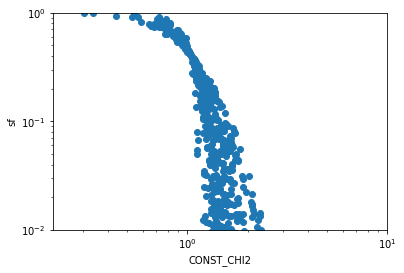

In [61]:
plt.scatter(t_zr['CONST_CHI2'],t_zr['sf'])
plt.xlabel('CONST_CHI2')
plt.ylabel('sf')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlim(0,10)
plt.ylim(1e-2,1)

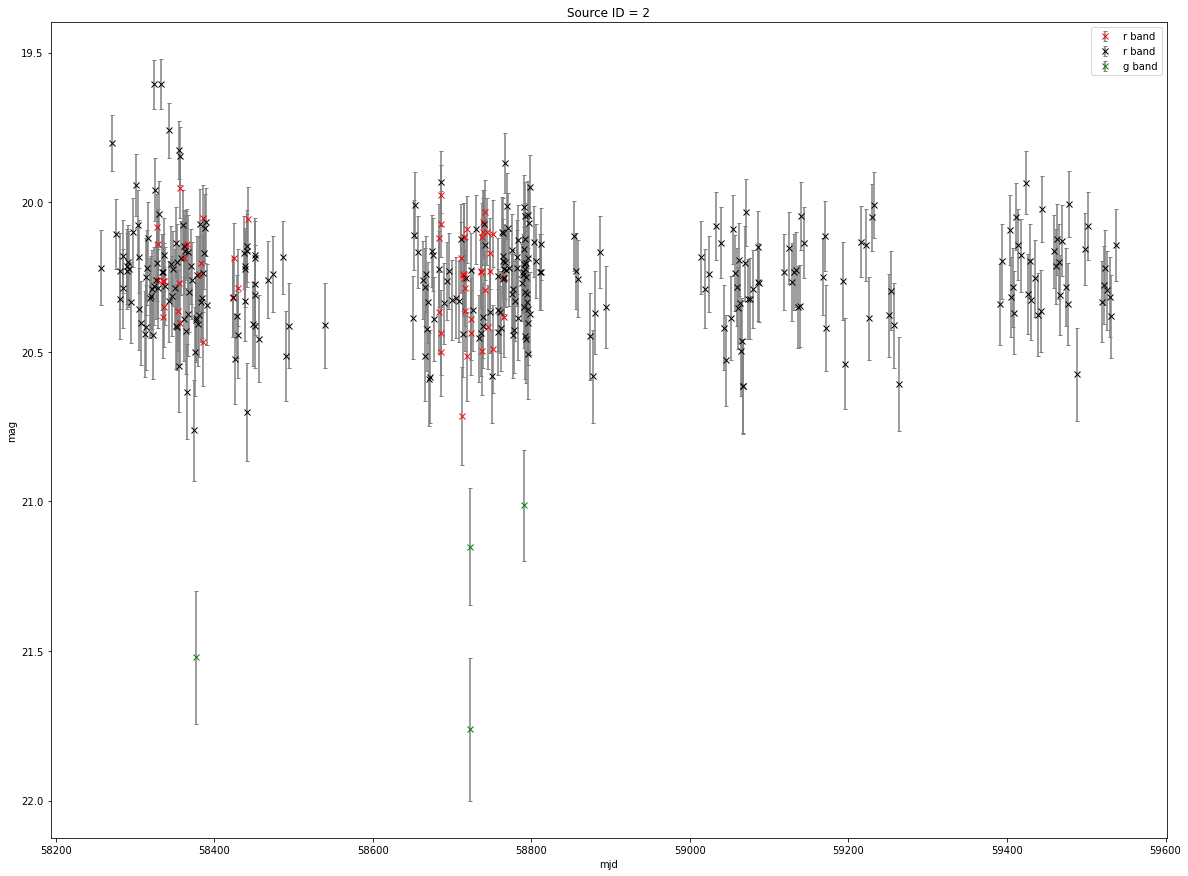

In [80]:
functions.draw_lightcurve(2)

In [74]:
t_zr[t_zr['sf']<1/(100*len(t_zr))] #99% chance variabe

SourceID,filter,OID,RA,DEC,numobs,DELTA_SIG_MAG,CONST_CHI2,sf,LNP_SIG,period,period_c,power,power_c,upsilon_class,upsilon_prob,upsilon_flag,upsilon_period
int32,str2,str16,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64
1,zr,806203100023452,5.0720632,59.3038752,851,1475.04345703125,3.9465950135138304,8.097282824411888e-167,8.227902484103418e-07,0.9988130084427033,0.9973636584210107,0.0903909967928879,0.23907869899124418,EB_ED,0.39,1.0,0.9987822499152353
1,zr,1809211300007650,5.0720654,59.3038596,77,933.955322265625,4.8384696777623635,2.8175449247338743e-44,0.9951330980141695,0.6661590419074125,2800.0,0.11034409180407394,0.011021176442487858,NonVar,0.66,1.0,0.06100051723237562
2,zr,806203100065936,5.0690334,59.3040661,501,32.81052017211914,1.89128041104094,3.684082703637489e-18,0.00631418850347139,0.5222932644063248,0.9973506025481917,0.08636127727991795,0.014344703440865914,NonVar,0.69,1.0,0.03133602413632694
3,zr,806203100057022,5.0755433,59.3020667,716,54.8082389831543,1.8577405218900844,1.8915314371435638e-22,0.01773531496378505,0.13942477460606456,0.9973636584210107,0.06052929615614375,0.006698031526300784,NonVar,0.75,1.0,0.0419956406303463
9,zr,806203100060429,5.0695279,59.3006421,160,33.828617095947266,4.255870196047637,8.534973984880083e-38,0.0005268346150012703,0.4622376008948002,0.9973007154115933,0.28059042460031963,0.022646595362365792,DSCT,0.54,1.0,0.10914292981248146
10,zr,806203100065939,5.0657057,59.3025674,226,22.787593841552734,2.181185107750765,3.742993698370006e-14,0.003517365516117289,0.13089241928368345,0.9973805045972269,0.1730804200615952,0.00272585454315101,DSCT,0.9,1.0,0.11574249854832777
11,zr,1809211300054444,5.0788531,59.3023801,53,29.407888412475586,3.2315128786941485,2.2198981801124338e-14,0.09994480712025049,0.24954007522150543,2800.0,0.28746727268456695,0.4530131426495532,DSCT,0.89,1.0,0.04884631841911708
12,zr,806203100066818,5.069274,59.3074299,167,38.567298889160156,5.525015815080241,1.2211998867834079e-57,0.00035718453275215384,0.4566261072507789,0.9973669485391912,0.287047966563011,0.007428104344558339,RRL_ab,0.7,1.0,0.4566086331879185
11,zr,806203100057021,5.07886,59.302177,439,31.370708465576172,2.558264951578153,3.057571002549502e-36,0.005270070507120773,0.17198089374738745,0.9973506025481917,0.0991731402808551,0.0006935940300561936,DSCT,0.91,1.0,0.1719852945755881


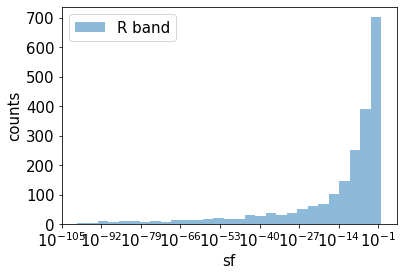

In [14]:
fs=15
histo=hist(t_zr['sf'],bins=np.logspace(np.log10(1e-100),np.log10(1),num=30),label='R band',alpha=0.5)
#plt.vlines(0.0007077841279335969,0,200,ls='--',color='r',label='cutoff')
#,histtype='step'
plt.xlabel('sf',fontsize=fs)
plt.ylabel('counts',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.gca().set_xscale("log")
#plt.gca().set_yscale("log")
#histo

In [52]:
sf=np.array(t_zr['sf'])

In [22]:
#sf.sort()

In [53]:
sf[sf==0]=3.62692045e-310

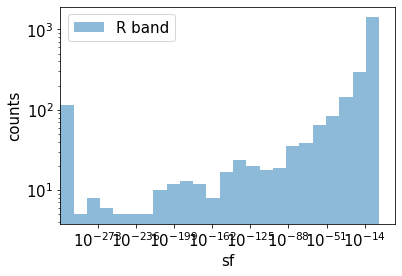

In [79]:
fs=15
histo=hist(sf,bins=np.logspace(np.log10(sf.min()),np.log10(1),num=25),label='R band',alpha=0.5)
#plt.vlines(0.0007077841279335969,0,200,ls='--',color='r',label='cutoff')
#,histtype='step'
plt.xlabel('sf',fontsize=fs)
plt.ylabel('counts',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
#histo

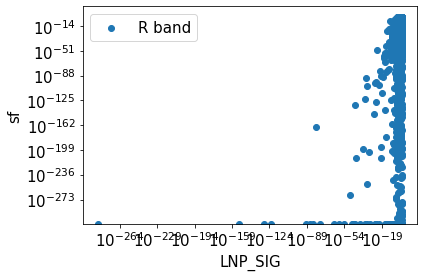

In [54]:
#plt.scatter(t_zr['LNP_SIG'],t_zr['sf'],label='R band')
plt.scatter(t_zr['LNP_SIG'],sf,label='R band')
plt.xlabel('LNP_SIG',fontsize=fs)
plt.ylabel('sf',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
#histo

In [ ]:
# rms to categories